# ==========
# = Iteration #7 =
# ==========

## Stage 1: Planning
The tasks for this stage are:
1. Compose the project team
2. Set the research question
3. Schedule all review meeting to ensure iterations are time-boxed.

### 7.1.1. Compose the project team
The project team and Clinical Review Board are CMI and CB.

### 7.1.2. Set the research question
The research question is:

_How does changing the inclusion criteria affect the output of the sequence-mining investigation? Specifically, I only include patient diagnosed before 2000, and I only view their sequences after 2010._

The new requirements specified from the previous iteration are:

1. Change the inclusion criteria to only include patient diagnosed before 2000, and I only view their sequences after 2010.
2. Remove the need for metformin to be the first prescription.

### 7.1.3. Schedule all review meeting to ensure iterations are time-boxed
CMI and CB will meet in their regular Thursday-morning meeting, which will now be fortnightly.

## Stage 2: Extraction
This tasks for this stage are:
1. Gather knowledge and insight into the processes under study and the data-generating mechanisms.
2. Obtain data for processing

### 7.2.1. Gather knowledge and insight into the processes under study and the data-generating mechanisms.
Regarding the processes under study, I, the modeller, discuss the project during weekly meetings with an experienced GP who is a professor of primary medical care.
Regarding data-generating mechanisms, I, the modeller, have gathered knowledge from over half a decade experience collaborating with clinicians and patients on research projects about electronic healthcare 
records. 

### 7.2.2. Obtain data for processing
Data have been obtain by agreement via Connected Bradford. Data are queryable via this Jupyter notebook on the GoogleCloudPlatform using AI Vertex Workbench.

Select which portions of the notebook to run.

In [1]:
# Select which portions of the notebook to run.
# ## Some of these are dependent on others so you might get
# ## warning messages if requisite data aren't available
# ## because a portion of the notebook was skipped.
run_all <- TRUE # {TRUE, FALSE, NA}
run_install <- ifelse( is.na( run_all ), TRUE, run_all )
run_define_cohort <- ifelse( is.na( run_all ), TRUE, run_all )
run_add_stratification_variables <- ifelse( is.na( run_all ), TRUE, run_all )
run_create_sts_objects <- ifelse( is.na( run_all ), TRUE, run_all )
run_process_mining_summary <- ifelse( is.na( run_all ), FALSE, run_all )
run_complexity_statistics <- ifelse( is.na( run_all ), FALSE, run_all )
run_Sankey_plots <- ifelse( is.na( run_all ), TRUE, run_all )
run_laneSwitching_plots <- ifelse( is.na( run_all ), TRUE, run_all )
run_evaluation_rig <- ifelse( is.na( run_all ), FALSE, run_all )

Install R packages.

In [2]:
#######################
## Install packages. ##
#######################
if ( run_install )
    {
        #devtools::install_github("davidsjoberg/ggsankey")
        install.packages( "pacman" )
        library( pacman )
        pacman::p_load(
            bigrquery
            ,data.table
            ,GGally
            ,ggsankey
            ,gtable
            ,grid
            ,gridExtra
            ,paletteer
            ,readr
            ,tidytext
            ,tidyverse
            ,TraMineR
            ,TraMineRextras
            
        )
    }


#remotes::install_version("<name>", "<version>")
#install.packages("<name>", dependencies = TRUE, repos='http://cran.rstudio.com/')

#remotes::install_version("dbplyr", "2.3.4")
#library(dbplyr)
#available.packages()['dbplyr',]

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



Set and load requisites.

In [5]:
r_tbl_srcode <- dplyr::tbl( con, "yhcr-prd-phm-bia-core.CB_FDM_PrimaryCare.tbl_srcode" )

ERROR: [1m[33mError[39m in `tbl_sql()`:[22m
[1m[22m[33m![39m Failed to find table
  `yhcr-prd-phm-bia-core.CB_FDM_PrimaryCare.tbl_srcode`.
[36mℹ[39m Did you mean `from =
  I("yhcr-prd-phm-bia-core.CB_FDM_PrimaryCare.tbl_srcode")`?
[1mCaused by error in `db_query_fields.DBIConnection()`:[22m
[1m[22m[33m![39m Can't query fields.
[36mℹ[39m Using SQL: SELECT * FROM
  `yhcr-prd-phm-bia-core.CB_FDM_PrimaryCare.tbl_srcode` `q03` WHERE (0 = 1)
[1mCaused by error in `BigQueryResult()`:[22m
[1m[22m[33m![39m Job yhcr-prd-phm-bia-core.job_NvsGugxb5kvO8h4EGEKM7IyN1eJb.US failed
[31m✖[39m Access Denied: Table yhcr-prd-phm-bia-core:CB_FDM_PrimaryCare.tbl_srcode:
  User does not have permission to query table
  yhcr-prd-phm-bia-core:CB_FDM_PrimaryCare.tbl_srcode, or perhaps it does not
  exist. [accessDenied]


In [3]:
##############################
## Set and load requisites. ##
##############################

# Setup connection to GCP.
project_id = "yhcr-prd-phm-bia-core"
con <- DBI::dbConnect( drv = bigquery(), project = project_id ) %>% suppressWarnings()

# Define R tibbles from GCP tables.
#r_tbl_srcode <- dplyr::tbl( con, dbplyr::in_schema( sql( "CB_FDM_PrimaryCare" ), sql( "tbl_srcode" ) ) )
r_tbl_srcode <- dplyr::tbl( con, "yhcr-prd-phm-bia-core.CB_FDM_PrimaryCare.tbl_srcode" )
r_tbl_srpatient <- dplyr::tbl( con, "CB_FDM_PrimaryCare.tbl_srpatient" )
r_tbl_BNF_DMD_SNOMED_lkp <- dplyr::tbl( con, "CB_LOOKUPS.tbl_BNF_DMD_SNOMED_lkp" )
r_tbl_srprimarycaremedication <- dplyr::tbl( con, "CB_FDM_PrimaryCare.tbl_srprimarycaremedication" )
r_tbl_srappointment <- dplyr::tbl( con, "CB_FDM_PrimaryCare.tbl_srappointment" )

# Clinical code lists (BNF, SNOMED-CT, etc).
# ## Medication codes.
codes_SNOMED_diagnoses_of_interest <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-dmtype2_cod-20200812.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_test_of_interest <-
    readr::read_csv(file = paste0( 'codelists/', 'opensafely-glycated-haemoglobin-hba1c-tests-3e5b1269.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_BNF_metformin <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-metformin-bnf-0601022b0-and-child-bnf-codes-only-43e7d87e.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
names_metformin_meds <-
    r_tbl_BNF_DMD_SNOMED_lkp %>%
    dplyr::filter( BNF_Code %in% codes_BNF_metformin ) %>%
    dplyr::select( DMplusD_ProductDescription )
BNF_meds_of_interest <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-bnf-section-61-drugs-for-diabetes-207573b7.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )
codes_BNF_meds_of_interest <-
    BNF_meds_of_interest$code
# ## ## Aggregate the medications to the first nine digits of their BNF codes.
names_meds_of_interest <-
    r_tbl_BNF_DMD_SNOMED_lkp %>%
    dplyr::filter( BNF_Code %in% codes_BNF_meds_of_interest ) %>%
    dplyr::select( BNF_Code, DMplusD_ProductDescription ) %>%
    dplyr::mutate(
        BNF_Code_short = stringr::str_sub( BNF_Code, end = 9 )
        ) 
shortNames_meds_of_interest <-
    names_meds_of_interest %>%
    dplyr::collect() %>%
    dplyr::left_join(
         BNF_meds_of_interest %>% filter(nchar(code) == 9)
        ,by = join_by( BNF_Code_short == code )
    ) %>%
    dplyr::select( -c( BNF_Code, BNF_Code_short ) ) %>%
    dplyr::rename(
        drug_name = DMplusD_ProductDescription
        ,drug_name_short = term
    ) %>%
    dplyr::distinct()
# ## Multimorbidity codes.
codes_SNOMED_depression <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-depr_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_anxiety <-
    readr::read_csv(file = paste0( 'codelists/', 'opensafely-anxiety-disorders-6aef605a.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_substanceAbuse <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-illsub_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_dementia <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-dem_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_SMI <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-mh_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_arthritis <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-c19rarth_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_lungCancer <-
    readr::read_csv(file = paste0( 'codelists/', 'opensafely-lung-cancer-snomed-2020-04-15.csv' ),
                    col_types = cols( id = col_character(), name = col_character() ) )$id
codes_SNOMED_otherCancer <-
    readr::read_csv(file = paste0( 'codelists/', 'opensafely-cancer-excluding-lung-and-haematological-snomed-2020-04-15.csv' ),
                    col_types = cols( id = col_character(), name = col_character() ) )$id
codes_SNOMED_haemCancer <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-c19haemcan_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_hypertension <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-hyp_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_hyperlipid <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-hyperlipidaemia-68d4d269.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_cardiacArrhythmia <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-cardiac-arrhythmias-4fc55f34.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_asthma <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-ast_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_CAD <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-coronary-artery-disease-36b5ebff.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_COPD <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-copd_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_osteo <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-osteo_cod-20200812.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_CKD1and2 <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-ckd1and2atrisk1_cod-20200812.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_CKD3to5 <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-ckdatrisk2_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_CHF <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-congestive-heart-failure-1da678ca.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_hepatitis <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-hepatitis-04970595.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_all_multimorbidity_diagnoses <-
    c(
        codes_SNOMED_anxiety
        ,codes_SNOMED_arthritis
        ,codes_SNOMED_asthma
        ,codes_SNOMED_CAD
        ,codes_SNOMED_cardiacArrhythmia
        ,codes_SNOMED_CHF
        ,codes_SNOMED_CKD1and2
        ,codes_SNOMED_CKD3to5
        ,codes_SNOMED_COPD
        ,codes_SNOMED_depression
        ,codes_SNOMED_dementia
        ,codes_SNOMED_haemCancer
        ,codes_SNOMED_hepatitis
        ,codes_SNOMED_hyperlipid
        ,codes_SNOMED_hypertension
        ,codes_SNOMED_lungCancer
        ,codes_SNOMED_osteo
        ,codes_SNOMED_otherCancer
        ,codes_SNOMED_SMI
        ,codes_SNOMED_substanceAbuse
    )
# ## Did-not-attend.
codes_SNOMED_didNotAttend <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-did-not-attend-098119da.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code

# Load the CSV file containing that matches all medications in `codes_SNOMED_diagnoses_of_interest`
# with an expected duration of prescription.
##meds_expected_prescription_duration <-
 ##   readr::read_csv(file = 'meds_expected_prescription_duration.csv',
  ##                  col_types = cols( term = col_character(), duration = col_numeric() ) )

# Study dates
date_diagnosis_threshold <- lubridate::ymd('2000-01-01')
date_followup_start <- lubridate::ymd('2010-01-01')
date_followup_end <- lubridate::ymd('2019-12-31')

# Duration of months after the first prescription that we ignore before studying patterns.
pattern_delay_months <- 0

# Threshold value for the test, which in this case is HbA1c.
val_test_threshold <- 48

# Threshold for the expected interval between subsequent tests, in months
val_testing_interval_LB <- 2
val_testing_interval_UB <- 5

# Set values for meaningful changes in the values of the test.
val_meaningful_test_improvement <- -10
val_meaningful_test_disimprovement <- 10

# Set window within which to search for repeated (but not repeat) prescriptions.
window_repeated_prescription_months <- 3

# Set number of tests, treatments, or iterations after diagnosis that should be tracked.
n_iterations <- 10

# Set the date window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months.
multimorb_inclusion_window_months <- 60

# Set the window outwith which at least two mutimorbidity diagnoses must be of each other, in months.
multimorb_gap_window_months <- 1

# Set ordering of factors labels for the event variable.
df_event_factor <-
    data.frame(
        event_fct_order =
            factor(
                c( "Test Status = Red", "Test Status = Amber"
                  ,"Test Status = Yellow", "Test Status = Green"
                  ,shortNames_meds_of_interest %>%
                  dplyr::distinct( drug_name_short ) %>%
                  dplyr::arrange( drug_name_short ) %>%
                  dplyr::pull( drug_name_short )
                  ,"Unobserved"
                 )
                ,levels = c( "Test Status = Red", "Test Status = Amber"
                            ,"Test Status = Yellow", "Test Status = Green"
                            ,shortNames_meds_of_interest %>%
                            dplyr::distinct( drug_name_short ) %>%
                            dplyr::arrange( drug_name_short ) %>%
                            dplyr::pull( drug_name_short )
                            ,"Unobserved" 
                           )
            )
        ,event_colours_order = c( "firebrick1", "darkorange", "gold", "limegreen"
                                 ,paletteer_c("grDevices::Plasma"
                                              ,shortNames_meds_of_interest %>%
                                              dplyr::distinct( drug_name_short ) %>%
                                              nrow()
                                             )
                                 ,"grey"
                                 )
    )

# Set ordering of H.M.A. stratification.
df_HMA_factor <-
    data.frame(
        HMA_fct_order =
            factor(
                c("Hold", "Monitor", "Adjust", "Unobserved")
                ,levels = c("Hold", "Monitor","Adjust", "Unobserved")
            )
        ,HMA_colours_order = c( "plum1", "lightcoral", "cornflowerblue", "grey" )
    )


# Set ordering of HMAandTestStatus stratification.
df_HMAandTestStatus_factor <-
    data.frame(
        HMAandTestStatus_fct_order =
            factor(
                c(
                  "Hold Red" ,"Hold Amber" ,"Hold Yellow" ,"Hold Green"
                  ,"Monitor Red","Monitor Amber", "Monitor Yellow", "Monitor Green"
                  ,"Adjust Red", "Adjust Amber", "Adjust Yellow", "Adjust Green"
                  ,"Unobserved"
                 )
                ,levels = 
                    c(
                      "Hold Red" ,"Hold Amber" ,"Hold Yellow" ,"Hold Green"
                      ,"Monitor Red","Monitor Amber", "Monitor Yellow", "Monitor Green"
                      ,"Adjust Red", "Adjust Amber", "Adjust Yellow", "Adjust Green"
                      ,"Unobserved"
                     )
            )
        ,HMAandTestStatus_colours_order =
                c( rep( c("firebrick1", "darkorange", "gold", "limegreen"), times = 3), "grey" )
    )

# Set ordering of TandI stratification.
df_TandI_factor <-
    data.frame(
        TandI_fct_order =
            factor(
                c(
                    'Red Zero Rx', 'Red One Rx', 'Red Two Rx', 'Red More Rx',
                    'Amber Zero Rx', 'Amber One Rx', 'Amber Two Rx', 'Amber More Rx',
                    'Yellow Zero Rx', 'Yellow One Rx', 'Yellow Two Rx', 'Yellow More Rx',
                    'Green Zero Rx', 'Green One Rx', 'Green Two Rx', 'Green More Rx',
                    'Unobserved'
                )
                ,levels =
                c(
                    'Red Zero Rx', 'Red One Rx', 'Red Two Rx', 'Red More Rx',
                    'Amber Zero Rx', 'Amber One Rx', 'Amber Two Rx', 'Amber More Rx',
                    'Yellow Zero Rx', 'Yellow One Rx', 'Yellow Two Rx', 'Yellow More Rx',
                    'Green Zero Rx', 'Green One Rx', 'Green Two Rx', 'Green More Rx',
                    'Unobserved'
                )
            )
        ,TandI_colours_order =
                c(
                    "red" # 1: Test status == Red & Zero prescriptions
                    ,"firebrick3" # 2: Test status == Red & One prescriptions
                    ,"firebrick4" # 3: Test status == Red & Two prescriptions
                    ,"darkred" # 4: Test status == Red & Three prescriptions

                    ,"orange" # 5: Test status == Amber & Zero prescriptions
                    ,"darkorange2" # 6: Test status == Amber & One prescriptions
                    ,"darkorange3" # 7: Test status == Amber & Two prescriptions
                    ,"darkorange4" # 8: Test status == Amber & Three prescriptions

                    ,"yellow" # 9: Test status == Yellow & Zero prescriptions
                    ,"gold2" # 10: Test status == Yellow & One prescriptions
                    ,"gold3" # 11: Test status == Yellow & Two prescriptions
                    ,"gold4" # 12: Test status == Yellow & Three prescriptions

                    ,"green" # 13: Test status == Green & Zero prescriptions
                    ,"chartreuse2" # 14: Test status == Green & One prescriptions
                    ,"chartreuse3" # 15: Test status == Green & Two prescriptions
                    ,"chartreuse4" # 16: Test status == Green & Three prescriptions

                    ,"grey" # 0 = Unobserved
                )
    )

# Set ordering of TandMultiMorb stratification.
df_TandMultiMorb_factor <-
    data.frame(
        TandMultiMorb_fct_order =
            factor(
                c(
                    'Red Multimorbid', 'Amber Multimorbid', 'Yellow Multimorbid', 'Green Multimorbid',
                    'Red Not multimorbid', 'Amber Not multimorbid', 'Yellow Not multimorbid', 'Green Not multimorbid',
                    'Unobserved'
                )
                ,levels =
                c(
                    'Red Multimorbid', 'Amber Multimorbid', 'Yellow Multimorbid', 'Green Multimorbid',
                    'Red Not multimorbid', 'Amber Not multimorbid', 'Yellow Not multimorbid', 'Green Not multimorbid',
                    'Unobserved'
                )
            )
        ,TandMultiMorb_colours_order =
                c(
                    "red4" # 1: Test status == Red & Multimorbid
                    ,"orangered3" # 2: Test status == Amber & Multimorbid
                    ,"gold2" # 3: Test status == Yellow & Multimorbid
                    ,"darkgreen" # 4: Test status == Green & Multimorbid
                    
                    ,"red" # 5: Test status == Red & Not multimorbid
                    ,"orange" # 6: Test status == Amber & Not multimorbid
                    ,"yellow" # 7: Test status == Yellow & Not multimorbid
                    ,"green" # 8: Test status == Green & Not multimorbid

                    ,"grey" # 0 = Unobserved
                )
    )

ERROR: [1m[33mError[39m in `tbl_sql()`:[22m
[1m[22m[33m![39m Failed to find table `CB_FDM_PrimaryCare.tbl_srcode`.
[36mℹ[39m Did you mean `from = I("CB_FDM_PrimaryCare.tbl_srcode")`?
[1mCaused by error in `db_query_fields.DBIConnection()`:[22m
[1m[22m[33m![39m Can't query fields.
[36mℹ[39m Using SQL: SELECT * FROM `CB_FDM_PrimaryCare.tbl_srcode` `q01` WHERE (0 = 1)
[1mCaused by error in `BigQueryResult()`:[22m
[1m[22m[33m![39m Job yhcr-prd-phm-bia-core.job_4NZqtfStd6aM3RwY_Krct7fYeblG.US failed
[31m✖[39m Access Denied: Table yhcr-prd-phm-bia-core:CB_FDM_PrimaryCare.tbl_srcode:
  User does not have permission to query table
  yhcr-prd-phm-bia-core:CB_FDM_PrimaryCare.tbl_srcode, or perhaps it does not
  exist. [accessDenied]


Define study cohort.

This was trivial in previous iterations because I relied on clinically-coded diagnoses, only. This time I will also permit diagnosis to be indicated by abnormal HbA1c (i.e. >48 mmol/mol). The justification is that concurrent work by CMI and colleagues shows that clinically-coded dates of diabetes diagnosis disagree with HbA1c values by more than 10 years. The HbA1c values are superior indicators but the validity of HbA1c values decreases as we go further back in the record because they weren't used diagnostically until a while after introduction. Therefore, in the early days, we will have to trust the clinically-coded date.

In an email sent 26th July 2024, CB suggested a three-option algorthin for identifying the date of diagnosis:
1. If the clinically-coded diagnosis is <u>before</u> April 2004 AND there are raised HbA1c values <u>after</u> April 2003 (note the difference in years), then use the clinically-coded date.
    - The actual statement from CB was: if the clinically-coded diagnosis is before April 2004 AND some "recent" raised HbA1c, then use the clinically-coded date, on the assumption that the date is not miscoded. This requries a threshold for "recent" (or does he mean "concurrent"?).
2. If the clinically-coded diagnosis is <u>after</u> April 2004 AND there are raised HbA1c values before April 2003 (note the difference in years), then use the earliest raised HbA1c date.
3. If the clinically-coded diagnosis is <u>after</u> April 2004 AND the first raised HbA1c value is after April 2003 (note the difference in years), then use the clinically-coded date.

My approach to identifying the date of diagnosis will be to start with the original method of using clinical codes, and then only change the date if it satisfies option #2, above.

First, I need to convert historic A1c% values to up-to-date mmol/mol values (Formala taken from https://ebmcalc.com/GlycemicAssessment.htm). Then I will define the cohort of relevant records.

In [ ]:
# First, I need to convert historic A1c% values to up-to-date mmol/mol values. Formala taken from https://ebmcalc.com/GlycemicAssessment.htm
if ( run_define_cohort )
    {
        r_tbl_srcode <-
            r_tbl_srcode %>%
            dplyr::select( person_id, dateevent, numericvalue, snomedcode ) %>%
            # Convert A1c% values to mmol/mol values. Formala taken from https://ebmcalc.com/GlycemicAssessment.htm
            dplyr::mutate(
                numericvalue = 
                    dplyr::if_else(
                        ( snomedcode %in% codes_SNOMED_test_of_interest ) & sql("REGEXP_CONTAINS( numericvalue, r'\\.')" )
                        ,( numericvalue %>% as.numeric() %>% `-`( 2.15 ) ) %>% `*`( 10.929 ) %>% as.character()
                        ,numericvalue
                    )
            )
    }

In [ ]:
####################
## Define cohort. ##
####################
if ( run_define_cohort )
    {
        qry_records_with_T2DM_diagnoses_coded <-
            r_tbl_srcode %>%
            # Identify records with a clinical code for Type 2 Diabetes Mellitus.
            dplyr::filter( snomedcode %in% codes_SNOMED_diagnoses_of_interest ) %>%
            dplyr::group_by( person_id ) %>%
            dplyr::summarise( date_coded_diagnosis = min( dateevent, na.rm = TRUE ) ) %>%
            dplyr::ungroup() %>%
            dplyr::select( person_id, date_coded_diagnosis ) %>%
            # Identify records whose clinically-coded date of diagnosis is after April 2004.
            dplyr::mutate(
                coded_diagnosis_before_April2004 =
                    dplyr::if_else(
                        ( date_coded_diagnosis < '2004-04-01' )
                        ,TRUE
                        ,FALSE
                    )
            )
    
        qry_records_with_T2DM_diagnoses_HbA1c <-
            r_tbl_srcode %>%
            dplyr::filter( snomedcode %in% codes_SNOMED_test_of_interest) %>%
            dplyr::select( person_id, dateevent, numericvalue ) %>%
            # Filter for raised test scores.
            dplyr::filter( as.numeric( numericvalue ) > 48 ) %>%
            # Identify records with raised HbA1c values before April 2003.
            dplyr::mutate(
                raised_HbA1c_before_April2003 =
                    dplyr::if_else(
                        ( dateevent  < '2003-04-01' )
                        ,TRUE
                        ,FALSE
                    )
            ) %>%
            # Filter for the earliest test that has satisfied the criteria so far.
            dplyr::group_by( person_id ) %>%
            dplyr::filter( dateevent == min( dateevent ) ) %>%
            # Filter for the largest score because, sometimes, a patient has two tests on the same date, one of which seems spuriously low.
            dplyr::filter( as.numeric( numericvalue ) == max( as.numeric( numericvalue ) ) ) %>%
            dplyr::ungroup() %>%
            # Tidy up.
            dplyr::rename( date_HbA1c_diagnosis = dateevent)
    
        qry_records_with_T2DM_diagnoses <-
            # Join the two query results.
            qry_records_with_T2DM_diagnoses_coded %>%
            dplyr::left_join( qry_records_with_T2DM_diagnoses_HbA1c, by = join_by( person_id ) ) %>%
            # Choose the date based on CB's definitions.
            dplyr::mutate(
                date_diagnosis = 
                    dplyr::case_when(
                        is.na( date_HbA1c_diagnosis ) ~ date_coded_diagnosis
                        ,is.na( date_coded_diagnosis ) ~ date_HbA1c_diagnosis
                        # Option 1.
                        ,( coded_diagnosis_before_April2004 == TRUE ) & ( raised_HbA1c_before_April2003 == FALSE ) ~ date_coded_diagnosis
                        # Option 2.
                        ,( coded_diagnosis_before_April2004 == FALSE ) & ( raised_HbA1c_before_April2003 == TRUE ) ~ date_HbA1c_diagnosis
                        # Option 3.
                        ,( coded_diagnosis_before_April2004 == FALSE ) & ( raised_HbA1c_before_April2003 == FALSE ) ~ date_coded_diagnosis
                        
                        ,TRUE ~ NA_character_
                    )
            ) %>%
            # Filter for records who diagnosis date is before the threshold.
            dplyr::filter( date_coded_diagnosis <= date_diagnosis_threshold ) %>%
            # Tidy up.
            dplyr::select( person_id, date_diagnosis )
    }

Retrieve dates of prescriptions in the follow-up period.

In [ ]:
##################################################################
## Retrieve dates of prescriptions within the follow-up period. ##
##################################################################
if ( run_define_cohort )
    {
        qry_log_prescription_longFormat <-
            qry_records_with_T2DM_diagnoses %>%
            dplyr::left_join( r_tbl_srprimarycaremedication, by = join_by( person_id ) ) %>% 
            # Select every record that has a prescription for any diabetes medication.
            dplyr::inner_join( names_meds_of_interest, by = join_by( nameofmedication == DMplusD_ProductDescription ) ) %>%
            # Filter for records within the follow-up period.
            dplyr::filter( dplyr::between( dateevent, date_followup_start, date_followup_end ) ) %>%
            dplyr::select( person_id, date_diagnosis, dateevent, nameofmedication ) %>%
            dplyr::distinct() %>%
            # Filter for however many subsequent prescriptions were specified in `n_iteraions`, then number them.
            dplyr::group_by( person_id ) %>%
            dbplyr::window_order( person_id, dateevent ) %>%
            dplyr::mutate( new_prescp_day = if_else( dateevent != lag( dateevent), 1, 0 ) ) %>%
            tidyr::replace_na( list( new_prescp_day = 1 ) ) %>%
            dplyr::mutate( i_prescrp = cumsum( new_prescp_day ) ) %>%
            dplyr::filter( i_prescrp <= n_iterations + 1 ) %>% # The "+ 1" is added so that we always include the final "Unobserved" state.
            dplyr::mutate( event_name = paste0( "prescription_", i_prescrp ) ) %>% 
            dplyr::ungroup() %>%
            # Rename columns.
            dplyr::rename(
                start_dttm = dateevent
                ,event_value = nameofmedication
            ) %>%
            # Set the end time of each prescription as the start time of the previous one.
            dplyr::group_by( person_id ) %>%
            dbplyr::window_order( person_id, start_dttm ) %>%
            dplyr::mutate( end_dttm = dplyr::if_else( person_id != lag( person_id ), start_dttm, lead( start_dttm ) ) ) %>%
            dplyr::mutate( end_dttm = dplyr::if_else( is.na( end_dttm ), start_dttm, end_dttm ) ) %>%
            dplyr::ungroup() %>%
            # Tidy up.
            dplyr::select( person_id, start_dttm, event_name, event_value, end_dttm )

        #df_log_prescription_wideFormat <-
        #    qry_log_prescription_longFormat %>%
        #    dplyr::mutate_at( .vars = vars( event_name ), .funs = funs( gsub("prescription_", "prescp", . ) ) ) %>%
        #    tidyr::pivot_wider(
        #        names_from = event_name
        #        ,values_from = c( start_dttm, event_value )
        #        , names_sort = TRUE) %>%
        #    dplyr::ungroup() %>%
        #    suppressWarnings()
    }

Retrieve dates of tests in the follow-up period.

In [ ]:
##########################################################
## Retrieve dates of tests within the follow-up period. ##
##########################################################
if ( run_define_cohort )
    {
        qry_log_prescription_longFormat <-
            qry_records_with_T2DM_diagnoses %>%
            dplyr::left_join( r_tbl_srprimarycaremedication, by = join_by( person_id ) ) %>% 
            # Select every record that has a prescription for any diabetes medication.
            dplyr::inner_join( names_meds_of_interest, by = join_by( nameofmedication == DMplusD_ProductDescription ) ) %>%
            # Filter for records within the follow-up period.
            dplyr::filter( dplyr::between( dateevent, date_followup_start, date_followup_end ) ) %>%
            dplyr::select( person_id, date_diagnosis, dateevent, nameofmedication ) %>%
            dplyr::distinct() %>%
            # Filter for however many subsequent prescriptions were specified in `n_iteraions`, then number them.
            dplyr::group_by( person_id ) %>%
            dbplyr::window_order( person_id, dateevent ) %>%
            dplyr::mutate( new_prescp_day = if_else( dateevent != lag( dateevent), 1, 0 ) ) %>%
            tidyr::replace_na( list( new_prescp_day = 1 ) ) %>%
            dplyr::mutate( i_prescrp = cumsum( new_prescp_day ) ) %>%
            dplyr::filter( i_prescrp <= n_iterations + 1 ) %>% # The "+ 1" is added so that we always include the final "Unobserved" state.
            dplyr::mutate( event_name = paste0( "prescription_", i_prescrp ) ) %>% 
            dplyr::ungroup() %>%
            # Rename columns.
            dplyr::rename(
                start_dttm = dateevent
                ,event_value = nameofmedication
            ) %>%
            # Set the end time of each prescription as the start time of the previous one.
            dplyr::group_by( person_id ) %>%
            dbplyr::window_order( person_id, start_dttm ) %>%
            dplyr::mutate(
                end_dttm = dplyr::if_else( person_id != lag( person_id ), start_dttm, lead( start_dttm ) )
            ) %>%
            dplyr::mutate( end_dttm = dplyr::if_else( is.na( end_dttm ), start_dttm, end_dttm )  )%>%
            dplyr::ungroup() %>%
            # Tidy up.
            dplyr::select( person_id, start_dttm, event_name, event_value, end_dttm )

        #df_log_prescription_wideFormat <-
        #    qry_log_prescription_longFormat %>%
        #    dplyr::mutate_at( .vars = vars( event_name ), .funs = funs( gsub("prescription_", "prescp", . ) ) ) %>%
        #    tidyr::pivot_wider(
        #        names_from = event_name
        #        ,values_from = c( start_dttm, event_value )
        #        , names_sort = TRUE) %>%
        #    dplyr::ungroup() %>%
        #    suppressWarnings()
    }

In [ ]:
######################################################
## Retrieve dates of tests in the follow-up period. ##
######################################################
if ( run_define_cohort )
    {
        qry_log_test_longFormat <- 
            qry_records_with_T2DM_diagnoses %>%
            dplyr::left_join( r_tbl_srcode, by = join_by( person_id ) ) %>% 
            # Filter records for only those that refer to the test of interest.
            dplyr::filter( snomedcode %in% codes_SNOMED_test_of_interest ) %>% 
            # Extract the required fields.
            dplyr::select( person_id, dateevent, numericvalue ) %>%
            dplyr::distinct() %>%
            # Filter out test scores of 0, which are expected to be data entry anomalies, given my selection of columns.
            dplyr::filter( numericvalue != "0" ) %>%
             # Filter for records within the follow-up period.
            dplyr::filter( dplyr::between( dateevent, date_followup_start, date_followup_end ) ) %>%
            # Rename columns.
            dplyr::rename(
                start_dttm = dateevent
                ,event_value_numeric = numericvalue
            ) %>% 
            # Filter for however many subsequent tests were specified in `n_iteraions`, then number them.
            dplyr::group_by( person_id ) %>% 
            dbplyr::window_order( start_dttm ) %>% 
            dplyr::filter( row_number() <= n_iterations + 1 ) %>% # The "+ 1" is added so that we always include the final "Unobserved" state.
            dplyr::mutate( event_name = paste0( "test_", row_number() - 1 ) ) %>% 
            dplyr::ungroup() %>% 
            # Set the end time each test as the start time of the previous one.
            dplyr::group_by( person_id ) %>%
            dbplyr::window_order( start_dttm ) %>%
            dplyr::mutate( end_dttm = lead( start_dttm ) ) %>% 
            dplyr::ungroup() %>%
            # Convert the numeric test values into labels.
            dplyr::mutate( event_value_numeric = as.numeric( event_value_numeric ) ) %>%
            dplyr::mutate(
                event_value = dplyr::case_when(
                    is.na( event_value_numeric ) ~ NA_character_
                    ,event_value_numeric > 70 ~ "Test Status = Red"
                    ,event_value_numeric > 58  ~ "Test Status = Amber"
                    ,event_value_numeric > 48 ~ "Test Status = Yellow"
                    ,TRUE ~ "Test Status = Green"
                    )
            ) %>%
            # Tidy up.
            dplyr::select( person_id, start_dttm, event_name, event_value, end_dttm ) %>%
            dplyr::distinct()

        ## Convert to wide format, if ever needed.
        #qry_log_test_wideFormat <-
        #    qry_log_test_longFormat %>%
        #    tidyr::pivot_wider(
        #        names_from = event_name
        #        ,values_from = c( start_dttm, event_value )
        #        ,names_sort = TRUE)
    }

Create a variable to indicate the date from which we no longer observe the patient in the record.

In [ ]:
# Firstly, retrieve the dates of death, if they exist, and use them to inform a variable
# called `date_unobserved` to indicate the date from which we no longer observe
# the patient in the record.
if ( run_define_cohort )
    {
        patients_of_interest_with_death_dates <-
            r_tbl_srpatient %>%
            # Select only those patients in whom we are interested.
            dplyr::inner_join( qry_records_with_T2DM_diagnoses, by = join_by( person_id ) )
    
        if( !is.na( nrow( patients_of_interest_with_death_dates ) ) )
            {
                df_date_unobserved <-
                    patients_of_interest_with_death_dates %>%
                    dplyr::select( person_id, datedeath ) %>% 
                    dplyr::distinct() %>%
                    dplyr::collect() %>%
                    tidyr::separate(
                        col = datedeath
                        ,sep = 4
                        ,into = c( "death_year", "death_month" )
                    ) %>%
                    dplyr::mutate(
                        date_unobserved = 
                            dplyr::if_else(
                                is.na( death_year )
                                ,NA
                                ,ISOdate( year = death_year, month = death_month, day = 1, hour = 0 )
                            )
                    ) #%>%
                    # If there are multiple dates of death, chose the earliest one.
                    dplyr::group_by( person_id ) %>%
                    dplyr::filter( if (is.na( date_unobserved ) ) min( date_unobserved, na.rm = TRUE) else date_unobserved ) %>%
                    dplyr::ungroup() %>%
                    # Tidy up.
                    dplyr::select( person_id, date_unobserved ) %>%
                    dplyr::arrange( person_id )
            } else {
                df_date_unobserved <-
                    data.frame(
                        person_id = integer(0)
                        ,date_unobserved = Date(0)
                    )
            }
    }

Append the prescriptions and tests dataframe logs.

In [ ]:
if ( run_define_cohort )
    {
        df_log_PandT_longFormat <-
            qry_log_prescription_longFormat %>%
            dplyr::union_all( qry_log_test_longFormat ) %>%
            dplyr::ungroup() %>% 
            dplyr::distinct() %>%
            dplyr::arrange( person_id, start_dttm ) %>%
            # Include a date from which we stop observing the patient in the record.
            # This will be either the date of death or one second after the `end_dttm`
            # of the last event in a patient's record.
            dplyr::collect() %>%
            dplyr::group_by( person_id ) %>%
            dplyr::group_modify( ~ tibble::add_row( .x ), .by = person_id ) %>% 
            dplyr::left_join( df_date_unobserved, by = join_by( person_id ) ) %>%
            dplyr::mutate( start_dttm = if_else( is.na( start_dttm ), date_unobserved , start_dttm ) ) %>%
            dplyr::ungroup() %>%
            # Update `event_name` so that it shows "Unobserved", where appropriate.
            dplyr::mutate( event_value = if_else( is.na( event_value ), "Unobserved", event_value ) ) %>%
            # Update `start_dttm` so that it shows one second after the last
            # `start_dttm` whenever `date_unobserved` is NA. 
            dplyr::mutate( start_dttm = if_else( is.na( start_dttm ), lag( start_dttm ) + lubridate::seconds(1), start_dttm ) ) %>%
            # Update `end_dttm` for the final observed event. It should no longer read
            # as NA because the "Unobserved" follows it 
            dplyr::mutate( end_dttm = if_else( lead( event_value ) == "Unobserved", lead( start_dttm ), end_dttm ) ) %>%
            suppressWarnings() %>%
            dplyr::select( - date_unobserved ) %>%
            dplyr::arrange( person_id, start_dttm ) #%>%
            ## Add the syntax that is below if you want the `end_dttm` variable that
            ## to be recalculated for the combined and ordered tests-and-prescrpitions.
            ## Otherwise, the `end_dttm` value for a given event is the `start_dttm` of
            ## the next test if the given event is a test, but is of the next prescription
            ## if the given event is a prescrition
            #dplyr::group_by( person_id ) %>%
            #dplyr::mutate_at(
            #    .vars = vars( end_dttm )
            #    ,.funs = funs(
            #        dplyr::if_else( event_name == "diagnosis", start_dttm, lead( start_dttm ) )
            #    )
            #) %>%
            #dplyr::mutate_at(
            #    .vars = vars( end_dttm )
            #    ,.funs = funs( dplyr::if_else( is.na( end_dttm ), start_dttm, end_dttm ) )
            #) %>%
            #dplyr::ungroup() %>%
            #suppressWarnings()

        #df_log_PandT_wideFormat <-
            #df_log_PandT_longFormat %>%
            #tidyr::pivot_wider(
            #    names_from = event_name
            #    ,values_from = c( start_dttm, event_value )
            #    ,names_sort = TRUE)
    }

Retrieve indication of diagnoses used in the calculation of comorbidity.

In this iteration, I will use the Mayo Clinic's definition* of two or more of 19 specified conditions, where diabetes is one, separated by 30 days ([Rocca et al. (2014)](http://dx.doi.org/10.1016/j.mayocp.2014.07.010)). This means that I only need to identify patients that have at least one of the diagnostic codes in `codes_SNOMED_all_multimorbidity_diagnoses` 30 days before or after their diagnosis for Type 2 Diabetes Mellitus.



\*Rocca et al. (2014) used ICD-10 codes but I use SNOMED-CT codes.

In [ ]:
if ( run_define_cohort )
    {
        qry_log_multimorb_longFormat <-
            r_tbl_srcode %>%
            # Filter for only those patients that we already identified in our prescription table.
            dplyr::inner_join( qry_log_prescription_longFormat %>% dplyr::select( person_id ), by = join_by( person_id ) ) %>%
            # Filter records for only those that refer to one of the diagnoses that constitute the multimorbidity variable.
            dplyr::filter( snomedcode %in% codes_SNOMED_all_multimorbidity_diagnoses ) %>% 
            # Extract the required fields.
            dplyr::select( person_id, dateevent, snomedcode ) %>%
            # Rename columns.
            dplyr::rename( date_multimorb = dateevent ) %>%
            # Include each person's date of diagnosis.
            dplyr::left_join( qry_records_with_T2DM_diagnoses, by = join_by( person_id ) ) %>%
            # Filter for multimorbidity diagnoses recorded outwith the multimorbidity gap window of the date of diagnosis of the main diagnosis of interest.
            dplyr::filter(
                ( sql( paste0( 'DATE_DIFF( date_multimorb, date_diagnosis, MONTH)' ) ) %>% abs() ) >= multimorb_gap_window_months
            ) %>%
            dplyr::select( - c( date_diagnosis, snomedcode ) ) %>%
            dplyr::distinct() %>% 
            # Filter for the earliest date of the multimorbdity diagnosis.
            dplyr::group_by( person_id ) %>%
            dplyr::filter(
                date_multimorb == min( date_multimorb )
            ) %>%
            dplyr::ungroup() %>%
            # Tidy up.
            dplyr::arrange(person_id, date_multimorb )
    }

## Stage 3: Data processing
This tasks for this stage are:
1. Assess data quality
2. Format data for study

### 7.3.1. Assess data quality
I will not assess data quality for this illustrative example. Proper project should always assess data quality, perhaps using [Weiskopf and Weng's 3X3 DQA](https://www.sci-hub.wf/10.1136/amiajnl-2011-000681).

### 7.3.2. Format data for study
I will use the `TraMineR` package in R for sequence pattern mining. The data needs to be in the format of state-sequence object. The easiest way to create the state-sequence object is to use the SQL-extracted time series to define a time-series object, which can then be converted into an STS object using `TraMineRextras::TSE_to_STS()`.

Now, I create the simplified dataframe object from the first iteration (i.e. the SQL-extracted dataframe to only focus on a handful of medications because this is only an example).

In [ ]:
# Simplify the event names and values.
if ( run_define_cohort )
    {
        df_log_PandT_longFormat_simplified <-
            df_log_PandT_longFormat %>%
            # Remove the numbers in the event name.
            dplyr::mutate_at(
                .vars = vars( event_name )
                ,.funs = ~ gsub( "_[0-9]", "", . )
            ) %>% 
            # Aggregate medications.
            dplyr::left_join(
                shortNames_meds_of_interest
                ,by = join_by( event_value == drug_name )
            ) %>%
            dplyr::mutate(
                event_value = dplyr::if_else( is.na( drug_name_short ), event_value, drug_name_short )
            ) %>%
            dplyr::select( -drug_name_short ) %>%
            # Convert to factor ## Can no longer do this because the factor list is too large.
            dplyr::mutate_at(
                .vars = vars( event_value )
                ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()
    }

Before I can begin analysing the data, I need to define the strata proposed by the Clinical Review Board. The stratifications were:
- H.M.A.: Four strata defined by combinations of {'Expected', 'Shorter-than-expected'} testing intervals and {'No observed change', 'Observed change'} in prescriptions. The H.M.A. acronym derives from the three strata: (0,0)-Hold; (1,0)-Monitor; (0 or 1, 1)-Adjust.
- Tests-and-Interventions: Twelve strata defined by combinations of the test statuses and whether the patient is on one, two or three medications simulatneously.
- Multimorbidity: Two strata defined by whether or not there is a record for at least one of the multimorbidity diagnositic codes.

The first thing I do is to add a variable that indicates the patient-specific test interval. This will be handy for bounding the variables I need to create.

In [ ]:
# Create a variable that indicates patient-specific test interval.
if ( run_add_stratification_variables )
    {
        df_log_PandT_longFormat_simplified_StrataLabels <-
            df_log_PandT_longFormat_simplified %>%
            dplyr::group_by( person_id ) %>%
            dplyr::arrange( start_dttm ) %>%
            dplyr::mutate(
                idx_test_interval = 0 + cumsum( stringr::str_detect( event_value, pattern = "Test" ) )
            ) %>% 
            dplyr::ungroup() %>%
            # Remove any record with `idx_test_interval` == 0, which indicates no tests on record.
            #dplyr::filter( idx_test_interval != 0 ) %>%
            # Remove any calculated `idx_test_interval` for which the `event_value` is "Unobserved".
            dplyr::mutate(
                idx_test_interval =
                    dplyr::if_else( event_value == "Unobserved", NA_integer_, idx_test_interval )
            ) %>%
            # Tidy up.
            dplyr::distinct() %>%
            dplyr::arrange( person_id, start_dttm )
    }

__H.M.A. stratification__

The two components of this stratification are the testing interval and the change in prescription. The testing interval requries me to create a variable indicating that the inter-test duration was between `val_testing_interval_LB` and `val_testing_interval_UB`. The change in prescription requires me to create a variable indicating whether the prescriptions before and after an index test event are the same.

The first thing is to calculate the inter-test duration. In this iteration, I will have to ignore the interval between the diagnostic test and the subsequent test because I am deliberately looking at records ten years after the diagnostic test.

In [ ]:
# Isn't it OK for loads of NAs between the diagnosis and the next test? Shouldn't the plan be to remove
# all rows before the first test before calculating HMA? There is no need. Instead, calculate HMA for
# everything but filter out NA for any HMA analyses.

In [ ]:
if ( run_add_stratification_variables )
    {
        df_inter_test_duration <-
            qry_log_test_longFormat %>%
            dplyr::filter( event_name != "diagnosis" ) %>%
            # Calculate the duration between each test and the next.
            dplyr::mutate( inter_test_duration_cont = sql( "DATE_DIFF( end_dttm, start_dttm, MONTH )" ) ) %>%
            # If the event is a diagnosis, then I need to calculate the inter-test duration in a different way.
            dplyr::group_by( person_id ) %>%
            dplyr::mutate(
                inter_test_duration_cont =
                    dplyr::if_else(
                        event_name == "diagnosis"
                        ,sql( "DATE_DIFF( LEAD( start_dttm ) OVER( PARTITION BY person_id ORDER BY start_dttm ASC), start_dttm, MONTH )" )
                        ,inter_test_duration_cont
                    )
            ) %>%
            dplyr::ungroup() %>%
            # Make any same-day tests or anomalies = NA.
            dplyr::mutate(
                inter_test_duration_cont = 
                    dplyr::if_else(
                        inter_test_duration_cont == 0
                        ,NA_real_
                        ,inter_test_duration_cont
                    )
            ) %>%
            # Create a discretised version of the inter-test duration variable.
            dplyr::mutate(
                inter_test_duration_discr =
                    dplyr::if_else(
                        ( inter_test_duration_cont > val_testing_interval_LB ) & ( inter_test_duration_cont < val_testing_interval_UB )
                        ,"Shorter than expected"
                        ,"As expected"
                    )
            ) %>%
            # Make any same-day tests or anomalies = NA.
            dplyr::mutate(
                inter_test_duration_discr =
                     dplyr::if_else(
                         inter_test_duration_cont == 0
                         ,NA_character_
                         ,inter_test_duration_discr
                     )
            ) %>%
            # Tidy up.
            dplyr::filter( !is.na( inter_test_duration_cont ) ) %>%
            arrange( person_id, start_dttm ) %>%
            dplyr::select( c( person_id, start_dttm
                             ,inter_test_duration_cont, inter_test_duration_discr ) ) %>% 
            dplyr::distinct()
    
        # Add the new variable to the dataframe.
        df_log_PandT_longFormat_simplified_StrataLabels <-
            # Join the variable indicating the inter-test duration.
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            dplyr::left_join(
                df_inter_test_duration %>% dplyr::collect()
                ,by = join_by( person_id, start_dttm )
                ,relationship = "many-to-many"
                # The `relationship` argument is needed because a warning is raised happens for the situations
                # where multiple prescriptions are given on the same day.
            ) %>%
            # Fill in the values of the inter-test variables into subsequent rows until a new value is given.
            dplyr::group_by( person_id ) %>%
            dplyr::arrange( start_dttm ) %>%
            tidyr::fill( inter_test_duration_cont ) %>%
            tidyr::fill( inter_test_duration_discr ) %>%
            dplyr::ungroup()

        # Plotting.
        options( repr.plot.width = 9, repr.plot.height = 5, repr.plot.res = 200 )

        plot_inter_test_duration <- 
            df_inter_test_duration %>%
            dplyr::filter( inter_test_duration_cont > 0 ) %>%
            ggplot() +
            geom_histogram( aes( x = inter_test_duration_cont ), binwidth = 1 ) +
            geom_vline( xintercept = val_testing_interval_LB, color = "blue", linewidth = 1) +
            geom_vline( xintercept = val_testing_interval_UB, color = "blue", linewidth = 1) +
            labs(
                title = "Histogram of inter-test durations, in months."
                ,subtitle = paste0("Durations between ", val_testing_interval_LB, " and ", val_testing_interval_UB, " months are shorter than expected (blue lines).\n",
                                  "Durations less than ", val_testing_interval_LB, " are ignored.")
                ,x = "Inter-test duration (months)"
                ,y = "Count of\ninter-test intervals"
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.title.position = 'plot'
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.x = element_text( margin = margin( t = 20, b = 20 ) )
                ,axis.title.y = element_text( margin = margin( r = 20, l = 20, t = 20 ) )
                )
        plot_inter_test_duration
        
   }

Next, I need to make the variable that indicates whether the prescription has changed since the previous interval.

In [ ]:
if ( run_add_stratification_variables )
    {
        df_log_PandT_longFormat_simplified_StrataLabels <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            # Create new columns that contain either the test events or the prescription events.
            dplyr::select( person_id, start_dttm, event_value, idx_test_interval ) %>%
            dplyr::mutate(
                tempCol_tests = dplyr::if_else( stringr::str_detect( event_value, pattern = "Test"), event_value, NA_character_ )
            ) %>%
            dplyr::mutate(
                tempCol_prescrps = dplyr::if_else( !stringr::str_detect( event_value, pattern = "Test"), event_value, NA_character_ )
            ) %>%
            # Fill the test column until a new value is given.
            dplyr::arrange( person_id, start_dttm ) %>%
            tidyr::fill( tempCol_tests ) %>%
            # Tidy away unecessary columns.
            dplyr::select( - c( event_value, start_dttm ) ) %>%
            # Remove repeated prescriptions within an inter-test period.
            dplyr::distinct() %>%
            # Pivot wider so that each row represents an inter-test period.
            dplyr::group_by( person_id, tempCol_tests ) %>%
            dplyr::mutate( rn = row_number() ) %>%
            dplyr::ungroup() %>%
            tidyr::pivot_wider(
                names_from = rn
                ,values_from = tempCol_prescrps
                ) %>% 
            # List-concatonate the repeated prescriptions into one string
            tidyr::unite(
                col = "meds_set"
                ,dplyr::select(
                    .
                    ,- c('person_id', 'tempCol_tests', 'idx_test_interval')
                ) %>% colnames()
                ,sep = ","
                ,na.rm = TRUE
            ) %>%
            # Check subsequent rows for a match.
            dplyr::group_by( person_id ) %>% 
            dplyr::mutate( prev_meds_set = lag( meds_set ) ) %>%
            dplyr::ungroup() %>%
            dplyr::mutate_at(
                .vars = vars( meds_set, prev_meds_set )
                ,.funs = funs( strsplit( ., ',') )
            ) %>% 
            dplyr::rowwise() %>%
            dplyr::mutate(
                new_meds =
                    dplyr::if_else(
                        is.na( prev_meds_set[1] )
                        ,"",
                        toString( setdiff( meds_set, prev_meds_set ) ) 
                        ) %>% nchar() != 0
            ) %>%
            dplyr::ungroup() %>%
            suppressWarnings() %>%
            # Join the `new_meds` column to the original dataframe.
            dplyr::select( person_id, idx_test_interval, new_meds ) %>%
            dplyr::right_join(
                df_log_PandT_longFormat_simplified_StrataLabels
                ,by = join_by( person_id, idx_test_interval )
            )
    }

The final step is to combine the two components of the stratification's definition into a single variable called HMA.

In [ ]:
if ( run_add_stratification_variables )
    {
        df_log_PandT_longFormat_simplified_StrataLabels <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            dplyr::mutate(
                HMA =
                    dplyr::case_when(
                        event_value == "Unobserved" ~ "Unobserved"

                        ,( inter_test_duration_discr == "As expected" & new_meds == FALSE ) ~ "Hold"
                        ,( inter_test_duration_discr == "Shorter than expected" & new_meds == FALSE ) ~ "Monitor"
                        ,( new_meds == TRUE ) ~ "Adjust"

                        ,TRUE ~ NA_character_
                    )
            ) %>%
            # Set as a factor datatype and order the factors.
            dplyr::mutate( HMA = factor( HMA, levels = df_HMA_factor %>% dplyr::select( HMA_fct_order ) %>% dplyr::pull() ) )
    }

__HMA and Test Status stratification__

First, I add a column indicating the most-recent test value.

In [ ]:
# Create vector of test statuses.
if ( run_add_stratification_variables )
    {
        test_status_rollover <- vector( mode = 'character', length = nrow( df_log_PandT_longFormat_simplified_StrataLabels ) )
        for (i in 1:nrow( df_log_PandT_longFormat_simplified_StrataLabels ) )
            {
            # Focus on the value in the row of interest.
            val_i <- df_log_PandT_longFormat_simplified_StrataLabels$event_value[ i ]

            # Extract the test status or copy from previous.
            if ( stringr::str_detect( val_i, pattern = "(Test)" ) )
                {
                test_status_rollover[i] <- stringr::str_extract( val_i, '\\b\\w+$')
            } else {
                test_status_rollover[i] <-
                    ifelse(
                        i == 1
                        ,stringr::str_extract( val_i, '\\b\\w+$')
                        ,ifelse(
                            ( df_log_PandT_longFormat_simplified_StrataLabels$person_id[ i ] !=
                                 df_log_PandT_longFormat_simplified_StrataLabels$person_id[ i-1 ] )
                            ,stringr::str_extract( val_i, '\\b\\w+$')
                            ,test_status_rollover[ i-1 ] )
                    )

            } # End IF
        } # End FOR

        # Add column of test statuses.
        df_log_PandT_longFormat_simplified_StrataLabels <- 
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            tibble::add_column( as.data.frame( test_status_rollover )
                )
    }

Next, I create the variable indicating the combination of HMA category and most-recent test status value.

In [ ]:
if ( run_add_stratification_variables )
    {
        df_log_PandT_longFormat_simplified_StrataLabels <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            # The ordering of the my dplyr::case_when() arguments might seem odd at first.
            # This is because the dplyr::case_when() function applies its arguments
            # sequentially. I check the complicated scenarios for each test status before
            # checking the scenario where a test status is given but there is no value
            # for `n_meds_per_test_interval`.
            dplyr::mutate(
                HMAandTestStatus = dplyr::case_when(
                    event_value == "Unobserved" ~ "Unobserved"

                    ,( HMA == "Hold" ) & ( test_status_rollover == "Red" ) ~ "Hold Red"
                    ,( HMA == "Hold" ) & ( test_status_rollover == "Amber" )  ~ "Hold Amber"
                    ,( HMA == "Hold" ) & ( test_status_rollover == "Yellow" )  ~ "Hold Yellow"
                    ,( HMA == "Hold" ) & ( test_status_rollover == "Green" )  ~ "Hold Green"
                    
                    ,( HMA == "Monitor" ) & ( test_status_rollover == "Red" ) ~ "Monitor Red"
                    ,( HMA == "Monitor" ) & ( test_status_rollover == "Amber" )  ~ "Monitor Amber"
                    ,( HMA == "Monitor" ) & ( test_status_rollover == "Yellow" )  ~ "Monitor Yellow"
                    ,( HMA == "Monitor" ) & ( test_status_rollover == "Green" )  ~ "Monitor Green"
                    
                    ,( HMA == "Adjust" ) & ( test_status_rollover == "Red" ) ~ "Adjust Red"
                    ,( HMA == "Adjust" ) & ( test_status_rollover == "Amber" )  ~ "Adjust Amber"
                    ,( HMA == "Adjust" ) & ( test_status_rollover == "Yellow" )  ~ "Adjust Yellow"
                    ,( HMA == "Adjust" ) & ( test_status_rollover == "Green" )  ~ "Adjust Green"

                    ,TRUE ~ NA
                )
            ) %>%
        #    dplyr::group_by( person_id ) %>%
        #    dplyr::mutate_at(
        #        .vars = vars( TandI )
        #        ,.funs = funs( dplyr::if_else( TandI == 0, lead( TandI ), TandI ) )
        #    ) %>%
        #    dplyr::ungroup()  %>%
            # Set as a factor datatype and order the factors.
            dplyr::mutate_at(
                .vars = vars( HMAandTestStatus )
                ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()
    }

Finally, I create a reference table indicating the HMA-and-Test Status stratification. The possible values are:

In [ ]:
if ( run_add_stratification_variables )
    {
        HMAandTestStatus_display_table <-
            data.frame(
                Value = df_HMAandTestStatus_factor %>% dplyr::pull(HMAandTestStatus_fct_order)
                ,`HMA.component` = c( rep( c( 'Hold', 'Monitor' ,'Adjust' ), each = 4 ), 'Unobserved' )
                ,`Test.component` = c( rep( c( 'Test Status = Red', 'Test Status = Amber', 'Test Status = Yellow', 'Test Status = Green'), times = 3 ), 'Unobserved' )
                
            )
        HMAandTestStatus_display_table
    }

__T-and-I stratification__

The two components of this stratification are the test status, T, and the degree of intervention in the previous inter-test interval, I. The test status is already encoded in the `test_status_rollover` variable. The degree of intervention will, in this diabetes case study, require me to count the unique medication names in the `event_value` column that exists between testing events.

Firstly, I add a column that indicates the count of unique medications prescribed in inter-test intervals.

In [ ]:
# Add a column that indicates the count of unique medications prescribed in inter-test intervals.
if ( run_add_stratification_variables )
    {
        df_log_PandT_longFormat_simplified_StrataLabels <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            dplyr::left_join(
                df_log_PandT_longFormat_simplified_StrataLabels %>%
                dplyr::filter( !stringr::str_detect( event_value, pattern = "(Test)" ) ) %>%
                dplyr::group_by( person_id, idx_test_interval ) %>%
                dplyr::summarise( n_meds_per_test_interval = n_distinct( event_value ) ) %>%
                dplyr::ungroup() %>%
                dplyr::filter( idx_test_interval != 0 )
                ,by = join_by( person_id, idx_test_interval )
            ) %>%
            dplyr::mutate_at(
                .vars = vars( n_meds_per_test_interval )
                ,.funs = funs( dplyr::if_else( stringr::str_detect( event_value, pattern = "(Test)" ), NA_integer_, n_meds_per_test_interval ) )
            ) %>%
            # Fill the test-status row with the values for `n_meds_per_test_interval` that
            # was calculated for the respective intervention-event row.
            dplyr::group_by( person_id, idx_test_interval ) %>%
            tidyr::fill( n_meds_per_test_interval, .direction = "up" ) %>%
            dplyr::ungroup() %>%
            suppressWarnings()
    }

In [ ]:
if ( run_add_stratification_variables )
    {
        df_log_PandT_longFormat_simplified_StrataLabels <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            # The ordering of the my dplyr::case_when() arguments might seem odd at first.
            # This is because the dplyr::case_when() function applies its arguments
            # sequentially. I check the complicated scenarios for each test status before
            # checking the scenario where a test status is given but there is no value
            # for `n_meds_per_test_interval`.
            dplyr::mutate(
                TandI = dplyr::case_when(
                    event_value == "Unobserved" ~ "Unobserved"

                    ,( test_status_rollover == "Red" ) & ( n_meds_per_test_interval == 1 ) ~ "Red One Rx"
                    ,( test_status_rollover == "Red" ) & ( n_meds_per_test_interval == 2 ) ~ "Red Two Rx"
                    ,( test_status_rollover == "Red" ) & ( n_meds_per_test_interval > 2 ) ~ "Red More Rx"
                    ,( test_status_rollover == "Red" ) ~ "Red Zero Rx"

                    ,( test_status_rollover == "Amber" ) & ( n_meds_per_test_interval == 1 ) ~ "Amber One Rx"
                    ,( test_status_rollover == "Amber" ) & ( n_meds_per_test_interval == 2 ) ~ "Amber Two Rx"
                    ,( test_status_rollover == "Amber" ) & ( n_meds_per_test_interval > 2 ) ~ "Amber More Rx"
                    ,( test_status_rollover == "Amber" ) ~ "Amber Zero Rx"

                    ,( test_status_rollover == "Yellow" ) & ( n_meds_per_test_interval == 1 ) ~ "Yellow One Rx"
                    ,( test_status_rollover == "Yellow" ) & ( n_meds_per_test_interval == 2 ) ~ "Yellow Two Rx"
                    ,( test_status_rollover == "Yellow" ) & ( n_meds_per_test_interval > 2 ) ~ "Yellow More Rx"
                    ,( test_status_rollover == "Yellow" ) ~ "Yellow Zero Rx"

                    ,( test_status_rollover == "Green" ) & ( n_meds_per_test_interval == 1 ) ~ "Green One Rx"
                    ,( test_status_rollover == "Green" ) & ( n_meds_per_test_interval == 2 ) ~ "Green Two Rx"
                    ,( test_status_rollover == "Green" ) & ( n_meds_per_test_interval > 2 ) ~ "Green More Rx"
                    ,( test_status_rollover == "Green" ) ~ "Green Zero Rx"

                    ,TRUE ~ NA
                )
            ) %>%
        #    dplyr::group_by( person_id ) %>%
        #    dplyr::mutate_at(
        #        .vars = vars( TandI )
        #        ,.funs = funs( dplyr::if_else( TandI == 0, lead( TandI ), TandI ) )
        #    ) %>%
        #    dplyr::ungroup()  %>%
            # Set as a factor datatype and order the factors.
            dplyr::mutate_at(
                .vars = vars( TandI )
                ,.funs = funs( factor( ., levels = df_TandI_factor %>% dplyr::select( TandI_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()
    }

Finally, I create the variable indicating the Tests-and-Interventions stratification by combining the test status with the variable indicating the count of unique medications prescribed in inter-test intervals (i.e. with `n_meds_per_test_interval`). The possible values of the Tests-and-Interventions stratification variable are:

In [ ]:
if ( run_add_stratification_variables )
    {
        TandI_display_table <-
            data.frame(
                Value = df_TandI_factor %>% dplyr::pull(TandI_fct_order)
                ,`Test.component` = c( rep( c( 'Test Status = Red', 'Test Status = Amber', 'Test Status = Yellow', 'Test Status = Green'), each = 4 ), 'Unobserved' )
                ,`Intervention.component` = c( rep( c( 'Zero', 'One', 'Two', '> Two' ), times = 4 ), 'Unobserved' )
            )
        TandI_display_table
    }

__Multimorbidity stratification__

The strata are defined by whether or not there is a record for at least one of the multimorbidity diagnositic codes. Patients with a record for at least one of the multimorbidity diagnositic codes have already been identified in `qry_log_multimorb_longFormat`. This BigQuery query result needs 'collecting' and joining to `df_log_PandT_longFormat_simplified_StrataLabels`. Then, I need to create the indicator variable with values of `Multimorbid = FALSE` before the `date_multimorb` and `Multimorbid = TRUE` on or after `date_multimorb`.

I also include a stratification called `TandMultiMorb` that, like `TandI`, combines the test status values with the multimorbidity values. This stratification has eight levels with an extra for errors.

In [ ]:
if ( run_add_stratification_variables )
    {
        df_log_PandT_longFormat_simplified_StrataLabels <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            # Create the MultiMorb stratification.
            dplyr::left_join( qry_log_multimorb_longFormat %>% dplyr::collect(), by = join_by( person_id ) ) %>%
            dplyr::mutate( MultiMorb = dplyr::if_else( date_multimorb <= start_dttm, TRUE, FALSE ) ) %>%
            dplyr::mutate( MultiMorb = dplyr::if_else( is.na( MultiMorb ), FALSE, MultiMorb ) ) %>%
            dplyr::select( - date_multimorb ) %>%
            # Create the TandMultiMorb stratification.
            dplyr::mutate(
                TandMultiMorb = dplyr::case_when(
                    event_value == "Unobserved" ~ "Unobserved"

                    ,( test_status_rollover == "Red" ) & ( MultiMorb == TRUE ) ~ "Red Multimorbid"
                    ,( test_status_rollover == "Amber" ) & ( MultiMorb == TRUE ) ~ "Amber Multimorbid"
                    ,( test_status_rollover == "Yellow" ) & ( MultiMorb == TRUE ) ~ "Yellow Multimorbid"
                    ,( test_status_rollover == "Green" ) & ( MultiMorb == TRUE ) ~ "Green Multimorbid"

                    ,( test_status_rollover == "Red" ) & ( MultiMorb == FALSE ) ~ "Red Not multimorbid"
                    ,( test_status_rollover == "Amber" ) & ( MultiMorb == FALSE ) ~ "Amber Not multimorbid"
                    ,( test_status_rollover == "Yellow" ) & ( MultiMorb == FALSE ) ~ "Yellow Not multimorbid"
                    ,( test_status_rollover == "Green" ) & ( MultiMorb == FALSE ) ~ "Green Not multimorbid"

                    ,TRUE ~ NA
                )
            ) %>%
            # Set as a factor datatype and order the factors.
            dplyr::mutate( TandMultiMorb = factor( TandMultiMorb, levels = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_fct_order ) %>% dplyr::pull() ) )
    }

Finally, I create the variable indicating the Tests-and-Multimorbidity stratification by combining the test status with the variable indicating multimorbidity. The possible values of the Tests-and-Multimorbidity stratification variable are:

In [ ]:
if ( run_add_stratification_variables )
    {
        TandMultiMorb_display_table <-
            data.frame(
                Value = df_TandMultiMorb_factor %>% dplyr::pull(TandMultiMorb_fct_order)
                ,`Test.component` = c( rep( c( 'Test Status = Red', 'Test Status = Amber', 'Test Status = Yellow', 'Test Status = Green'), times = 2 ), 'Unobserved' )
                ,`Multimorbidity.component` = c( rep( c( 'Multimorbid', 'Not multimorbid' ), each = 4 ), 'Unobserved' )
            )
        TandMultiMorb_display_table
    }

__Create state-sequence objects__

Create state-sequence objects for `TraMineR`. In the previous iteration, the Clinical Review Board requested me to separate the test statuses from the prescriptions in the state distribution plot because they help to answer two distinct questions. To achieve this, I will create separate state-sequence objects in addition to the combined one.

In [ ]:
if ( run_create_sts_objects )
    {
        # Define list of events to focus on.
        events_selection <-
            df_event_factor %>%
            dplyr::select( event_fct_order ) %>%
            droplevels() %>%
            dplyr::pull()

        # Convert dataframe into a state sequence object for `TraMineR`.
        df_seq <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            dplyr::mutate_at( .vars = vars( event_value ), .funs = funs( as.factor ) ) %>%
            dplyr::filter( event_value %in% events_selection ) %>%
            dplyr::group_by( person_id ) %>%
            dplyr::mutate( rn = row_number() ) %>%
            dplyr::ungroup() %>%
            as.data.frame() %>%
            suppressWarnings()

        # ## ## Create the transition matrix.
        # ## ## ## In previous iterations, I used the `TraMineRextras::seqe2stm` function, but it requires a matrix with 2^nevents rows,
        # ## ## ## where nevents = the count of events in `df_event_factor`. In this iterations, we have 48 events, which makes for an
        # ## ## ## untenable matrix with 562,949,953,421,312 rows. Instead, I wrote the syntax below to create the transition matrix
        # ## ## ## explicitly, via a loop rather than using matrix operations.
        stm <- matrix(
                rep( events_selection, each = length( events_selection ) )
                ,ncol = length( events_selection )
                ) %>%
                `colnames<-`( events_selection ) %>%
                `rownames<-`( events_selection ) %>%
                rbind( data.frame( None = events_selection ) %>% t(), .)

        # ## Convert the time series dataframe to a state sequence object.
        # ## ## Similarly to the previous action, I have had to make some changes to the syntax from the previous iteration.
        d <- TraMineRextras::TSE_to_STS(
                df_seq
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "event_value"
                ,stm = stm
                ,tmax = df_seq %>% dplyr::select( rn ) %>% dplyr::ungroup() %>% max()
            ) %>%
            dplyr::select( - a1 ) 
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine <-
            d %>%
            TraMineR::seqdef( labels = events_selection[ events_selection %in% statl] ) %>%
            suppressMessages()
    }

In [ ]:
if ( run_create_sts_objects )
    {
        # Define list of events to focus on.
        events_selection <-
            df_event_factor %>%
            dplyr::select( event_fct_order ) %>%
             dplyr::filter( event_fct_order != "Unobserved" ) %>%
            droplevels() %>%
            dplyr::pull()

        # Convert dataframe into a state sequence object for `TraMineR`.
        df_seq_excludingUnobserved <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            dplyr::mutate_at( .vars = vars( event_value ), .funs = funs( as.factor ) ) %>%
            dplyr::filter( event_value %in% events_selection ) %>%
            dplyr::group_by( person_id ) %>%
            dplyr::mutate( rn = row_number() ) %>%
            dplyr::ungroup() %>%
            as.data.frame() %>%
            suppressWarnings()

        # ## ## Create the transition matrix.
        # ## ## ## In previous iterations, I used the `TraMineRextras::seqe2stm` function, but it requires a matrix with 2^nevents rows,
        # ## ## ## where nevents = the count of events in `df_event_factor`. In this iterations, we have 48 events, which makes for an
        # ## ## ## untenable matrix with 562,949,953,421,312 rows. Instead, I wrote the syntax below to create the transition matrix
        # ## ## ## explicitly, via a loop rather than using matrix operations.
        stm_excludingUnobserved <- matrix(
                rep( events_selection, each = length( events_selection ) )
                ,ncol = length( events_selection )
                ) %>%
                `colnames<-`( events_selection ) %>%
                `rownames<-`( events_selection ) %>%
                rbind( data.frame( None = events_selection ) %>% t(), .)

        # ## Convert the time series dataframe to a state sequence object.
        # ## ## Similarly to the previous action, I have had to make some changes to the syntax from the previous iteration.
        d <- TraMineRextras::TSE_to_STS(
                df_seq_excludingUnobserved
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "event_value"
                ,stm = stm_excludingUnobserved
                ,tmax = df_seq_excludingUnobserved %>% dplyr::select( rn ) %>% dplyr::ungroup() %>% max()
            ) %>%
            dplyr::select( - a1 ) 
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine_excludingUnobserved <-
            d %>%
            TraMineR::seqdef( labels = events_selection[ events_selection %in% statl] ) %>%
            suppressMessages()
    }

Make an test-only state-sequence object for some particular plots.

I actually make two. One contains the "Unobserved" state, which is useful for tracking when sequences stop. The other exlcudes the "Unobserved" state, which is useful for plotting proportions of the remaining states without being distracted by the growing proportion of unobserved events.

In [ ]:
if ( run_create_sts_objects )
    {
        # Define list of events to focus on.
        events_selection <-
            df_event_factor %>%
            dplyr::select( event_fct_order ) %>%
            dplyr::filter( stringr::str_detect( event_fct_order, pattern = "(Test)" ) | event_fct_order == "Unobserved" ) %>%
            droplevels() %>%
            dplyr::pull()

        # Convert dataframe into a state sequence object for `TraMineR`.
        df_seq_test_only <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            dplyr::mutate_at( .vars = vars( event_value ), .funs = funs( as.factor ) ) %>%
            dplyr::filter( event_value %in% events_selection ) %>%
            dplyr::group_by( person_id ) %>%
            dplyr::mutate( rn = row_number() ) %>%
            dplyr::ungroup() %>%
            as.data.frame() %>%
            suppressWarnings()

        # ## ## Create the transition matrix.
        # ## ## ## In previous iterations, I used the `TraMineRextras::seqe2stm` function, but it requires a matrix with 2^nevents rows,
        # ## ## ## where nevents = the count of events in `df_event_factor`. In this iterations, we have 48 events, which makes for an
        # ## ## ## untenable matrix with 562,949,953,421,312 rows. Instead, I wrote the syntax below to create the transition matrix
        # ## ## ## explicitly, via a loop rather than using matrix operations.
        stm_test_only <-
            matrix(
                rep( events_selection, each = length( events_selection ) )
                ,ncol = length( events_selection )
                ) %>%
            `colnames<-`( events_selection ) %>%
            `rownames<-`( events_selection ) %>%
            rbind( data.frame( None = events_selection ) %>% t(), .)

        # ## Convert the time series dataframe to a state sequence object.
        # ## ## Similarly to the previous action, I have had to make some changes to the syntax from the previous iteration.
        d <- TraMineRextras::TSE_to_STS(
                df_seq_test_only
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "event_value"
                ,stm = stm_test_only
                ,tmax = df_seq_test_only %>% dplyr::select( rn ) %>% dplyr::ungroup() %>% max()
            ) %>%
            dplyr::select( - a1 ) 
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine_test_only <-
            d %>%
            TraMineR::seqdef( labels = events_selection[ events_selection %in% statl ] ) %>%
            suppressMessages()
    }

In [ ]:
if ( run_create_sts_objects )
    {
        # Define list of events to focus on.
        events_selection <-
            df_event_factor %>%
            dplyr::select( event_fct_order ) %>%
            dplyr::filter( stringr::str_detect( event_fct_order, pattern = "(Test)" ) ) %>%
            droplevels() %>%
            dplyr::pull()

        # Convert dataframe into a state sequence object for `TraMineR`.
        df_seq_test_only_excludingUnobserved <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            dplyr::mutate_at( .vars = vars( event_value ), .funs = funs( as.factor ) ) %>%
            dplyr::filter( event_value %in% events_selection ) %>%
            dplyr::group_by( person_id ) %>%
            dplyr::mutate( rn = row_number() ) %>%
            dplyr::ungroup() %>%
            as.data.frame() %>%
            suppressWarnings()

        # ## ## Create the transition matrix.
        # ## ## ## In previous iterations, I used the `TraMineRextras::seqe2stm` function, but it requires a matrix with 2^nevents rows,
        # ## ## ## where nevents = the count of events in `df_event_factor`. In this iterations, we have 48 events, which makes for an
        # ## ## ## untenable matrix with 562,949,953,421,312 rows. Instead, I wrote the syntax below to create the transition matrix
        # ## ## ## explicitly, via a loop rather than using matrix operations.
        stm_test_only_excludingUnobserved <-
            matrix(
                rep( events_selection, each = length( events_selection ) )
                ,ncol = length( events_selection )
                ) %>%
            `colnames<-`( events_selection ) %>%
            `rownames<-`( events_selection ) %>%
            rbind( data.frame( None = events_selection ) %>% t(), .)

        # ## Convert the time series dataframe to a state sequence object.
        # ## ## Similarly to the previous action, I have had to make some changes to the syntax from the previous iteration.
        d <- TraMineRextras::TSE_to_STS(
                df_seq_test_only_excludingUnobserved
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "event_value"
                ,stm = stm_test_only_excludingUnobserved
                ,tmax = df_seq_test_only_excludingUnobserved %>% dplyr::select( rn ) %>% dplyr::ungroup() %>% max()
            ) %>%
            dplyr::select( - a1 ) 
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine_test_only_excludingUnobserved <-
            d %>%
            TraMineR::seqdef( labels = events_selection[ events_selection %in% statl ] ) %>%
            suppressMessages()
    }

Make an intervention-only state-sequence object for some particular plots.

Like the test-only objects, I actually make two. One contains the "Unobserved" state, which is useful for tracking when sequences stop. The other exlcudes the "Unobserved" state, which is useful for plotting proportions of the remaining states without being distracted by the growing proportion of unobserved events.

In [ ]:
if ( run_create_sts_objects )
    {
        # Define list of events to focus on.
        events_selection <-
            df_event_factor %>%
            dplyr::select( event_fct_order ) %>%
            dplyr::filter( !stringr::str_detect( event_fct_order, pattern = "(Test)" ) | event_fct_order == "Unobserved" ) %>%
            droplevels() %>%
            dplyr::pull()

        # Convert dataframe into a state sequence object for `TraMineR`.
        df_seq_intervention_only <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            dplyr::mutate_at( .vars = vars( event_value ), .funs = funs( as.factor ) ) %>%
            dplyr::filter( event_value %in% events_selection ) %>%
            dplyr::group_by( person_id ) %>%
            dplyr::mutate( rn = row_number() ) %>%
            dplyr::ungroup() %>%
            as.data.frame() %>%
            suppressWarnings()

        # ## ## Create the transition matrix.
        # ## ## ## In previous iterations, I used the `TraMineRextras::seqe2stm` function, but it requires a matrix with 2^nevents rows,
        # ## ## ## where nevents = the count of events in `df_event_factor`. In this iterations, we have 48 events, which makes for an
        # ## ## ## untenable matrix with 562,949,953,421,312 rows. Instead, I wrote the syntax below to create the transition matrix
        # ## ## ## explicitly, via a loop rather than using matrix operations.
        stm_intervention_only <-
            matrix(
                rep( events_selection, each = length( events_selection ) )
                ,ncol = length( events_selection )
                ) %>%
            `colnames<-`( events_selection ) %>%
            `rownames<-`( events_selection ) %>%
            rbind( data.frame( None = events_selection ) %>% t(), .)

        # ## Convert the time series dataframe to a state sequence object.
        # ## ## Similarly to the previous action, I have had to make some changes to the syntax from the previous iteration.
        d <- TraMineRextras::TSE_to_STS(
                df_seq_intervention_only
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "event_value"
                ,stm = stm_intervention_only
                ,tmax = df_seq_intervention_only %>% dplyr::select( rn ) %>% dplyr::ungroup() %>% max()
            ) %>%
            dplyr::select( - a1 ) 
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine_intervention_only <-
            d %>%
            TraMineR::seqdef( labels = events_selection[ events_selection %in% statl ] ) %>%
            suppressMessages()
    }

In [ ]:
if ( run_create_sts_objects )
    {
        # Define list of events to focus on.
        events_selection <-
            df_event_factor %>%
            dplyr::select( event_fct_order ) %>%
            dplyr::filter( !stringr::str_detect( event_fct_order, pattern = "Test" ) & event_fct_order != "Unobserved" ) %>%
            droplevels() %>%
            dplyr::pull()

        # Convert dataframe into a state sequence object for `TraMineR`.
        df_seq_intervention_only_excludingUnobserved <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            dplyr::mutate_at( .vars = vars( event_value ), .funs = funs( as.factor ) ) %>%
            dplyr::filter( event_value %in% events_selection ) %>%
            dplyr::group_by( person_id ) %>%
            dplyr::mutate( rn = row_number() ) %>%
            dplyr::ungroup() %>%
            as.data.frame() %>%
            suppressWarnings()

        # ## ## Create the transition matrix.
        # ## ## ## In previous iterations, I used the `TraMineRextras::seqe2stm` function, but it requires a matrix with 2^nevents rows,
        # ## ## ## where nevents = the count of events in `df_event_factor`. In this iterations, we have 48 events, which makes for an
        # ## ## ## untenable matrix with 562,949,953,421,312 rows. Instead, I wrote the syntax below to create the transition matrix
        # ## ## ## explicitly, via a loop rather than using matrix operations.
        stm_intervention_only_excludingUnobserved <-
            matrix(
                rep( events_selection, each = length( events_selection ) )
                ,ncol = length( events_selection )
                ) %>%
            `colnames<-`( events_selection ) %>%
            `rownames<-`( events_selection ) %>%
            rbind( data.frame( None = events_selection ) %>% t(), .)

        # ## Convert the time series dataframe to a state sequence object.
        # ## ## Similarly to the previous action, I have had to make some changes to the syntax from the previous iteration.
        d <- TraMineRextras::TSE_to_STS(
                df_seq_intervention_only_excludingUnobserved
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "event_value"
                ,stm = stm_intervention_only_excludingUnobserved
                ,tmax = df_seq_intervention_only_excludingUnobserved %>% dplyr::select( rn ) %>% dplyr::ungroup() %>% max()
            ) %>%
            dplyr::select( - a1 ) 
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine_intervention_only_excludingUnobserved <-
            d %>%
            TraMineR::seqdef( labels = events_selection[ events_selection %in% statl ] ) %>%
            suppressMessages()
    }

Make an test-and-intervention status state-sequence object for some particular plots.

Like the test-only objects, I actually make two. One contains the "Unobserved" state, which is useful for tracking when sequences stop. The other exlcudes the "Unobserved" state, which is useful for plotting proportions of the remaining states without being distracted by the growing proportion of unobserved events.

In [ ]:
if ( run_Sankey_plots | run_laneSwitching_plots )
    {
        # Define list of events to focus on.
        events_selection <-
            df_TandI_factor %>%
            dplyr::select( TandI_fct_order ) %>%
            droplevels() %>%
            dplyr::pull()

        # Create the data transition matrix.
        stm_TandI <-
            matrix(
                rep( events_selection, each = length( events_selection ) )
                ,ncol = length( events_selection )
                ) %>%
            `colnames<-`( events_selection ) %>%
            `rownames<-`( events_selection ) %>%
            rbind( data.frame( None = events_selection ) %>% t(), .)

        # Convert the time series dataframe to a state sequence object.
        d <-
            TraMineRextras::TSE_to_STS(
                df_seq_test_only
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "TandI"
                ,stm = stm_TandI
                ,tmax = df_seq_test_only %>% dplyr::summarise( max( rn ) ) %>% dplyr::pull()
            ) %>%
            dplyr::select( - a1 ) 
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine_TandI <-
           d %>%
           TraMineR::seqdef( labels = events_selection[ events_selection %in% statl ] ) %>%
           suppressMessages()
    }

In [ ]:
if ( run_Sankey_plots | run_laneSwitching_plots )
    {
        # Convert the time series dataframe to a state sequence object.
        d <-
            TraMineRextras::TSE_to_STS(
                df_seq_test_only_excludingUnobserved
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "TandI"
                ,stm = stm_TandI
                ,tmax = df_seq_test_only %>% dplyr::summarise( max( rn ) ) %>% dplyr::pull()
            ) %>%
            dplyr::select( - a1 )
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine_TandI_excludingUnobserved <-
           d %>%
           TraMineR::seqdef( labels = events_selection[ events_selection %in% statl ] ) %>%
           suppressMessages()
    }

Make an HMA state state-sequence object for some particular plots.

Like the test-only objects, I actually make two. One contains the "Unobserved" state, which is useful for tracking when sequences stop. The other exlcudes the "Unobserved" state, which is useful for plotting proportions of the remaining states without being distracted by the growing proportion of unobserved events.

In [ ]:
if ( run_Sankey_plots | run_laneSwitching_plots )
    {
        # Define list of events to focus on.
        events_selection <-
            df_HMA_factor %>%
            dplyr::select( HMA_fct_order ) %>%
            droplevels() %>%
            dplyr::pull()

        # Create the data transition matrix.
        stm_HMA <-
            matrix(
                rep( events_selection, each = length( events_selection ) )
                ,ncol = length( events_selection )
                ) %>%
            `colnames<-`( events_selection ) %>%
            `rownames<-`( events_selection ) %>%
            rbind( data.frame( None = events_selection ) %>% t(), .)

        # Convert the time series dataframe to a state sequence object.
        seqdata_HMA <-
            df_seq_test_only %>%
            dplyr::filter( !is.na( HMA ) ) %>%
            dplyr::group_by( person_id ) %>%
            dplyr::mutate( rn = row_number() ) %>% # Need to reassign the row number.
            dplyr::ungroup() %>%
            as.data.frame()
        d <-
            TraMineRextras::TSE_to_STS(
                seqdata_HMA
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "HMA"
                ,stm = stm_HMA
                ,tmax = seqdata_HMA %>% dplyr::summarise( max( rn ) ) %>% dplyr::pull()
            ) %>%
             dplyr::select( - a1 ) 
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine_HMA <-
           d %>%
           TraMineR::seqdef( labels = events_selection[ events_selection %in% statl ] ) %>%
           suppressMessages()
    }

In [ ]:
if ( run_Sankey_plots | run_laneSwitching_plots )
    {
       # Convert the time series dataframe to a state sequence object.
       seqdata_HMA_excludingUnobserved <-
            df_seq_test_only_excludingUnobserved %>%
            dplyr::filter( !is.na( HMA ) ) %>%
            dplyr::group_by( person_id ) %>%
            dplyr::mutate( rn = row_number() ) %>% # Need to reassign the row number.
            dplyr::ungroup() %>%
            as.data.frame()
        d <-
            TraMineRextras::TSE_to_STS(
                seqdata_HMA_excludingUnobserved
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "HMA"
                ,stm = stm_HMA
                ,tmax = seqdata_HMA_excludingUnobserved %>% dplyr::summarise( max( rn ) ) %>% dplyr::pull()
            ) %>%
             dplyr::select( - a1 ) 
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine_HMA_excludingUnobserved <-
           d %>%
           TraMineR::seqdef( labels = events_selection[ events_selection %in% statl ] ) %>%
           suppressMessages()
    }

Make an HMA-and-Test status state-sequence object for some particular plots.

Like the test-only objects, I actually make two. One contains the "Unobserved" state, which is useful for tracking when sequences stop. The other exlcudes the "Unobserved" state, which is useful for plotting proportions of the remaining states without being distracted by the growing proportion of unobserved events.

In [ ]:
if ( run_Sankey_plots | run_laneSwitching_plots )
    {
        # Define list of events to focus on.
        events_selection <-
            df_HMAandTestStatus_factor %>%
            dplyr::select( HMAandTestStatus_fct_order ) %>%
            droplevels() %>%
            dplyr::pull()

        # Create the data transition matrix.
        stm_HMAandTestStatus <-
            matrix(
                rep( events_selection, each = length( events_selection ) )
                ,ncol = length( events_selection )
                ) %>%
            `colnames<-`( events_selection ) %>%
            `rownames<-`( events_selection ) %>%
            rbind( data.frame( None = events_selection ) %>% t(), .)

        # Convert the time series dataframe to a state sequence object.    
        d <-
            TraMineRextras::TSE_to_STS(
                seqdata_HMA
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "HMAandTestStatus"
                ,stm = stm_HMAandTestStatus
                ,tmax = seqdata_HMA %>% dplyr::summarise( max( rn ) ) %>% dplyr::pull()
            ) %>%
            dplyr::select( - a1 ) 
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine_HMAandTestStatus <-
           d %>%
           TraMineR::seqdef( labels = events_selection[ events_selection %in% statl ] ) %>%
           suppressMessages()
    }

In [ ]:
if ( run_Sankey_plots | run_laneSwitching_plots )
    {
        # Convert the time series dataframe to a state sequence object.    
        d <-
            TraMineRextras::TSE_to_STS(
                seqdata_HMA_excludingUnobserved
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "HMAandTestStatus"
                ,stm = stm_HMAandTestStatus
                ,tmax = seqdata_HMA_excludingUnobserved %>% dplyr::summarise( max( rn ) ) %>% dplyr::pull()
            ) %>%
            dplyr::select( - a1 ) 
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine_HMAandTestStatus_excludingUnobserved <-
           d %>%
           TraMineR::seqdef( labels = events_selection[ events_selection %in% statl ] ) %>%
           suppressMessages()
    }

Make a test-and-multimorbidity status state-sequence object for some particular plots.

Like the test-only objects, I actually make two. One contains the "Unobserved" state, which is useful for tracking when sequences stop. The other exlcudes the "Unobserved" state, which is useful for plotting proportions of the remaining states without being distracted by the growing proportion of unobserved events.

In [ ]:
if ( run_Sankey_plots | run_laneSwitching_plots )
    {
        # Define list of events to focus on.
        events_selection <-
            df_TandMultiMorb_factor %>%
            dplyr::select( TandMultiMorb_fct_order ) %>%
            droplevels() %>%
            dplyr::pull()

        # Create the data transition matrix.
        stm_TandMultiMorb <-
            matrix(
                rep( events_selection, each = length( events_selection ) )
                ,ncol = length( events_selection )
                ) %>%
            `colnames<-`( events_selection ) %>%
            `rownames<-`( events_selection ) %>%
            rbind( data.frame( None = events_selection ) %>% t(), .)

        # Convert the time series dataframe to a state sequence object.
        d <-
            TraMineRextras::TSE_to_STS(
                df_seq_test_only
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "TandMultiMorb"
                ,stm = stm_TandMultiMorb
                ,tmax = df_seq_test_only %>% dplyr::summarise( max( rn ) ) %>% dplyr::pull()
            ) %>%
            dplyr::select( - a1 ) 
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine_TandMultiMorb <-
           d %>%
           TraMineR::seqdef( labels = events_selection[ events_selection %in% statl ] ) %>%
           suppressMessages()
    }

In [ ]:
if ( run_Sankey_plots | run_laneSwitching_plots )
    {
        # Convert the time series dataframe to a state sequence object.
        d <-
            TraMineRextras::TSE_to_STS(
                df_seq_test_only_excludingUnobserved
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "TandMultiMorb"
                ,stm = stm_TandMultiMorb
                ,tmax = df_seq_test_only %>% dplyr::summarise( max( rn ) ) %>% dplyr::pull()
            ) %>%
            dplyr::select( - a1 ) 
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine_TandMultiMorb_excludingUnobserved <-
           d %>%
           TraMineR::seqdef( labels = events_selection[ events_selection %in% statl ] ) %>%
           suppressMessages()
    }

## Stage 4: Mining and analysis
This tasks for this stage are:
1. Discover / Mine process models
2. Build simulation models
3. Design and test model evaluation rig
4. Set up and/or update the evidence template

### 7.4.1 Discover / Mine process models       
This iterations analysis will focus on various data-processing steps for 'trajectory' mining without using process-mining or sequence-pattern mining R packages. Instead, I will only use `TraMineR`.

Plot the top-10 most-frequent patient journeys.

In [ ]:
if ( run_process_mining_summary )
    {
        TraMineR::seqtab( sts_seqmine ) %>%
        attributes() %>%
        purrr::pluck( "freq" ) %>%
        tibble::rownames_to_column( "sequence" ) %>%
        dplyr::arrange( desc( Freq ) ) %>%
        dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
        # Remove the leading "None/[0-9]"
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
            ) %>%
        # Replace the "-" that joins the events with an arrow.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
            ) %>%
        # Use words instead of symbols for the number of timesteps.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
            ) %>%
        # Repalce "Unobserved for [0-9]*" with "End".
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
            ) %>%
        suppressWarnings()
    }

In [ ]:
if ( run_process_mining_summary )
    {
        options( repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200 )

        # Make plot data.
        plot_data <-
            TraMineR::seqtab( sts_seqmine ) %>%
            attributes() %>%
            purrr::pluck( "freq" ) %>%
            tibble::rownames_to_column( "sequence" ) %>%
            dplyr::arrange( desc( Freq ) ) %>%
            dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
            # Remove the leading "None/[0-9]"
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
                ) %>%
            # Replace the "-" that joins the events with an arrow.
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
                ) %>%
            # Use words instead of symbols for the number of timesteps.
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
                ) %>%
            suppressWarnings()


        # Plot plot data.
        plot_data %>%
            ggplot(
                aes(
                    x = reorder( sequence, Freq )
                    ,y = Percent )
                , stat = "identity"
            ) +
            geom_col() +
            geom_label(
                    aes(
                        label = Percent %>% `/`(100) %>% round(4) %>% scales::percent()
                    )
                    ,hjust = 1 ) +
            coord_flip() +
            labs(
                x = "Patient journeys"
                ,y = "Proportion of all patient journeys"
                ,title = "Top-10 patient journeys"
                ,subtitle = "(Numbers in descriptions are counts of months)"
                ,caption = paste0(
                    "**Note**: The top-10 patient journeys only account for approximately "
                    ,round( max( plot_data$cum_sum_percent ))
                           ,"% of all sequences."
                          )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = "none"
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.x = element_text( margin = margin( t = 20, b = 20 ) )
                ,axis.title.y = element_text( margin = margin( r = 20, l = 20, t = 20 ) )
                )
    }

In [ ]:
if ( run_process_mining_summary )
    {
        options( repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200 )

        # Make plot data.
        plot_data <-
            TraMineR::seqtab( sts_seqmine_excludingUnobserved ) %>%
            attributes() %>%
            purrr::pluck( "freq" ) %>%
            tibble::rownames_to_column( "sequence" ) %>%
            dplyr::arrange( desc( Freq ) ) %>%
            dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
            # Remove the leading "None/[0-9]"
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
                ) %>%
            # Replace the "-" that joins the events with an arrow.
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
                ) %>%
            # Use words instead of symbols for the number of timesteps.
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
                ) %>%
            suppressWarnings()


        # Plot plot data.
        plot_data %>%
            ggplot(
                aes(
                    x = reorder( sequence, Freq )
                    ,y = Percent )
                , stat = "identity"
            ) +
            geom_col() +
            geom_label(
                    aes(
                        label = Percent %>% `/`(100) %>% round(4) %>% scales::percent()
                    )
                    ,hjust = 1 ) +
            coord_flip() +
            labs(
                x = "Patient journeys"
                ,y = "Proportion of all patient journeys"
                ,title = "Top-10 patient journeys ( excluding \"Unobserved\" )"
                ,subtitle = "(Numbers in descriptions are counts of months)"
                ,caption = paste0(
                    "**Note**: The top-10 patient journeys only account for approximately "
                    ,round( max( plot_data$cum_sum_percent ))
                           ,"% of all sequences."
                          )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = "none"
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.x = element_text( margin = margin( t = 20, b = 20 ) )
                ,axis.title.y = element_text( margin = margin( r = 20, l = 20, t = 20 ) )
                )
    }

Below are the month-by-month relative propotions of each event.

In [ ]:
if ( run_process_mining_summary )
    {
    # Prepare plot data.
        plot_data <-
            TraMineR::seqstatd( sts_seqmine_test_only_excludingUnobserved ) %>%
            purrr::pluck( "Frequencies" ) %>%
            as.data.frame() %>%
            tibble::rownames_to_column( "event" ) %>%
            dplyr::filter( !(event %in% c( "None", "Unobserved" ) ) ) %>%
            tidyr::pivot_longer(
                cols = !event
                ,names_to = "month"
                ,values_to = "proportion"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( event )
                ,.funs = funs( factor (., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            dplyr::mutate_at(
                .vars = vars( month )
                ,.funs = funs( stringr::str_replace_all( ., "a", "" ) %>% as.integer() )
            ) %>%
            suppressWarnings()

        # Plotting.
        options( repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 200 )
        plot_relProp_TestStatuses <-
            plot_data %>%
            ggplot() +
            geom_bar(
                aes(
                    x = month
                    ,y = proportion
                    ,fill = event
                )
                ,stat = "identity"
                ,colour = "black"
            ) +
            facet_wrap( ~ event, nrow = 1) +
            scale_fill_manual( values = df_event_factor %>% dplyr::select( event_colours_order ) %>% dplyr::pull() ) +
            labs(
                x = "\u2192 Sequence progression \u2192"
                ,y = "Relative proportion"
                ,title = "Relative proportion of Test events in each month,\nexcluding \"Unobserved\""
            ) +
            ylim(0, 1) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,axis.text.x = element_blank()
                ,legend.title = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                )

        plot_relProp_TestStatuses
    }

In [ ]:
if ( run_process_mining_summary )
    {
        # Prepare plot data.
        plot_data <-
            TraMineR::seqstatd( sts_seqmine_intervention_only_excludingUnobserved ) %>%
            purrr::pluck( "Frequencies" ) %>%
            as.data.frame() %>%
            tibble::rownames_to_column( "event" ) %>%
            dplyr::filter( !(event %in% c( "None", "Unobserved" ) ) ) %>%
            tidyr::pivot_longer(
                cols = !event
                ,names_to = "month"
                ,values_to = "proportion"
            ) %>%
            # Reorder the `event` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( event )
                ,.funs = funs( factor(., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            # Remove the "a" in the `month` variable values that were added by the TraMineR functions.
            dplyr::mutate_at(
                .vars = vars( month )
                ,.funs = funs( stringr::str_replace_all( ., "a", "" ) %>% as.integer() )
            ) %>%
            suppressWarnings()

        # Plotting.
        options( repr.plot.width = 16, repr.plot.height = 10, repr.plot.res = 200 )

        plot_relProp_Treatments <-
            plot_data %>%
            ggplot() +
            geom_bar(
                aes(
                    x = month
                    ,y = proportion
                    ,fill = event
                )
                ,stat = "identity"
                ,colour = "black"
            ) +
            facet_wrap( ~ event) +
            labs(
                x = "\u2192 Sequence progression \u2192"
                ,y = "Relative proportion"
                ,title = "Relative proportion of Intervention events in each month"
                ,subtitle = "(Intervention names are above each respective chart)"
            ) +
            ylim(0, 1) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,axis.text.x = element_blank()
                ,legend.position = 'None'
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                )

        plot_relProp_Treatments
    }

Average duration that a patient spends in a "state" without changing.

In [ ]:
if ( run_process_mining_summary )
    {
        # Make plot data.
        plotData <-
            TraMineR::seqmeant( sts_seqmine ) %>%
            as.data.frame() %>%
            tibble::rownames_to_column("event") %>%
            dplyr::left_join(
                df_event_factor
                ,by = join_by( event == event_fct_order)
            ) %>%
            dplyr::mutate_at(
                .vars = vars( event )
                ,.funs = funs( factor(., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            dplyr::filter( !(event %in% c( "NA", "Unobserved" ) ) ) %>%
            suppressWarnings()


        # Plotting.
        options( repr.plot.width = 15, repr.plot.height = 6, repr.plot.res = 200 )

        plot_durationOfEvents <-
            plotData %>%
            ggplot() +
            geom_bar(
                aes(
                    x = event
                    ,y = Mean
                    ,fill = event
                )
                ,stat = "identity" ) +
            labs(
                title = "Mean number of months of uninterrupted event"
                ) +
            ylab( "Number of\nmonths" ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,axis.text.x = element_text( angle = 45, hjust = 1 )
                ,axis.title.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,legend.position = 'None'
                )

        plot_durationOfEvents
    }

Some initial observations of the process-mining investigation:
- __The most-common sequence patterns (when the "Unobserved" values are ignored) are dominated by long stretches of the same test-status values.__
    - Evidenced by the percentage contribution of patient journeys in the top 10.
- __Unlike when we studied sequences from diagnosis, the counts of test-status values stay steady over time__
    - Evidenced by the level counts of test status values.

#### Burden of Treatment / Turbulence / Complexity of care

Calculate statistics that summarise and represent the complicatedness / complexity of patients' sequences, then plot as histograms.

_Component_

- The __Transitions Count__ statistic is the count of times a patient changes state during their sequence. It has an unbounded range and does not take the length of the sequence into account (i.e. low counts can indicate short sequences with little time to change state, or can indicate a long and stable sequence).
- The __$\mathbf{log_{2}}(Subsequence Count)$__ statistic is the  $log_{2}$ of the count of 'distinct successive states' during a patient's sequence. It has an unbounded range with a sequence-specific maximum reached when the sequence cycles between all its states. Low values can indicate either few changes or a small number of unique states observed in the sequence.
- The __Longitudinal Entropy__ statistic quantifies the entropy of the distribution of durations spent in each state observed in the sequence. It is a measure of diversity of states within a sequence. It's range is between 0 and 1 because each sequence's value is scaled to the theoretical maximum of $log_{a}$, where $a$ is the count of unique states across all sequences, even those not observed in the sequence (i.e. its alphabet).

_Composite_

- The __Turbulence__ statistic is the $log_{2}$ of the product of the count of subsequences and a sequence-specific scaling parameter ([Elzinga et al. 2007](https://sci-hub.wf/10.1007/s10680-007-9133-7)). The sequence-specific scaling parameter is based on the variance of observed state durations (which we know to be inversely proportional to the notion of turbulent sequences). Larger values are associated with sequences that have many states, changes, and similar durations in each state. This statistic differs from the $\mathbf{log_{2}}(Subsequence Count)$ only by the sequence-specific scaling parameter within the $log_{2}$ operator.
- The __Complexity Index__ statistic is the geometric mean of a scaled count of transitions in a sequence and the sequence's scaled longitudinal entropy ([Gabadinho et al. 2010](https://www.researchgate.net/profile/Gilbert-Ritschard/publication/220786242_Indice_de_complexite_pour_le_tri_et_la_comparaison_de_sequences_categorielles/links/53edabdb0cf26b9b7dc5f259/Indice-de-complexite-pour-le-tri-et-la-comparaison-de-sequences-categorielles.pdf)). The count of transitions is scaled to the length of the sequence, and the longitundinal entropy is scaled to the theoretical maximum of $log_{a}$, where $a$ is the count of unique states across all sequences, even those not observed in the sequence (i.e. its alphabet). It's range is between 0 and 1.


Below I plot the distributions of each statistics, for various sets of states (e.g. tests only or interventions only). Upon request from the Clinical Review Board, I also provide plots stratifed where hte disrtibutinos are stratified by patient records' multimorbidity status (Green = Not multimorbidd; Red = Multimorbid).

In [ ]:
if ( run_complexity_statistics )
    {
    # Create function that will append the multimorbidity covariate.
    add.covariate <-
        function(
                df
                ,covardf = df_log_PandT_longFormat_simplified_StrataLabels
                ,covaradd = "MultiMorb"
        )
        {
        df %>%
        as.data.frame() %>%
        tibble::rownames_to_column( "person_id" ) %>%
        dplyr::mutate( person_id = as.integer( person_id ) ) %>%
        dplyr::left_join(
            covardf %>% dplyr::distinct( person_id, get( covaradd ) ) %>% `colnames<-`( c( "person_id", covaradd ) )
            ,by = join_by( person_id )
        ) %>% suppressWarnings()
    }

    # Create function that will plot the sequence-complexity statistics.
    fnc.plot.cplx.stats.dists <-
        function(
            stsObj
            ,nbins = 20
            ,title
            ,geom = "density"
            ,strata = NULL
        )
            {

            # Make plot data.
            # ## Calculate statistics over all patient records.
            if( is.null( strata ) )
                {
                    seq_transitionCount <- TraMineR::seqtransn( stsObj )
                    seq_subsequenceCount <- TraMineR::seqsubsn( stsObj ) %>% log( base = 2 )
                    seq_longEntropy <- TraMineR::seqient( stsObj )
                    seq_turbulence <- TraMineR::seqST( stsObj )
                    seq_complexity <- TraMineR::seqici( stsObj )
                } else {
                    seq_transitionCount <- TraMineR::seqtransn( stsObj ) %>% add.covariate( covaradd = strata )
                    seq_subsequenceCount <- TraMineR::seqsubsn( stsObj ) %>% log( base = 2 ) %>% add.covariate( covaradd = strata )
                    seq_longEntropy <- TraMineR::seqient( stsObj ) %>% add.covariate( covaradd = strata )
                    seq_turbulence <- TraMineR::seqST( stsObj ) %>% add.covariate( covaradd = strata )
                    seq_complexity <- TraMineR::seqici( stsObj ) %>% add.covariate( covaradd = strata )
                }

            # Make plots.
            if(geom == "hist")
                {
                    # ## Plot histograms and summary statistics.
                    n_bins <- nbins
                    trans <-
                        seq_transitionCount %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_histogram( aes( Trans., fill = if( !is.null( strata ) ) { get( strata ) } ), bins = n_bins, colour = "black", position = "dodge" ) +
                        labs( title = "Sequence transition count", x = "Transition count", y = "Frequency" ) +
                        theme_classic() +
                        theme( legend.position = 'None' ) %>%
                        suppressWarnings()
                    subseq <-
                        seq_subsequenceCount %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_histogram( aes( Subseq., fill = if( !is.null( strata ) ) { get( strata ) } ), bins = n_bins, colour = "black", position = "dodge" ) +
                        labs( title = base::bquote("Sequence "*log[2]("Subsequence Count")) , x = base::bquote(log[2]("Subsequence Count")), y = "Frequency" ) +
                        theme_classic() +
                        theme( legend.position = 'None' ) %>%
                        suppressWarnings()
                    entr <-
                        seq_longEntropy %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_histogram( aes( Entropy, fill = if( !is.null( strata ) ) { get( strata ) } ), bins = n_bins, colour = "black", position = "dodge" ) +
                        labs( title = "Sequence longitudinal entropy", x = "Longitudinal entropy", y = "Frequency" ) +
                        xlim( 0, 1 ) +
                        theme_classic() +
                        theme( legend.position = 'None' ) %>%
                        suppressWarnings()
                    turb <-
                        seq_turbulence %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_histogram( aes( Turbulence, fill = if( !is.null( strata ) ) { get( strata ) } ), bins = n_bins, colour = "black", position = "dodge" ) +
                        labs( title = "Sequence turbulence", x = "Turbulence score", y = "Frequency" ) +
                        theme_classic()  +
                        theme( legend.position = 'None' ) %>%
                        suppressWarnings()
                    cidx <-
                        seq_complexity %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_histogram( aes( C, fill = if( !is.null( strata ) ) { get( strata ) } ), bins = n_bins, colour = "black", position = "dodge" ) +
                        labs( title = "Sequence complexity", x = "Complexity index", y = "Frequency" ) +
                        xlim( 0, 1 ) +
                        theme_classic() +
                        guides( colour = guide_legend( title = strata ) ) %>%
                        suppressWarnings()
                }
            if(geom == "density")
                {
                    # ## Plot smoothed density and summary statistics.
                    trans <-
                        seq_transitionCount %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_density( aes( Trans., colour = if( !is.null( strata ) ) { get( strata ) } ) ) +
                        scale_fill_manual( values = c('limegreen', 'firebrick1') ) +
                        labs( title = "Sequence transition count", x = "Transition count", y = "Density" ) +
                        theme_classic() +
                        theme( legend.position = 'None' )
                    subseq <-
                        seq_subsequenceCount %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_density( aes( Subseq., colour = if( !is.null( strata ) ) { get( strata ) } )) +
                        scale_fill_manual( values = c('limegreen', 'firebrick1') ) +
                        labs( title = base::bquote("Sequence "*log[2]("Subsequence Count")) , x = base::bquote(log[2]("Subsequence Count")), y = "Density" ) +
                        theme_classic() +
                        theme( legend.position = 'None' )
                    entr <-
                        seq_longEntropy %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_density( aes( Entropy, colour = if( !is.null( strata ) ) { get( strata ) } ) ) +
                        scale_fill_manual( values = c('limegreen', 'firebrick1') ) +
                        labs( title = "Sequence longitudinal entropy", x = "Longitudinal entropy", y = "Density" ) +
                        xlim( 0, 1 ) +
                        theme_classic() +
                        theme( legend.position = 'None' )
                    turb <-
                        seq_turbulence %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_density( aes( Turbulence, colour = if( !is.null( strata ) ) { get( strata ) } ) ) +
                        scale_fill_manual( values = c('limegreen', 'firebrick1') ) +
                        labs( title = "Sequence turbulence", x = "Turbulence score", y = "Density" ) +
                        theme_classic() +
                        theme( legend.position = 'None' )
                    cidx <-
                        seq_complexity %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_density( aes( C, colour = if( !is.null( strata ) ) { get( strata ) } ) ) +
                        scale_fill_manual( values = c('limegreen', 'firebrick1') ) +
                        labs( title = "Sequence complexity", x = "Complexity index", y = "Frequency" ) +
                        xlim( 0, 1 ) +
                        theme_classic() +
                        guides( colour = guide_legend( title = strata ) )
                }
            if( !geom %in% c( "hist", "density" ) ) { stop("`geom` can only take values c( \"hist\", \"density\" ).") }

            # ## Create table of summary statistics.
            plot_table <-
                seq_transitionCount %>%
                dplyr::bind_cols( seq_subsequenceCount, seq_longEntropy, seq_turbulence, seq_complexity, .name_repair = "minimal" ) %>%
                dplyr::select(- ( contains("person_id") | contains("Multi") ) ) %>%
                dplyr::summarise(
                    across(
                        everything()
                        ,list(
                            min = min
                            ,`1st qtr` = ~quantile( ., 0.25 )
                            ,mean = mean
                            ,median = median
                            ,`3rd qtr` = ~quantile( ., 0.75 )
                            ,max = max
                        )
                    )
                ) %>%
                base::round(2) %>%
                pivot_longer(
                    everything()
                    ,names_sep = '_'
                    ,names_to = c( 'variable', '.value' )
                ) %>%
                t() %>%
                gridExtra::tableGrob( theme = gridExtra::ttheme_default( base_size = 8) )

            # ## Plot.
            options( repr.plot.width = 12, repr.plot.height = 7, repr.plot.res = 200 )
        
            myAlphabet <- stsObj %>% attributes() %>% `[[`('alphabet') 
            text_subplot <-
                paste(
                    "The state-sequence alphabet is made of"
                    ,myAlphabet %>% length()
                    ,"states."
                )
            
            plot_titles <-
                cowplot::plot_grid(
                    cowplot::ggdraw() +
                        cowplot::draw_label(
                            title
                            ,x = 0.05, y = 0.2, hjust = 0, size = 20
                        )
                    ,cowplot::ggdraw() +
                        cowplot::draw_label(
                            text_subplot
                            ,x = 0.05, y = 0.2, hjust = 0, size = 13
                        )
                    ,nrow = 3
                    ) %>%
                suppressWarnings()

            plot_plotsCombined <-
                cowplot::plot_grid(
                    trans, subseq, entr, turb, cidx, plot_table
                    ,ncol = 3
                    ) %>%
                suppressWarnings()

            plot_sequenceComplexity <-
                cowplot::plot_grid(
                    plot_titles, plot_plotsCombined
                    ,nrow = 2
                    ,rel_heights = c( 0.3, 1 )
                    )

            plot_sequenceComplexity
        }
    }

In [ ]:
if ( run_complexity_statistics )
    {
        plot_sequenceComplexity_allStates <-
            fnc.plot.cplx.stats.dists(
                stsObj = sts_seqmine
                ,geom = "hist"
                ,title = "Distributions of sequence-complexity statistics, across all patient records,\nusing all states."
            )
        plot_sequenceComplexity_allStates
    }

In [ ]:
if ( run_complexity_statistics )
    {
        plot_sequenceComplexity_allStates_stratifiedByMultiMorb <-
            fnc.plot.cplx.stats.dists(
                stsObj = sts_seqmine
                ,geom = "density"
                ,strata = "MultiMorb"
                ,title = "Smoothed densities of sequence-complexity statistics, across all patient records,\nusing all states, stratified by multimorbidity status."
            )
        plot_sequenceComplexity_allStates_stratifiedByMultiMorb
    }

In [ ]:
if ( run_complexity_statistics )
    {
        plot_sequenceComplexity_testStates <-
            fnc.plot.cplx.stats.dists(
                stsObj = sts_seqmine_test_only
                ,geom = "hist"
                ,title = "Distribution of sequence-complexity statistics, across all patient records,\nusing test states only."
            )
        plot_sequenceComplexity_testStates
    }

In [ ]:
if ( run_complexity_statistics )
    {
        plot_sequenceComplexity_testStates_stratifiedByMultiMorb <-
            fnc.plot.cplx.stats.dists(
                stsObj = sts_seqmine_test_only
                ,geom = "density"
                ,strata = "MultiMorb"
                ,title = "Smoothed densities of sequence-complexity statistics, across all patient records,\nusing test states only, stratified by multimorbidity status."
            )
        plot_sequenceComplexity_testStates_stratifiedByMultiMorb
    }

In [ ]:
if ( run_complexity_statistics )
    {
        plot_sequenceComplexity_interventionStates <-
            fnc.plot.cplx.stats.dists(
                stsObj = sts_seqmine_intervention_only
                ,geom = "hist"
                ,title = "Distributions of sequence-complexity statistics, across all patient records,\nusing intervention states only."
            )
        plot_sequenceComplexity_interventionStates
    }

In [ ]:
if ( run_complexity_statistics )
    {
        plot_sequenceComplexity_interventionStates_stratifiedByMultiMorb <-
            fnc.plot.cplx.stats.dists(
                stsObj = sts_seqmine_intervention_only
                ,geom = "density"
                ,strata = "MultiMorb"
                ,title = "Smoothed densities of sequence-complexity statistics, across all patient records,\nusing intervention states only, stratified by multimorbidity status."
            )
        plot_sequenceComplexity_interventionStates_stratifiedByMultiMorb
    }

Some initial observations of the distribution plots:
- Compared to the previous iteration where we looked at sequences from diagnosis, these sequences 10 years after diagnosis show less complexity.
    - Evidenced by a left shift in all histograms, for the plots pretaining to all events.
- Compared to the previous iteration where we looked at sequences from diagnosis, the complexity of test-status sequences is spread throughout the range, showing greater complexity, on average.
    - Evidenced by a right shift in all histograms, for the plots pretaining to test-status events.
- Compared to the previous iteration where we looked at sequences from diagnosis, the complexity of intervention sequences is similar.

### Sankey plots

<b>Note: The Sankey plots show data that are in <u>ST</u>ate <u>S</u>equence format. This means that:</b>
1. <b>the number of sequence steps is decided by the maximum number of sequence steps observed across the dataset, _and_</b>
2. <b>a state remains unchanged in the sequence by default, rather than records being lost to follow-up.</b>
<br>
<br>
<br>
<br>



#### Test Statuses
First, I show a basic Sankey plot showing patients' test results at each testing event and visualise the proportion of patient records that switch between test statuses.

In [ ]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_test_only %>%
            dplyr::select( - last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_fct_order ) %>% droplevels() %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()

        # PLot.
        options( repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200 )

        plot_testStatus_Sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            geom_sankey( flow.alpha = 0.5, node.color = 1) +
            geom_sankey_label(
                aes(
                  x = as.numeric(x) + .05,
                  label = after_stat( paste0( freq ) )
                ),
                size = 8 / .pt, color = "white", fill = "gray40",
                hjust = 0
              ) +
            scale_fill_manual( values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull() ) +
            labs(
                title = "Test results through successive records (counts)"
                ,subtitle = paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                ,x = "\u2192 Test events \u2192"
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.title = element_blank()
                ,axis.text.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        plot_testStatus_Sankey
    }

In [ ]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_test_only_excludingUnobserved %>%
            dplyr::select( -last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>% dplyr::select( event_fct_order ) %>% droplevels() %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()

        # PLot.
        options( repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200 )

        plot_testStatus_Sankey_excludingUnobserved <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            geom_sankey( flow.alpha = 0.5, node.color = 1) +
            scale_fill_manual( values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull() ) +
            labs(
                title = "Test results through successive records (proportions)"
                ,subtitle = paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                ,x = "\u2192 Test events \u2192"
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.title = element_blank()
                ,axis.text.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        plot_testStatus_Sankey_excludingUnobserved
    }

Some initial observations from the Test Statuses Sankey diagram:
1. __The overall count of patient records in each level of Test Status is approximately stable.__
    - Evidenced by little variation in the height of the vertical bars, over time.
2. __Patient records indicating a particular Test Status level predominantly stay in that Test Status level.__
    - Evidenced by the largest ribbon joining subsequent vertical bars almost exclusively comes from the the same Test Status level.
3. __The Test Status levels that change between every test event rarely change by more than one level.__
    - Evidenced by many ribbons linking vertically-adjacent bars at subsequent test points.
4. __Unlike the previous iteration where we looked at sequences from diagosis, these sequences from 10 years after diagnosis show an unchanging probability of changing test-status values between tests.__
    - Evidenced by a consistent size of ribbons joining different colours, as we move from left to right in the graphic.

In the meeting of the wider project team at the end of the previous iteration, there was a request to view how individual records progress between the strata of the variable (a.k.a. the lanes) and across the events. The plot below shows the progression of a randomly-selected group of records. The random selection is taken every time the plot is rendered, and the count of records being selected can be set with the `n_records_to_sample` pareameter at the start of the code block. Note that he veritcal 'jitter' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences.

In [ ]:
if ( run_laneSwitching_plots )
    {
        # Set plot parameters.
        n_records_to_sample <- 20

        # Make plot data.
        data_arbitrary_record_sequences <-
            sts_seqmine_test_only %>%
            dplyr::select( -last_col() ) %>%
            dplyr::sample_n( n_records_to_sample ) %>%
            tidyr::unite(
                col = "seqs"
                , sep = "-"
                ,remove = FALSE
                ) %>%
            dplyr::mutate_at(
                .vars = vars( seqs )
                ,.funs = funs( as.factor(.) )
            ) %>%
            tidyr::pivot_longer(
                cols = !seqs
                ,names_to = "variable"
            )  %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        data_strata_lanes <-
            df_event_factor %>%
            dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>%
            dplyr::select( event_fct_order ) %>%
            droplevels() %>%
            rep( times = data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% nrow() ) %>%
            as.data.frame() %>%
            `colnames<-`( data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% dplyr::pull() ) %>%
            tidyr::pivot_longer(
                cols = everything()
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        # Plot
        options( repr.plot.width = 12, repr.plot.height = 4.5, repr.plot.res = 200 )

        plot_laneSwitching_Tests <-
            ggplot() +
            # ## Plot the ribbons / lanes for each stratum.
            geom_raster(
                data = data_strata_lanes
                ,aes(
                    x = variable
                    ,y = value %>% factor( ., levels = rev( levels( . ) ) )
                    ,fill = value
                    ,alpha = 0.5
                )
            ) +
            # ## Plot a white line segment to separate the groups.
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 1.5, yend = 1.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 2.5, yend = 2.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 3.5, yend = 3.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 4.5, yend = 4.5, linewidth = 3, colour = "white" ) +
            # ## Plot the randomly-selected sequences as lines.
            geom_path(
                data = data_arbitrary_record_sequences %>% dplyr::mutate( grp =  rep(1:n_records_to_sample, each = n_iterations) )
                ,aes(
                    x = variable
                    ,y = value
                    ,group = grp
                )
                ,position = position_jitter( width = 0, height = 0.2 )
            ) +
            # ## Format the plot.
            scale_fill_manual(
                values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull()
            ) +
            scale_alpha(guide = 'none') +
            labs(
                title = stringr::str_wrap( "\"Lane switching\" of randomly-selected sequences of successive records: Test Status", width = 60 )
                ,x = "\u2192 Test events \u2192"
                ,caption = 
                    paste0(
                        "**Note 1:** A new set of records will be selected every time this plot is rendered.\n\n"
                        ,"**Note 2:** Vertical \'jitter\' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences."
                    )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,axis.title = element_text( size = 15 )
                ,plot.title.position = 'plot'
                ,legend.title = element_blank()
                ,legend.box.margin = margin( t = 1, r = 1, l = 2, b = 1, unit =  "cm")
                ,legend.key = element_rect( colour = 'black', size = 1 )
                ,plot.margin = margin( t = 1, r = 0, l = 1, b = 1, unit =  "cm")
                ,axis.text.x = element_blank()
                ,axis.text.y = element_text( colour = 'white', size = 5)
                ,axis.title.y = element_blank()
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                ) %>%
            suppressWarnings()

        plot_laneSwitching_Tests
    }

In [ ]:
if ( run_laneSwitching_plots )
    {
        TraMineR::seqtab( sts_seqmine_test_only ) %>%
        attributes() %>%
        purrr::pluck( "freq" ) %>%
        tibble::rownames_to_column( "sequence" ) %>%
        dplyr::arrange( desc( Freq ) ) %>%
        dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
        # Remove the leading "None/[0-9]"
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
            ) %>%
        # Replace the "-" that joins the events with an arrow.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
            ) %>%
        # Use words instead of symbols for the number of timesteps.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
            ) %>%
        # Repalce "Unobserved for [0-9]*" with "End".
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
            ) %>%
        suppressWarnings()
    }

#### H.M.A. strata

In the next plot, the Sankey plot visualises the proportions of patient records moving between strata of the H.M.A. stratification.

H.M.A. stratification is something CB proposed. It has four strata infomed by two components: the testing interval since the previous test {'Expected', 'Shorter-than-expected'}, and the change in prescriptions compared with the previous testing interval {'No observed change', 'Observed change'}. The stratification gets its name from the four strata: (0,0)-Run; (1,0)-Monitor; (0 or 1,1)-Adjust.

The first task is to create a new state-sequence object that tracks H.M.A. strata.

In [ ]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_HMA %>%
            dplyr::select( - last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_HMA_factor %>% dplyr::distinct( HMA_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()

        # Plot.
        options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

        plot_HMA_Sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            geom_sankey( flow.alpha = 0.5, node.color = 1) +
            #geom_sankey_label(
            #    aes(
            #      x = as.numeric(x) + .05,
            #      label = after_stat(paste0(freq))
            #    ),
            #    size = 8 / .pt, color = "white", fill = "gray40",
            #    hjust = 0
            #  ) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull() ) +
            labs(
                title = "H.M.A. strata through succesive records (counts)"
                ,subtitle = paste0(
                    "H.M.A. stratification is intended to indicate the patient-within-healthcare state."
                    ,paste0("\nNote: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                )
                ,x = "\u2192 Test events \u2192"
                ,caption = paste0(
                    "The H.M.A. strata are:<br><br>"
                    ,"\u2022 **Hold**, for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.<br><br>"
                    ,"\u2022 **Monitor**, for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.<br><br>"
                    ,"\u2022 **Adjust**, for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
                    )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,axis.text.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                ,legend.title = element_blank()
                )

        plot_HMA_Sankey
    }

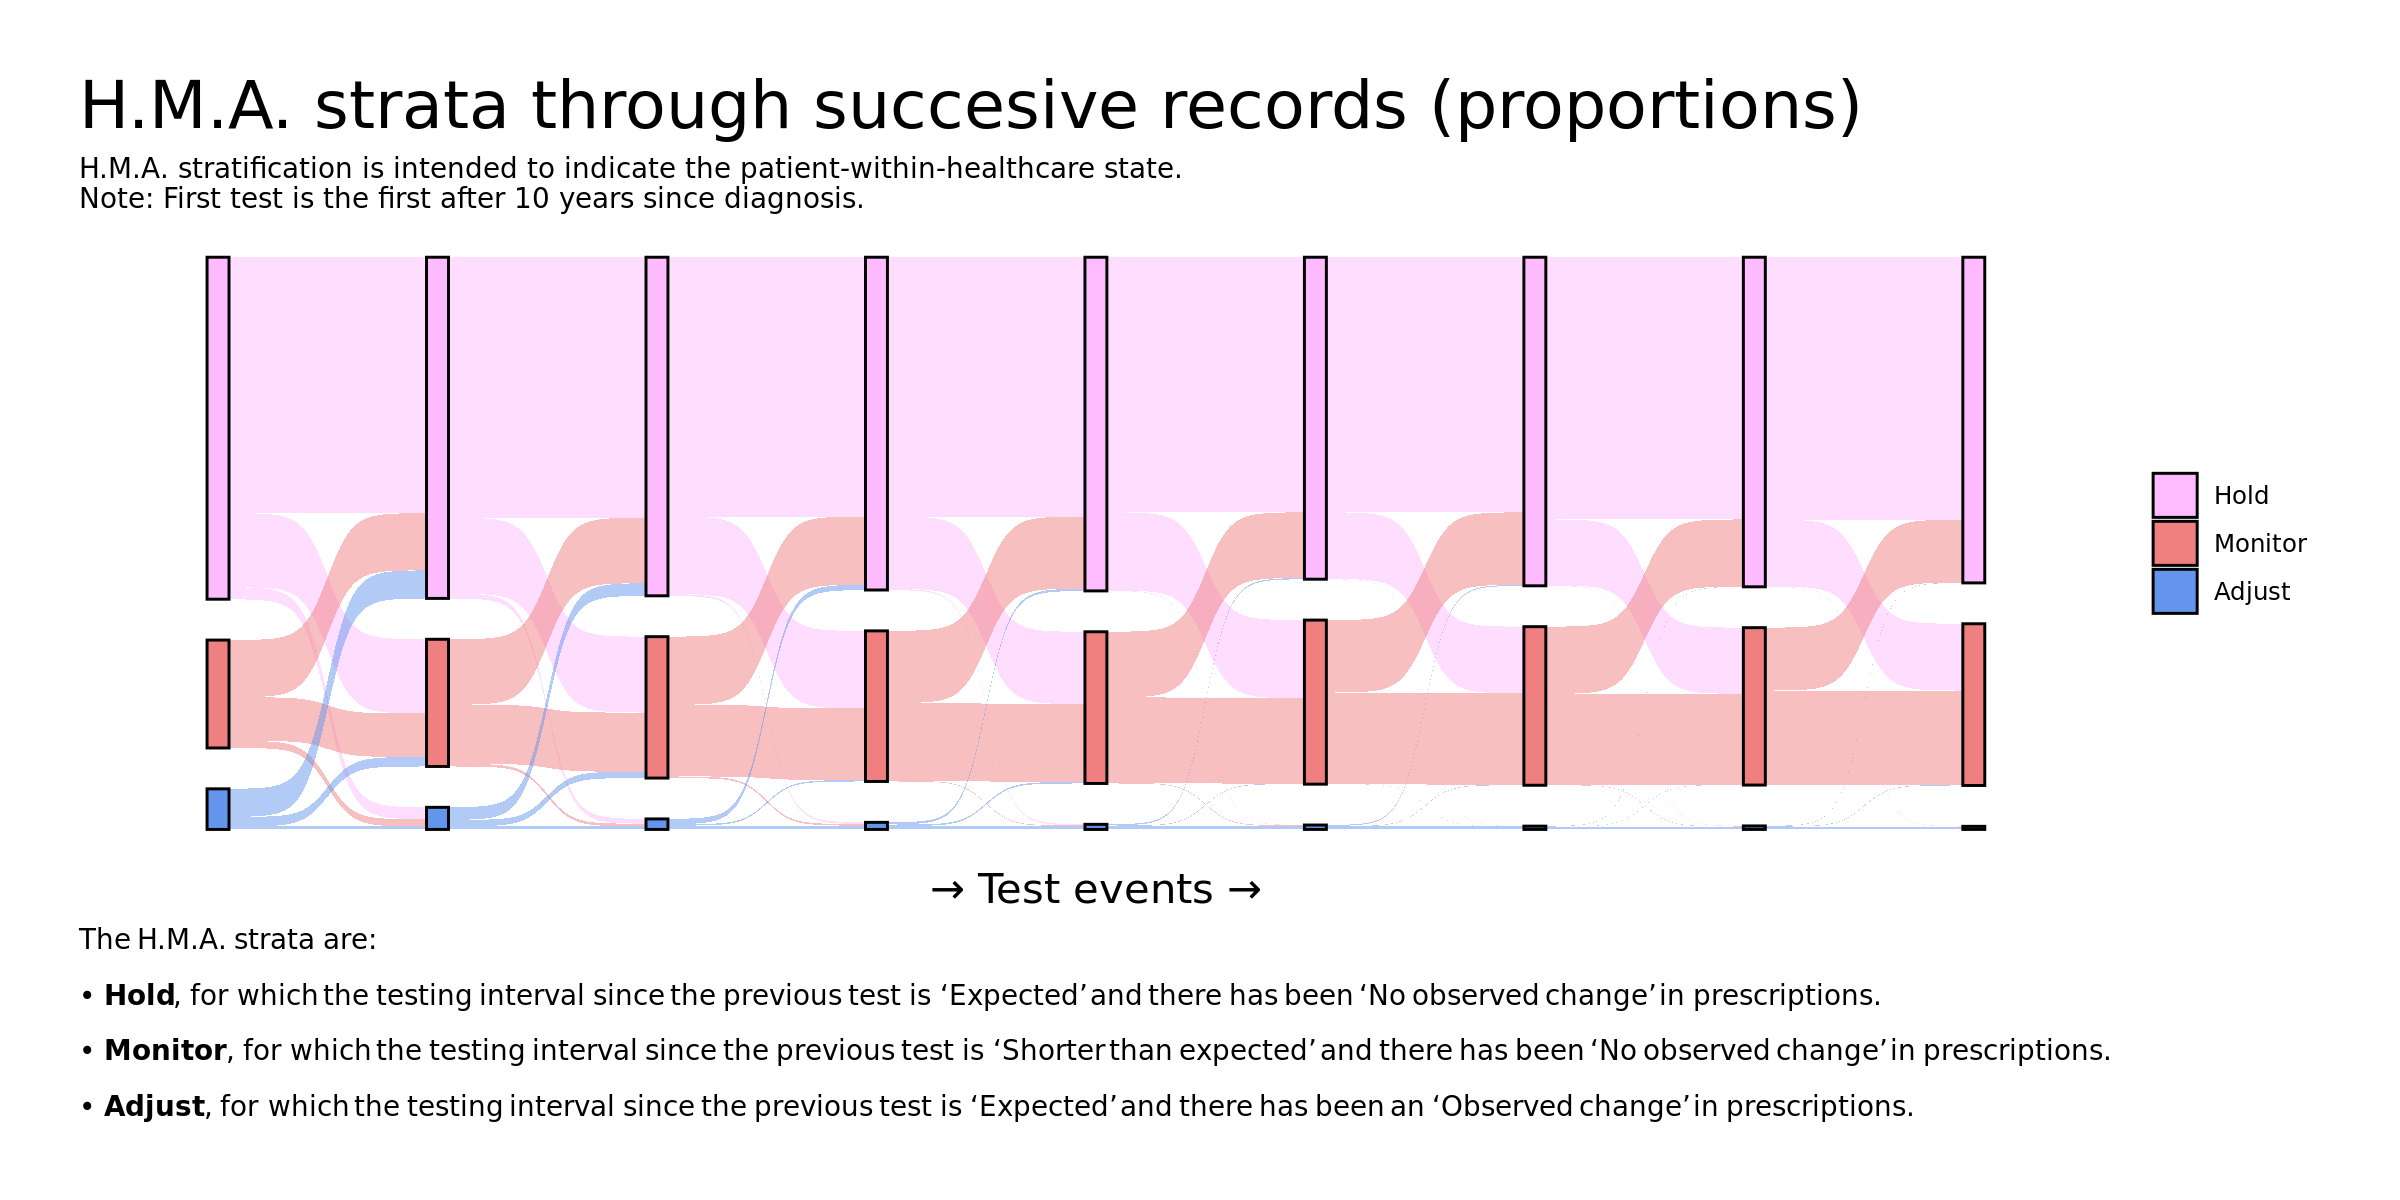

In [58]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_HMA_excludingUnobserved %>%
            dplyr::select( - last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_HMA_factor %>% dplyr::distinct( HMA_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()

        # Plot.
        options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

        plot_HMA_Sankey_excludingUnobserved <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            geom_sankey( flow.alpha = 0.5, node.color = 1) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull() ) +
            labs(
                title = "H.M.A. strata through succesive records (proportions)"
                ,subtitle = paste0(
                    "H.M.A. stratification is intended to indicate the patient-within-healthcare state."
                    ,paste0("\nNote: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                )
                ,x = "\u2192 Test events \u2192"
                ,caption = paste0(
                    "The H.M.A. strata are:<br><br>"
                    ,"\u2022 **Hold**, for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.<br><br>"
                    ,"\u2022 **Monitor**, for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.<br><br>"
                    ,"\u2022 **Adjust**, for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
                    )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,axis.text.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                ,legend.title = element_blank()
                )

        plot_HMA_Sankey_excludingUnobserved
    }

Some initial observations from the H.M.A. Sankey diagram:
1. __Most patient records indicate a 'Hold' strategy at first, but the 'Monitor' strategy prevails for those records that are longer.__
    - Evidenced by the 'Hold' vertical bars being the largest, initially, but the 'Monitor' vertical bars being largest, at the end.
2. __Very few patient records indicate the undesirable category of 'Adjust'.__
    - Evidenced by the barely visible vertical bars that represent the counts of patients in the 'Adjust' state.
3. __Unlike the previous iteration where we looked at sequences from diagosis, these sequences from 10 years after diagnosis show an unchanging probability of changing HMA-status values between tests.__
    - Evidenced by a consistent size of ribbons joining different colours, as we move from left to right in the graphic.

In the meeting of the wider project team at the end of the previous iteration, there was a request to view how individual records progress between the strata of the variable (a.k.a. the lanes) and across the events. The plot below shows the progression of a randomly-selected group of records. The random selection is taken every time the plot is rendered, and the count of records being selected can be set with the `n_records_to_sample` pareameter at the start of the code block. Note that he veritcal 'jitter' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences.

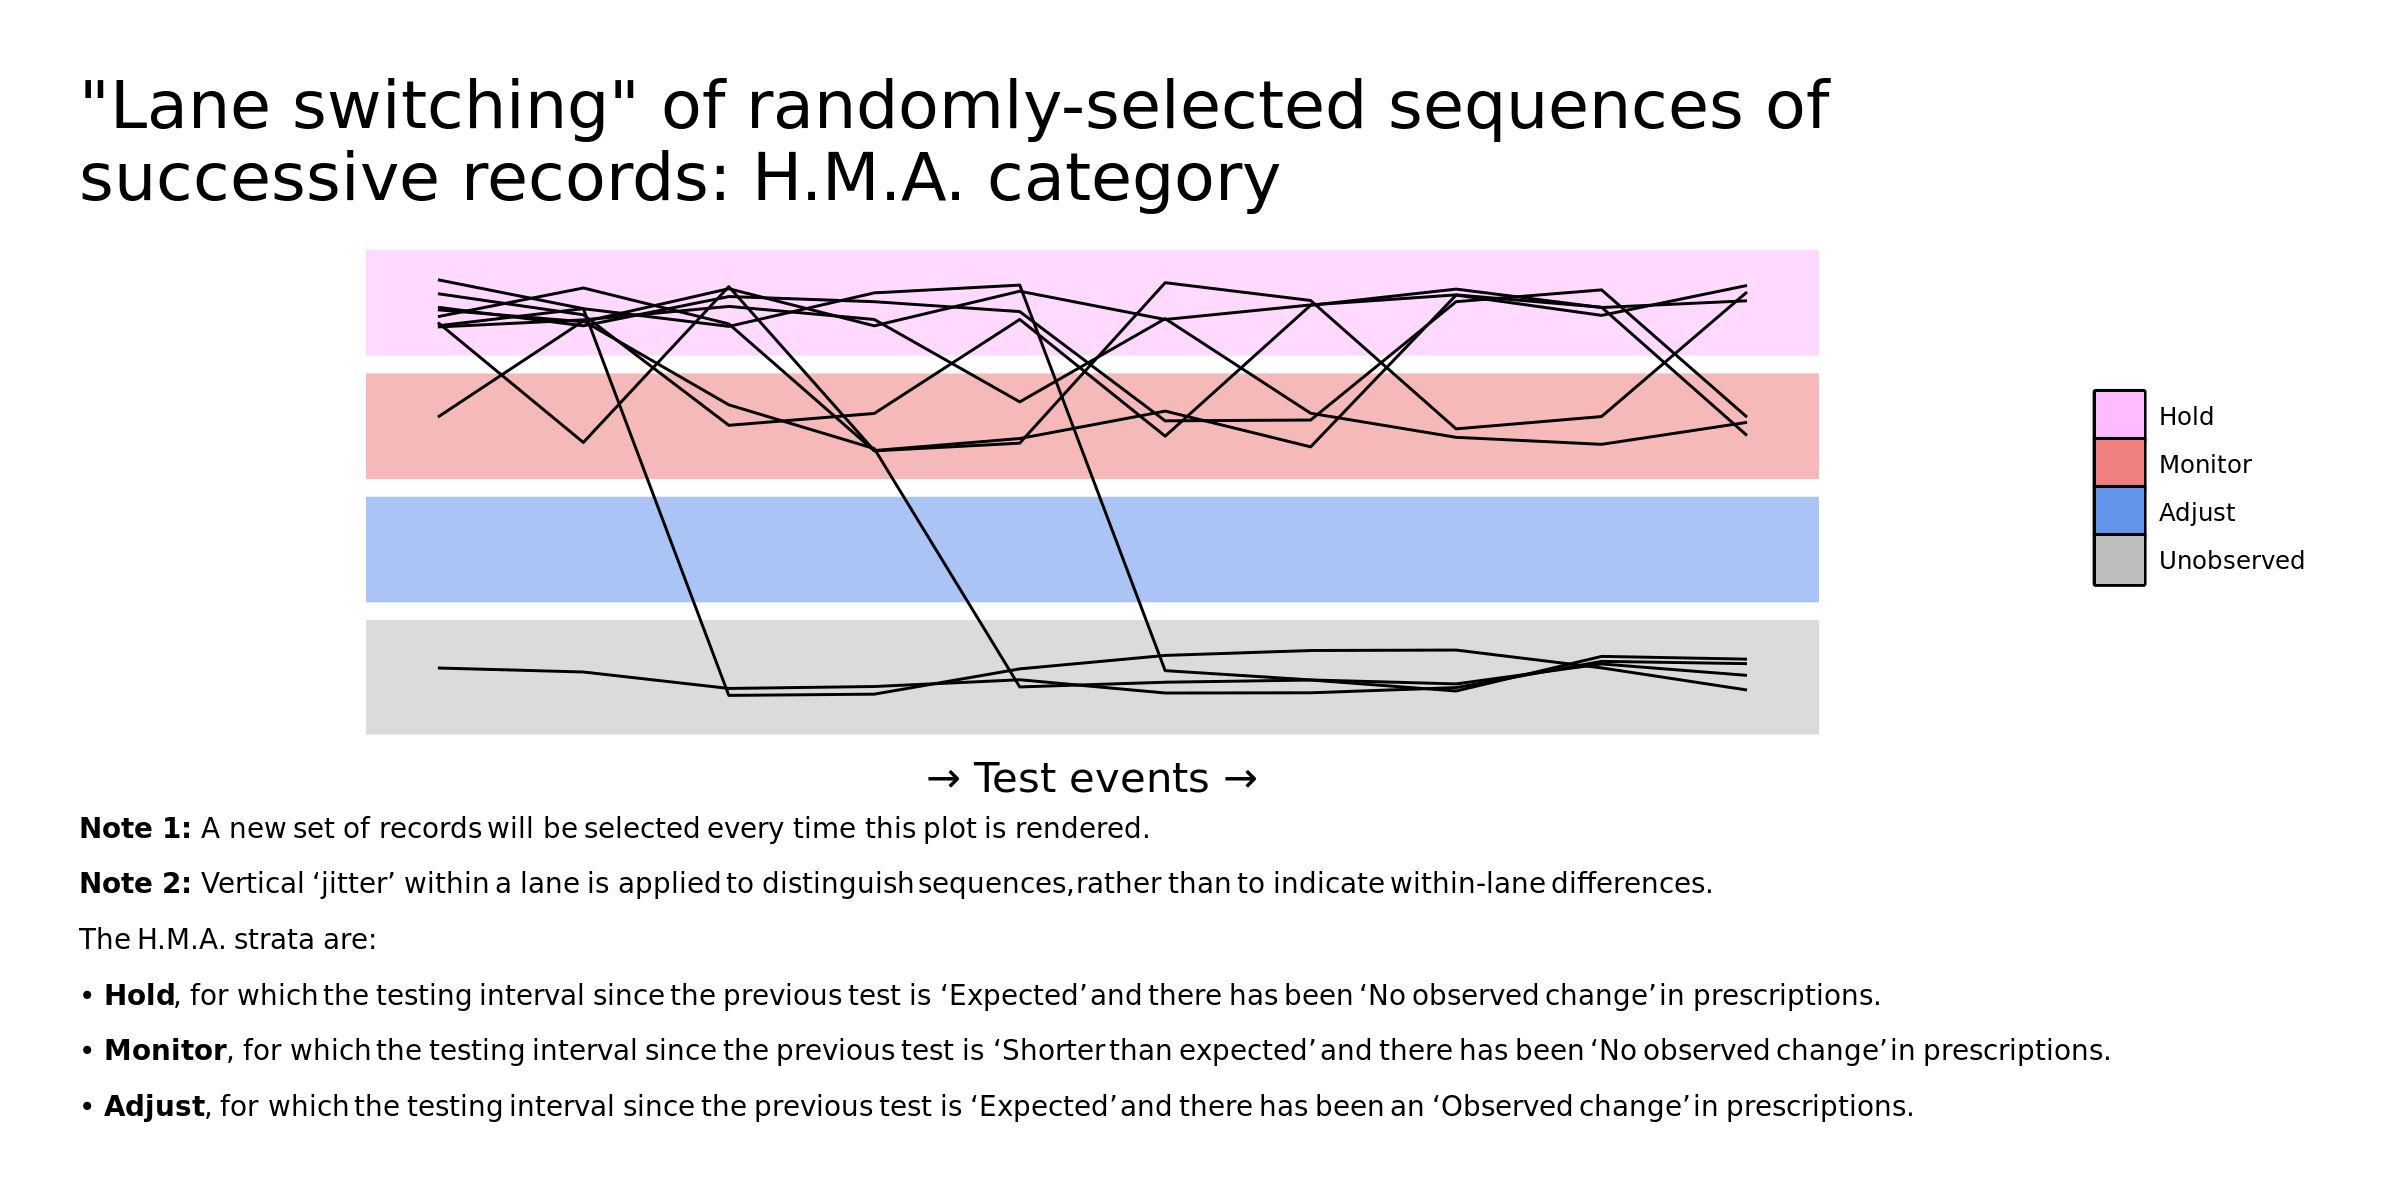

In [59]:
if ( run_laneSwitching_plots )
    {
        # Set plot parameters.
        n_records_to_sample <- 10

        # Make plot data.
        data_arbitrary_record_sequences <-
            sts_seqmine_HMA %>%
            dplyr::select( - last_col() ) %>%
            dplyr::sample_n( n_records_to_sample ) %>%
            tidyr::unite( col = "seqs", sep = "-", remove = FALSE ) %>%
            dplyr::mutate( seqs = as.factor(seqs) ) %>%
            tidyr::pivot_longer( cols = !seqs, names_to = "variable" )  %>%
            dplyr::mutate( variable = stringr::str_replace( variable, "a", "" ) %>% as.integer() )

        data_strata_lanes <-
            df_HMA_factor %>%
            dplyr::select( HMA_fct_order ) %>%
            rep( times = data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% nrow() ) %>%
            as.data.frame() %>%
            `colnames<-`( data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% dplyr::pull() ) %>%
            tidyr::pivot_longer( cols = everything(), names_to = "variable" ) %>%
            dplyr::mutate( variable = stringr::str_replace( variable, "a", "" ) %>% as.integer() )

        # Plot
        options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

        plot_laneSwitching_HMA <-
            ggplot() +
            # ## Plot the ribbons / lanes for each stratum.
            geom_raster(
                data = data_strata_lanes
                ,aes(
                    x = variable
                    ,y = value %>% factor( ., levels = rev( levels( . ) ) )
                    ,fill = value
                    ,alpha = 0.5
                )
            ) +
            # ## Plot a white line segment to separate the groups.
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 1.5, yend = 1.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 2.5, yend = 2.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 3.5, yend = 3.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 4.5, yend = 4.5, linewidth = 3, colour = "white" ) +
            # ## Plot the randomly-selected sequences as lines.
            geom_path(
                data = data_arbitrary_record_sequences %>% dplyr::mutate( grp =  rep(1:n_records_to_sample, each = n_iterations ) )
                ,aes(
                    x = variable
                    ,y = value
                    ,group = grp
                )
                ,position = position_jitter( width = 0, height = 0.2 )
            ) +
            # ## Format the plot.
            scale_fill_manual(
                values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
            ) +
            scale_alpha(guide = 'none') +
            labs(
                title = stringr::str_wrap( "\"Lane switching\" of randomly-selected sequences of successive records: H.M.A. category", width = 60 )
                ,x = "\u2192 Test events \u2192"
                ,caption = 
                    paste0(
                        "**Note 1:** A new set of records will be selected every time this plot is rendered.<br><br>"
                        ,"**Note 2:** Vertical \'jitter\' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences.<br><br>"
                        ,"The H.M.A. strata are:<br><br>"
                        ,"\u2022 **Hold**, for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.<br><br>"
                        ,"\u2022 **Monitor**, for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.<br><br>"
                        ,"\u2022 **Adjust**, for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
                    )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,axis.title = element_text( size = 15 )
                ,plot.title.position = 'plot'
                ,legend.title = element_blank()
                ,legend.box.margin = margin( t = 1, r = 1, l = 2, b = 1, unit =  "cm")
                ,legend.key = element_rect( colour = 'black', linewidth = 1 )
                ,plot.margin = margin( t = 1, r = 0, l = 1, b = 1, unit =  "cm")
                ,axis.text.x = element_blank()
                ,axis.text.y = element_text( colour = 'white', size = 12)
                ,axis.title.y = element_blank()
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()

                )

        plot_laneSwitching_HMA
}

In [60]:
if ( run_laneSwitching_plots )
    {
        TraMineR::seqtab( sts_seqmine_HMA ) %>%
        attributes() %>%
        purrr::pluck( "freq" ) %>%
        tibble::rownames_to_column( "sequence" ) %>%
        dplyr::arrange( desc( Freq ) ) %>%
        dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
        # Remove the leading "None/[0-9]"
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
            ) %>%
        # Replace the "-" that joins the events with an arrow.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
            ) %>%
        # Use words instead of symbols for the number of timesteps.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
            ) %>%
        # Repalce "Unobserved for [0-9]*" with "End".
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
            ) %>%
        suppressWarnings()
    }

sequence                                      Freq Percent   
1  END                                           546  10.0165107
2  Hold for 10 → END                             280   5.1366722
3  Hold for 2 → END                              140   2.5683361
4  Hold for 3 → END                              107   1.9629426
5  Hold for 4 → END                               74   1.3575491
6  Hold for 5 → END                               69   1.2658228
7  Hold for 9 → Monitor for 1 → END               59   1.0823702
8  Hold for 7 → Monitor for 1 → Hold for 2 → END  50   0.9172629
9  Hold for 8 → Monitor for 1 → Hold for 1 → END  48   0.8805724
10 Hold for 3 → Monitor for 1 → Hold for 6 → END  45   0.8255366
   cum_sum_percent
1  10.01651       
2  15.15318       
3  17.72152       
4  19.68446       
5  21.04201       
6  22.30783       
7  23.39020       
8  24.30747       
9  25.18804       
10 26.01358

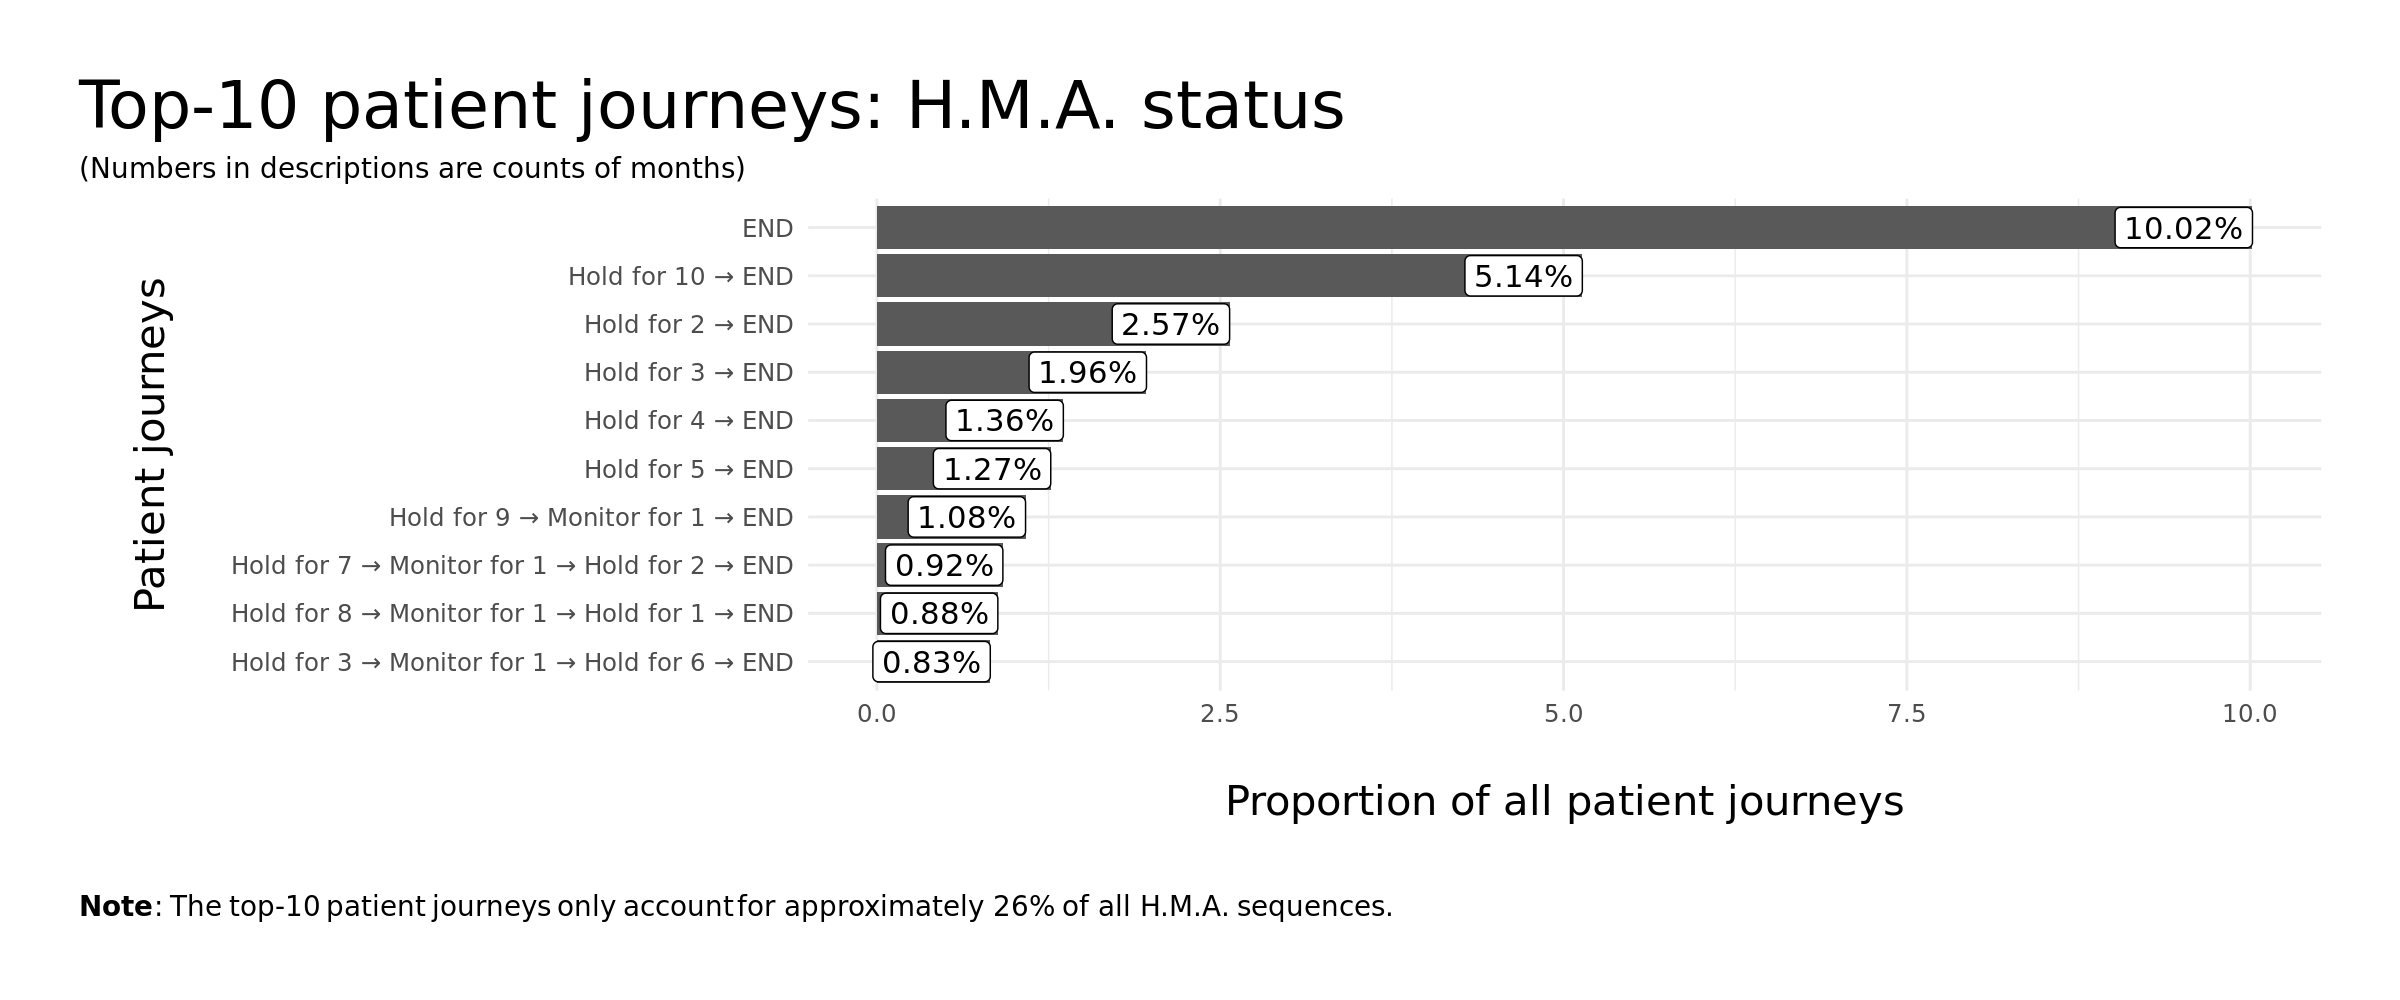

In [61]:
if ( run_process_mining_summary )
    {
        options( repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200 )

        # Make plot data.
        plot_data <-
            TraMineR::seqtab( sts_seqmine_HMA ) %>%
            attributes() %>%
            purrr::pluck( "freq" ) %>%
            tibble::rownames_to_column( "sequence" ) %>%
            dplyr::arrange( desc( Freq ) ) %>%
            dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
            # Remove the leading "None/[0-9]"
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
                ) %>%
            # Replace the "-" that joins the events with an arrow.
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
                ) %>%
            # Use words instead of symbols for the number of timesteps.
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
                ) %>%
            # Repalce "Unobserved for [0-9]*" with "End".
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
                ) %>%
            suppressWarnings()


        # Plot plot data.
        plot_data %>%
            ggplot(
                aes(
                    x = reorder( sequence, Freq )
                    ,y = Percent )
                , stat = "identity"
            ) +
            geom_col() +
            geom_label(
                    aes(
                        label = Percent %>% `/`(100) %>% round(4) %>% scales::percent()
                    )
                    ,hjust = 1 ) +
            coord_flip() +
            labs(
                x = "Patient journeys"
                ,y = "Proportion of all patient journeys"
                ,title = "Top-10 patient journeys: H.M.A. status"
                ,subtitle = "(Numbers in descriptions are counts of months)"
                ,caption = paste0(
                    "**Note**: The top-10 patient journeys only account for approximately "
                    ,round( max( plot_data$cum_sum_percent ))
                           ,"% of all H.M.A. sequences."
                          )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = "none"
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.x = element_text( margin = margin( t = 20, b = 20 ) )
                ,axis.title.y = element_text( margin = margin( r = 20, l = 20, t = 20 ) )
                )
    }

#### H.M.A. and Test Status strata

In the next plot, the Sankey plot visualises the proportions of patient records moving through test statues and H.M.A. category.

The first task is to create a new state-sequence object that tracks `HMAandTestStatus` strata.

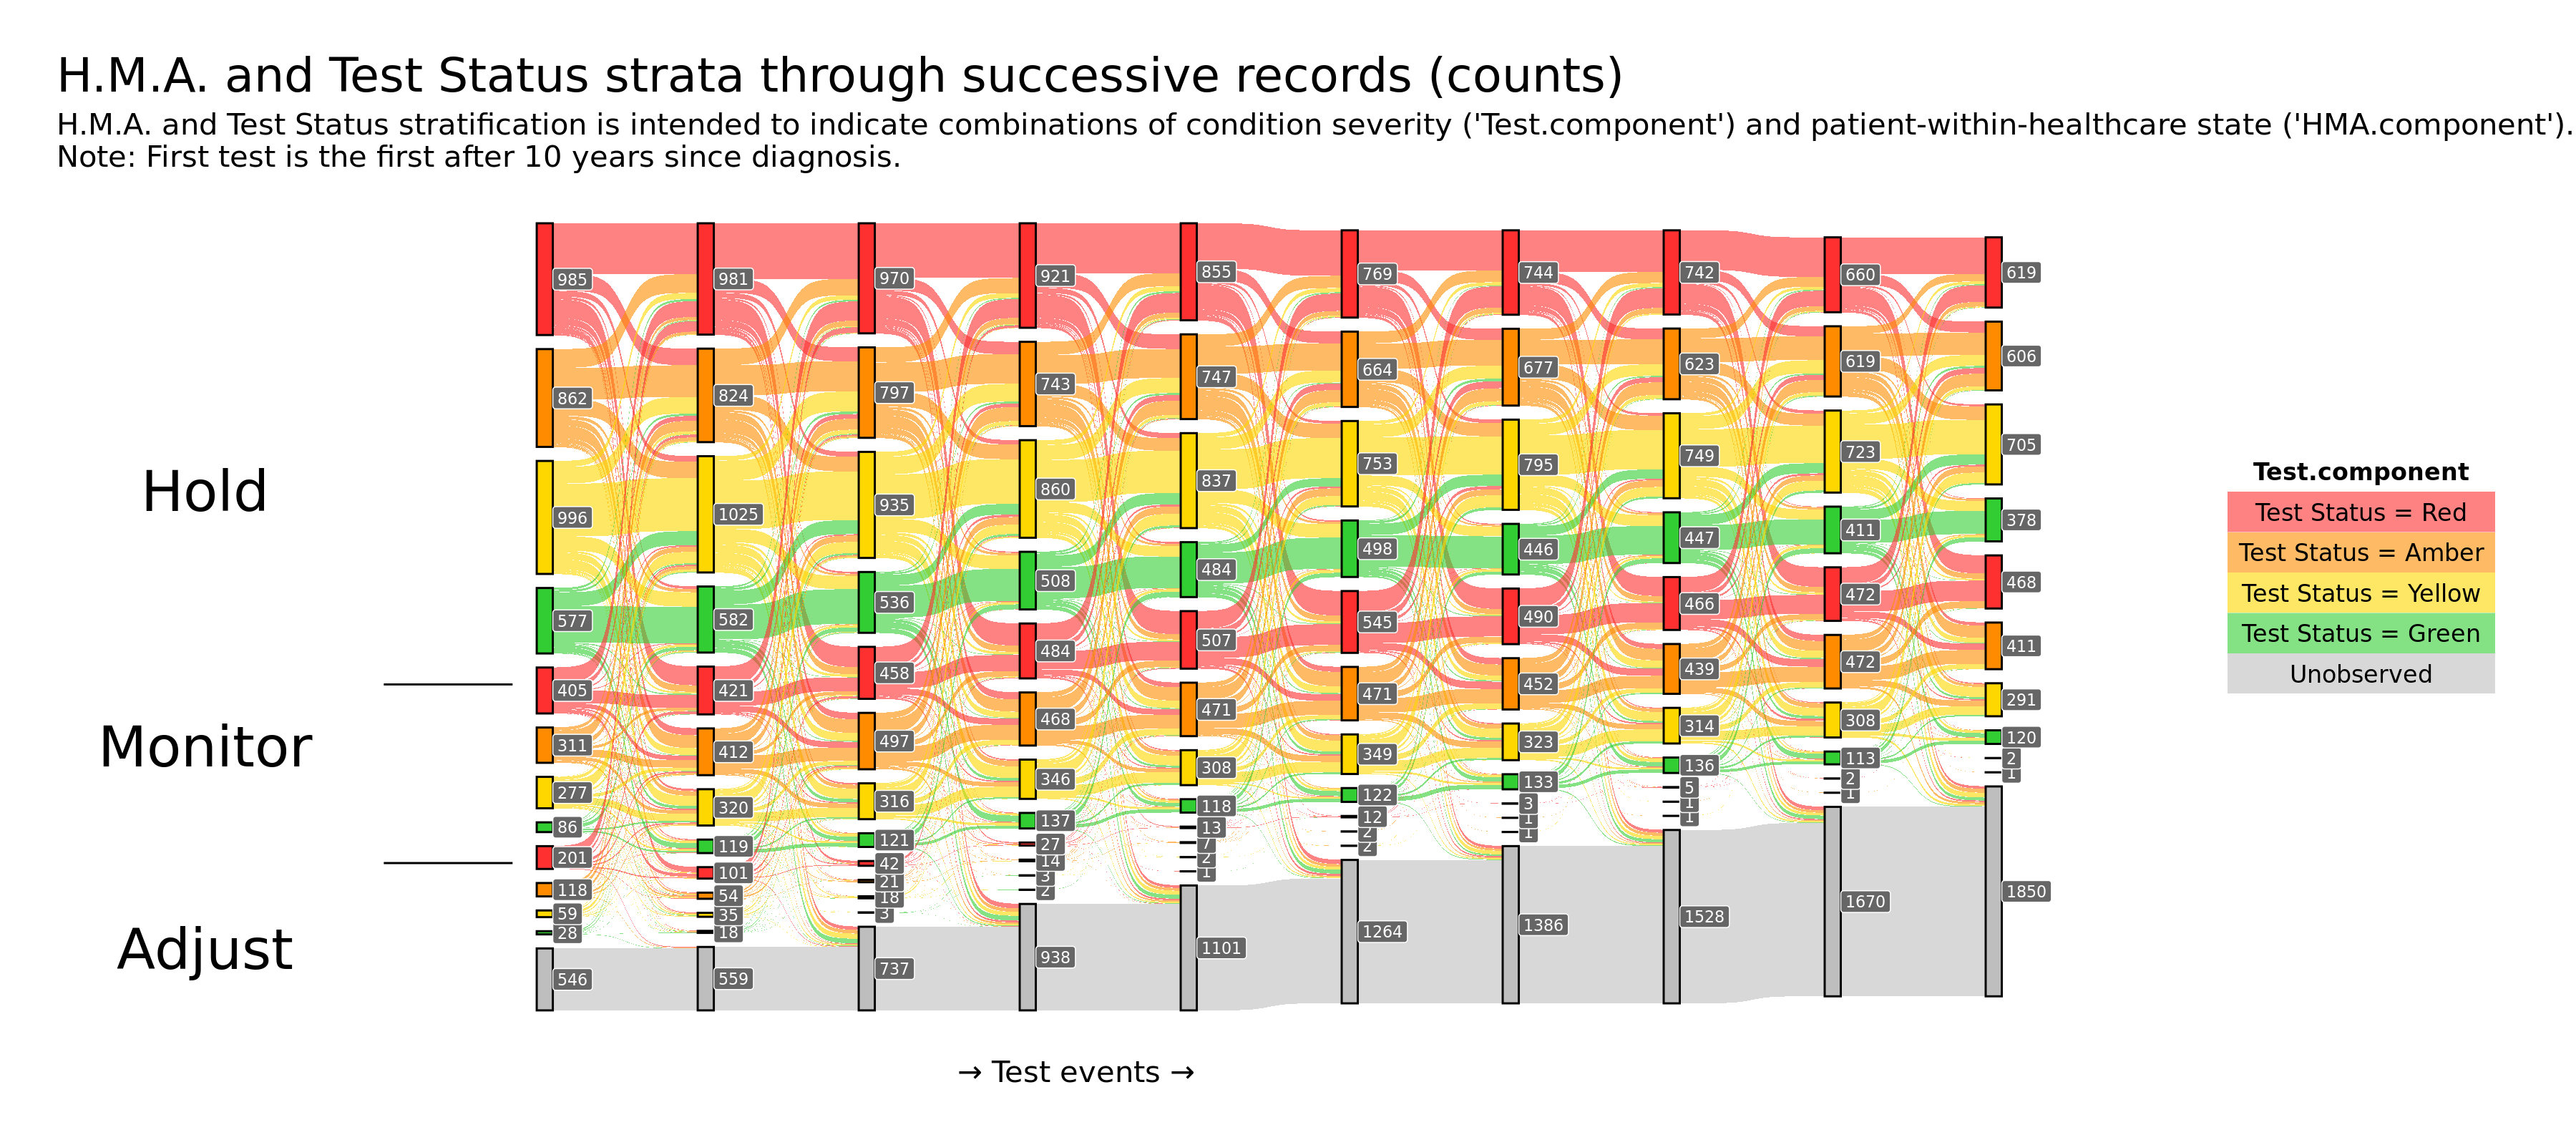

In [62]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_HMAandTestStatus %>%
            # Remove the default start node.
            dplyr::select( - last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()
    
        # Calculate where to place the line segment that divides the H.M.A. categories.
        default_space <-
            plotData %>%
            dplyr::mutate( group = 1 ) %>%
            dplyr::select( - next_x, - next_node, - next_x) %>%
            dplyr::group_by_all() %>%
            dplyr::summarise(freq = dplyr::n(), .groups = "keep") %>%
            dplyr::ungroup() %>%
            # The follow is adapted from ggsankey:::find_default_space().
            dplyr::group_by(x) %>%
            dplyr::summarise(n_groups = dplyr::n_distinct(node),
                      freq = sum(freq, na.rm = TRUE)) %>%
            dplyr::mutate(v = freq / n_groups / 4) %>%
            dplyr::pull(v) %>%
            max()
        n_patients_Hold_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a2, pattern = "Hold" ) ) %>% nrow()
        n_patients_Monitor_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a2, pattern = "Monitor" ) ) %>% nrow()
        n_patients_Adjust_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a2, pattern = "Adjust" ) ) %>% nrow()
        n_patients_Unobserved_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a2, pattern = "Unobserved" ) ) %>% nrow()
        n_patients_half <- sum( n_patients_Hold_at_start, n_patients_Monitor_at_start, n_patients_Adjust_at_start ) / 2
        segment_Adjust <- n_patients_Adjust_at_start - n_patients_half - default_space
        segment_Monitor <- segment_Adjust + n_patients_Monitor_at_start + ( 4 * default_space )

        # Make plot graphic.
        plot_sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            # Plot Sankey.
            geom_sankey(
                flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
                ,node.color = 1
                #,space = 33
            ) +
            # Annotate the left side of the plot with labels.
            annotate("segment", x = 0, xend = 0.8, y = segment_Monitor, yend = segment_Monitor ) +
            annotate("segment", x = 0, xend = 0.8, y = segment_Adjust, yend = segment_Adjust ) +
            annotate("text", x = -2, y = segment_Monitor + ( n_patients_Hold_at_start / 2 ), label = "\t\tHold", size = 10 ) +
            annotate("text", x = -2, y = segment_Monitor - ( n_patients_Monitor_at_start / 2 ), label = "\t\tMonitor", size = 10 ) +
            annotate("text", x = -2, y = segment_Adjust - ( n_patients_Adjust_at_start / 2 ) - n_patients_Unobserved_at_start, label = "\t\tAdjust", size = 10 ) +
            # Overlay count labels.
            geom_sankey_label(
                aes(
                  x = as.numeric(x) + .05,
                  label = after_stat(paste0(freq))
                ),
                size = 8 / .pt, color = "white", fill = "gray40",
                hjust = 0
              ) +
            labs(
                title = "H.M.A. and Test Status strata through successive records (counts)"
                ,subtitle =
                    paste0(
                        "H.M.A. and Test Status stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and patient-within-healthcare state (\'HMA.component\').\n"
                        ,paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
            # Finish theme.
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = 'none'
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Make table explaining the strata.
        plot_table <-
            HMAandTestStatus_display_table %>%
            dplyr::select( Test.component ) %>%
            dplyr::slice_tail( n = 5 ) %>%
            # Basic table layout.
            gridExtra::tableGrob(
                rows = NULL
                ,theme = 
                ttheme_minimal(
                    core = list(
                        bg_params = list( fill = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::slice_tail( n = 5 ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
                    )
                )
            )           

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

        plot_HMAandTestStatus_Sankey <-
            cowplot::plot_grid(
                plot_sankey, plot_table
                ,nrow = 1
                ,rel_widths = c( 5/6, 1/6 )
            )

        plot_HMAandTestStatus_Sankey
    }

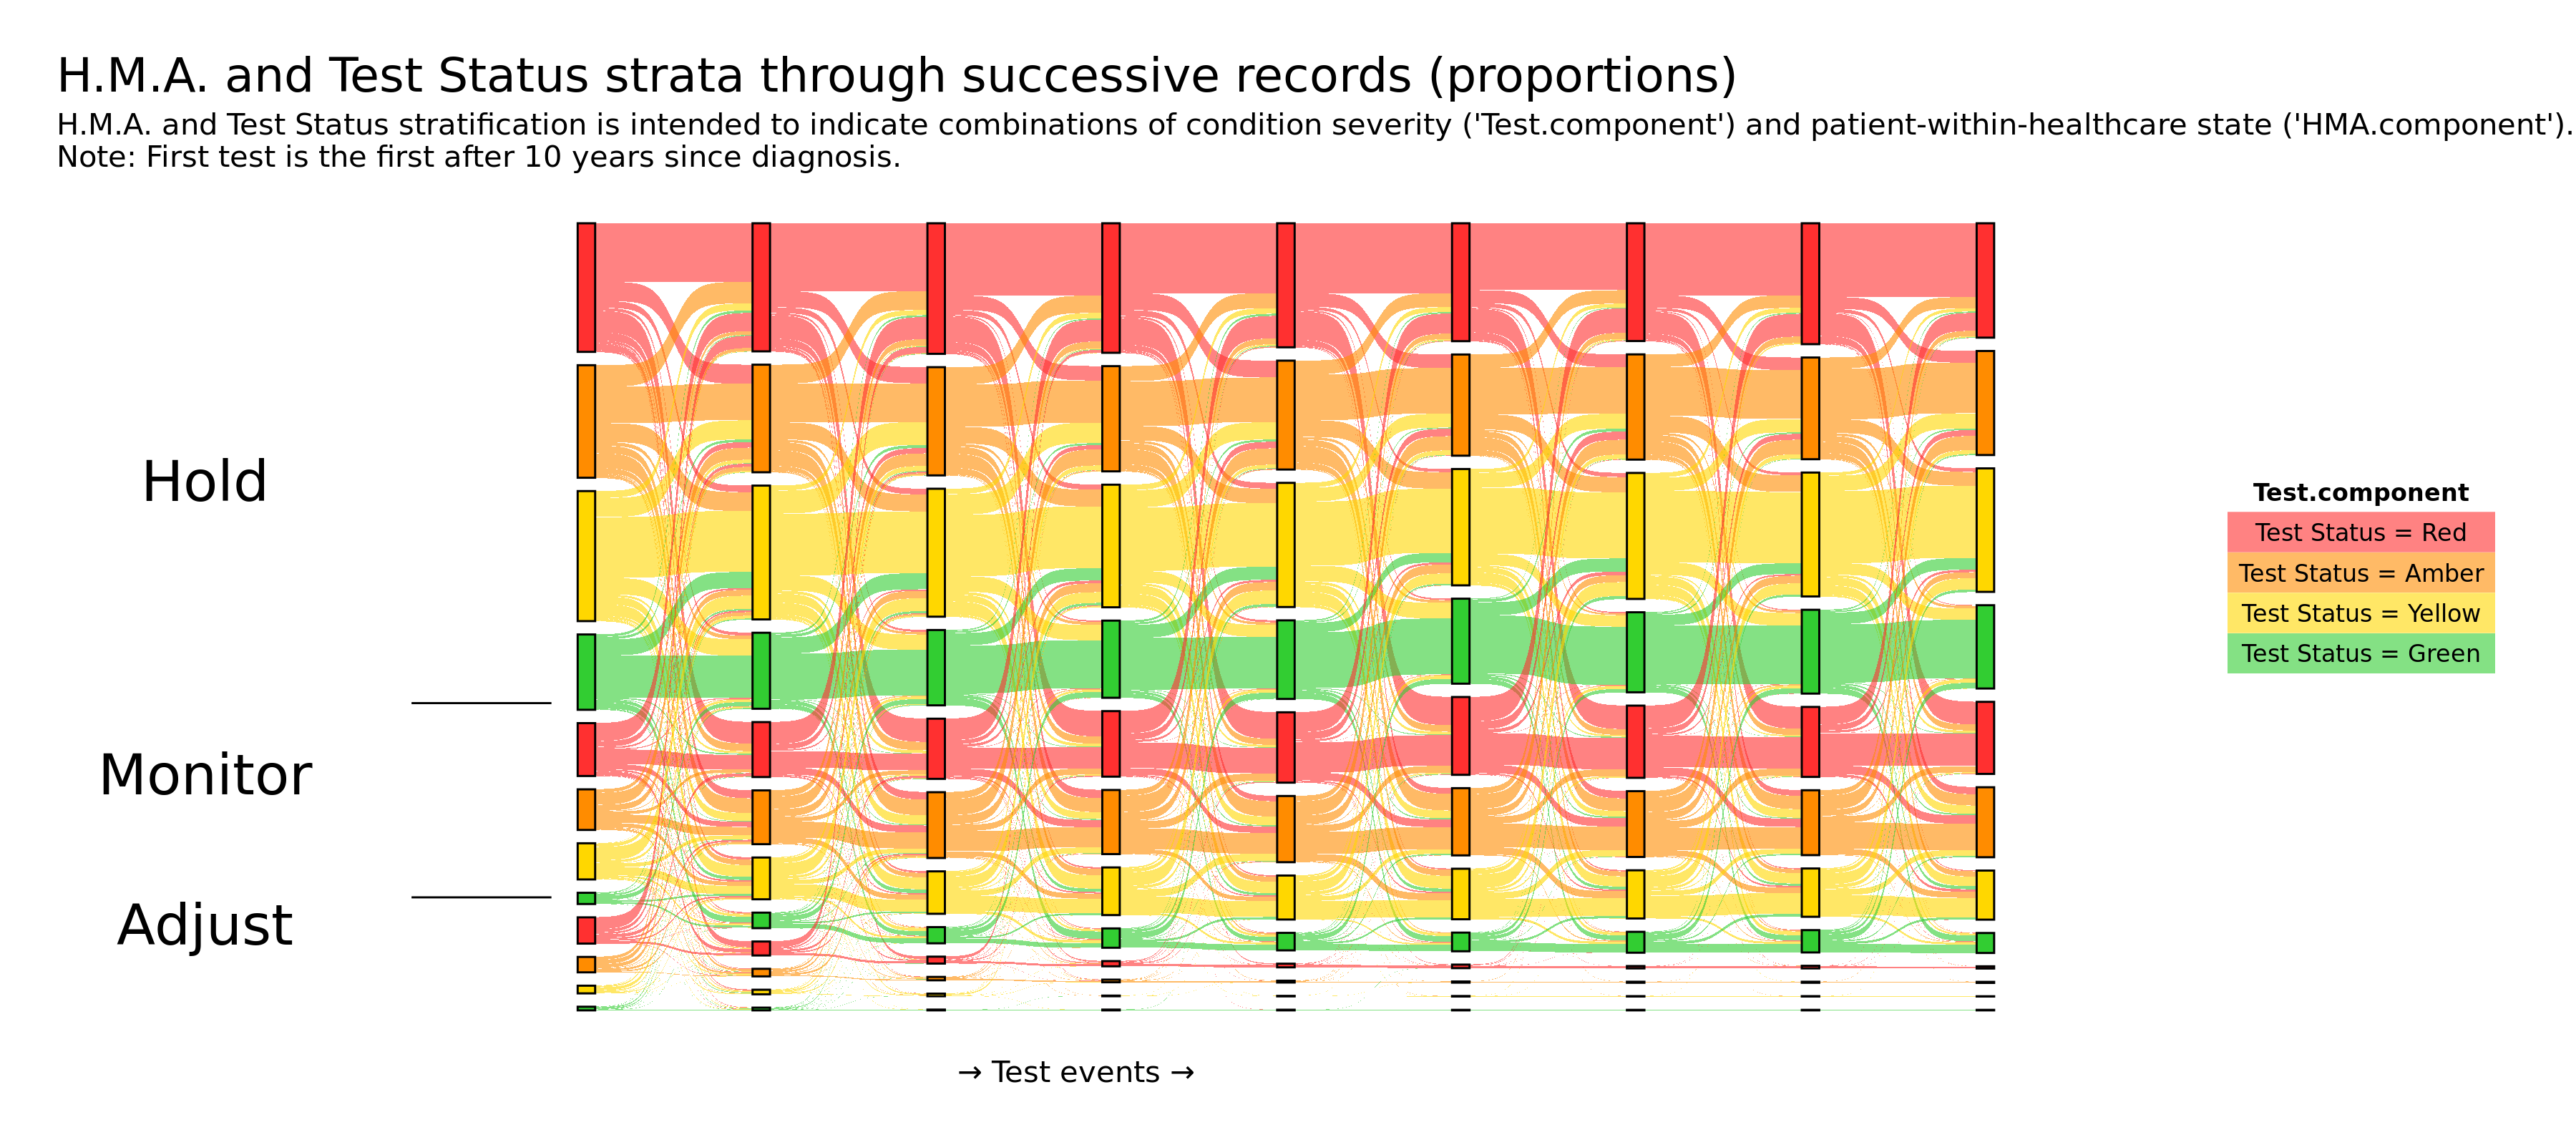

In [63]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_HMAandTestStatus_excludingUnobserved %>%
            # Remove the default start node.
            dplyr::select( - last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()
    
        # Calculate where to place the line segment that divides the H.M.A. categories.
        default_space <-
            plotData %>%
            dplyr::mutate(group = 1) %>%
            dplyr::select(-next_x, -next_node, -next_x) %>%
            dplyr::group_by_all() %>%
            dplyr::summarise(freq = dplyr::n(), .groups = "keep") %>%
            dplyr::ungroup() %>%
            # The follow is adapted from ggsankey:::find_default_space().
            dplyr::group_by(x) %>%
            dplyr::summarise(n_groups = dplyr::n_distinct(node),
                      freq = sum(freq, na.rm = TRUE)) %>%
            dplyr::mutate(v = freq / n_groups / 4) %>%
            dplyr::pull(v) %>%
            max()
        n_patients_Hold_at_start <- sts_seqmine_HMAandTestStatus_excludingUnobserved %>% dplyr::filter( stringr::str_detect( a2, pattern = "Hold" ) ) %>% nrow()
        n_patients_Monitor_at_start <- sts_seqmine_HMAandTestStatus_excludingUnobserved %>% dplyr::filter( stringr::str_detect( a2, pattern = "Monitor" ) ) %>% nrow()
        n_patients_Adjust_at_start <- sts_seqmine_HMAandTestStatus_excludingUnobserved %>% dplyr::filter( stringr::str_detect( a2, pattern = "Adjust" ) ) %>% nrow()
        n_patients_half <- sum( n_patients_Hold_at_start, n_patients_Monitor_at_start, n_patients_Adjust_at_start ) / 2
        segment_Adjust <- n_patients_Adjust_at_start - n_patients_half - default_space
        segment_Monitor <- segment_Adjust + n_patients_Monitor_at_start + ( 4 * default_space )

        # Make plot graphic.
        plot_sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            # Plot Sankey.
            geom_sankey(
                flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
                ,node.color = 1
                #,space = 33
            ) +
            # Annotate the left side of the plot with labels.
            annotate("segment", x = 0, xend = 0.8, y = segment_Monitor, yend = segment_Monitor ) +
            annotate("segment", x = 0, xend = 0.8, y = segment_Adjust, yend = segment_Adjust ) +
            annotate("text", x = -2, y = segment_Monitor + ( n_patients_Hold_at_start / 2 ), label = "\t\tHold", size = 10 ) +
            annotate("text", x = -2, y = segment_Monitor - ( n_patients_Monitor_at_start / 2 ), label = "\t\tMonitor", size = 10 ) +
            annotate("text", x = -2, y = segment_Adjust - ( n_patients_Adjust_at_start / 2 ), label = "\t\tAdjust", size = 10 ) +
            labs(
                title = "H.M.A. and Test Status strata through successive records (proportions)"
                ,subtitle =
                    paste0(
                        "H.M.A. and Test Status stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and patient-within-healthcare state (\'HMA.component\').\n"
                       ,paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
            # Finish theme.
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = 'none'
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Make table explaining the strata.
        plot_table_excludingUnobserved <-
            HMAandTestStatus_display_table %>%
            dplyr::filter( Test.component != "Unobserved" ) %>%
            dplyr::select( Test.component ) %>%
            dplyr::slice_head( n = 4 ) %>%
            # Basic table layout.
            gridExtra::tableGrob(
                rows = NULL
                ,theme = 
                ttheme_minimal(
                    core = list(
                        bg_params = list( fill = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::slice_head( n = 4 ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
                    )
                )
            )           

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

        plot_HMAandTestStatus_Sankey_excludingUnobserved <-
            cowplot::plot_grid(
                plot_sankey, plot_table_excludingUnobserved
                ,nrow = 1
                ,rel_widths = c( 5/6, 1/6 )
            )

        plot_HMAandTestStatus_Sankey_excludingUnobserved
    }

Some initial observations from the H.M.A. and Test Status Sankey diagram:
1. __Most patient records indicating 'Hold' or 'Monitor' have a Yellow test status.__
    - Evidenced by the largest bars in the 'Hold' and 'Monitor' states being yelloe, throughout.
2. __Very few patient records indicate the undesirable category of 'Adjust'.__
    - Evidenced by the barely visible vertical bars that represent the counts of patients in the 'Adjust' state.
3. __Unlike the previous iteration where we looked at sequences from diagosis, these sequences from 10 years after diagnosis show an unchanging probability of changing test-status values between tests.__
    - Evidenced by a consistent size of ribbons joining different colours, as we move from left to right in the graphic.

In [64]:
if ( run_laneSwitching_plots )
    {
        # Set plot parameters.
        n_records_to_sample <- 10

        # Make plot data.
        data_arbitrary_record_sequences <-
            sts_seqmine_HMAandTestStatus %>%
            dplyr::select( - c( a2, last_col() ) ) %>%
            dplyr::sample_n( n_records_to_sample ) %>%
            tidyr::unite(
                col = "seqs"
                , sep = "-"
                ,remove = FALSE
                ) %>%
            dplyr::mutate_at(
                .vars = vars( seqs )
                ,.funs = funs( as.factor(.) )
            ) %>%
            tidyr::pivot_longer(
                cols = !seqs
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        data_strata_lanes <-
            df_HMAandTestStatus_factor %>%
            dplyr::select( HMAandTestStatus_fct_order ) %>%
            rep( times = data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% nrow() ) %>%
            as.data.frame() %>%
            `colnames<-`( data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% dplyr::pull() ) %>%
            tidyr::pivot_longer(
                cols = everything()
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        # Make plot graphic.
        plot_laneSwitching <-
            ggplot() +
            # ## Plot the ribbons / lanes for each stratum.
            geom_raster(
                data = data_strata_lanes
                ,aes(
                    x = variable
                    ,y = value %>% factor( ., levels = rev( levels( . ) ) )
                    ,fill = value
                    ,alpha = 0.5
                )
            ) +
            # ## Plot a white line segment to separate the groups.
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 1.5, yend = 1.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 5.5, yend = 5.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 9.5, yend = 9.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 13.5, yend = 13.5, linewidth = 3, colour = "white" ) +
            # Annotate the left side of the plot with labels.
            annotate("text", x = 1, y = 11.5, label = "\tHold", size = 10, hjust = "center") +
            annotate("text", x = 1, y = 7.5, label = "\tMonitor", size = 10, hjust = "center") +
            annotate("text", x = 1, y = 3.5, label = "\tAdjust", size = 10, hjust = "center") +
            # ## Plot the randomly-selected sequences as lines.
            geom_path(
                data = data_arbitrary_record_sequences
                ,aes(
                    x = variable
                    ,y = value
                    ,group = seqs
                )
                ,position = position_jitter( width = 0, height = 0.2 )
            ) +
            # ## Format the plot.
            scale_fill_manual(
                values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull()
            ) +
            scale_alpha(guide = 'none') +
            labs(
                title = "\"Lane switching\" of randomly-selected sequences of successive records: H.M.A. Test Status category"
                ,subtitle =
                    paste0(
                        "\u2022 H.M.A. and Test Status stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and patient-within-healthcare\nstate (\'HMA.component\').\n"                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.title.position = 'plot'
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,legend.position = 'none'
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.text.x = element_blank()
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 9, repr.plot.res = 200 )

        plot_laneSwitching_HMAandTestStatus <-
            cowplot::plot_grid(
                plot_laneSwitching, plot_table
                ,nrow = 1
                ,rel_widths = c( 3/5, 2/5 )
            ) %>%
            cowplot::add_sub(
                label = expression( paste(~bold("Note 1:"), " A new set of records will be selected every time this plot is rendered." ) )
                ,x = 0, hjust = 0
            )  %>%
            cowplot::add_sub(
                label = expression( paste(~bold("Note 2:"), " Vertical \'jitter\' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences." ))
                ,x = 0, hjust = 0
            ) 

        plot_laneSwitching_HMAandTestStatus %>% cowplot::ggdraw()
    }

In [65]:
if ( run_laneSwitching_plots )
    {
        TraMineR::seqtab( sts_seqmine_HMAandTestStatus ) %>%
        attributes() %>%
        purrr::pluck( "freq" ) %>%
        tibble::rownames_to_column( "sequence" ) %>%
        dplyr::arrange( desc( Freq ) ) %>%
        dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
        # Remove the leading "None/[0-9]"
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
            ) %>%
        # Replace the "-" that joins the events with an arrow.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
            ) %>%
        # Use words instead of symbols for the number of timesteps.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
            ) %>%
        # Repalce "Unobserved for [0-9]*" with "End".
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
            ) %>%
        suppressWarnings()
    }

sequence                                   Freq Percent    cum_sum_percent
1  END                                        546  10.0165107 10.01651       
2  Hold Green for 10 → END                     32   0.5870482 10.60356       
3  Hold Green for 2 → END                      26   0.4769767 11.08054       
4  Hold Yellow for 2 → END                     23   0.4219409 11.50248       
5  Hold Green for 3 → END                      20   0.3669052 11.86938       
6  Hold Amber for 2 → END                      15   0.2751789 12.14456       
7  Hold Red for 2 → END                        13   0.2384884 12.38305       
8  Hold Yellow for 1 → Hold Green for 1 → END  12   0.2201431 12.60319       
9  Hold Green for 5 → END                      10   0.1834526 12.78664       
10 Hold Red for 3 → END                        10   0.1834526 12.97010

#### T-and-I strata

In the next plot, the Sankey plot visualises the proportions of patient records moving between strata of the T-and-I stratification.

The T-and-I stratification is something CB proposed. It has 17 strata derived from combining the test status, T, {Test status = Red, Test status = Amber, Test status = Yellow, Test status = Green} with a variable indicating the count of unique medications prescribed in previous inter-test intervals, P, {0, 1, 2, 3}, i.e. poly-pharmacy. One additional strata is designated for where errors arise in the data.

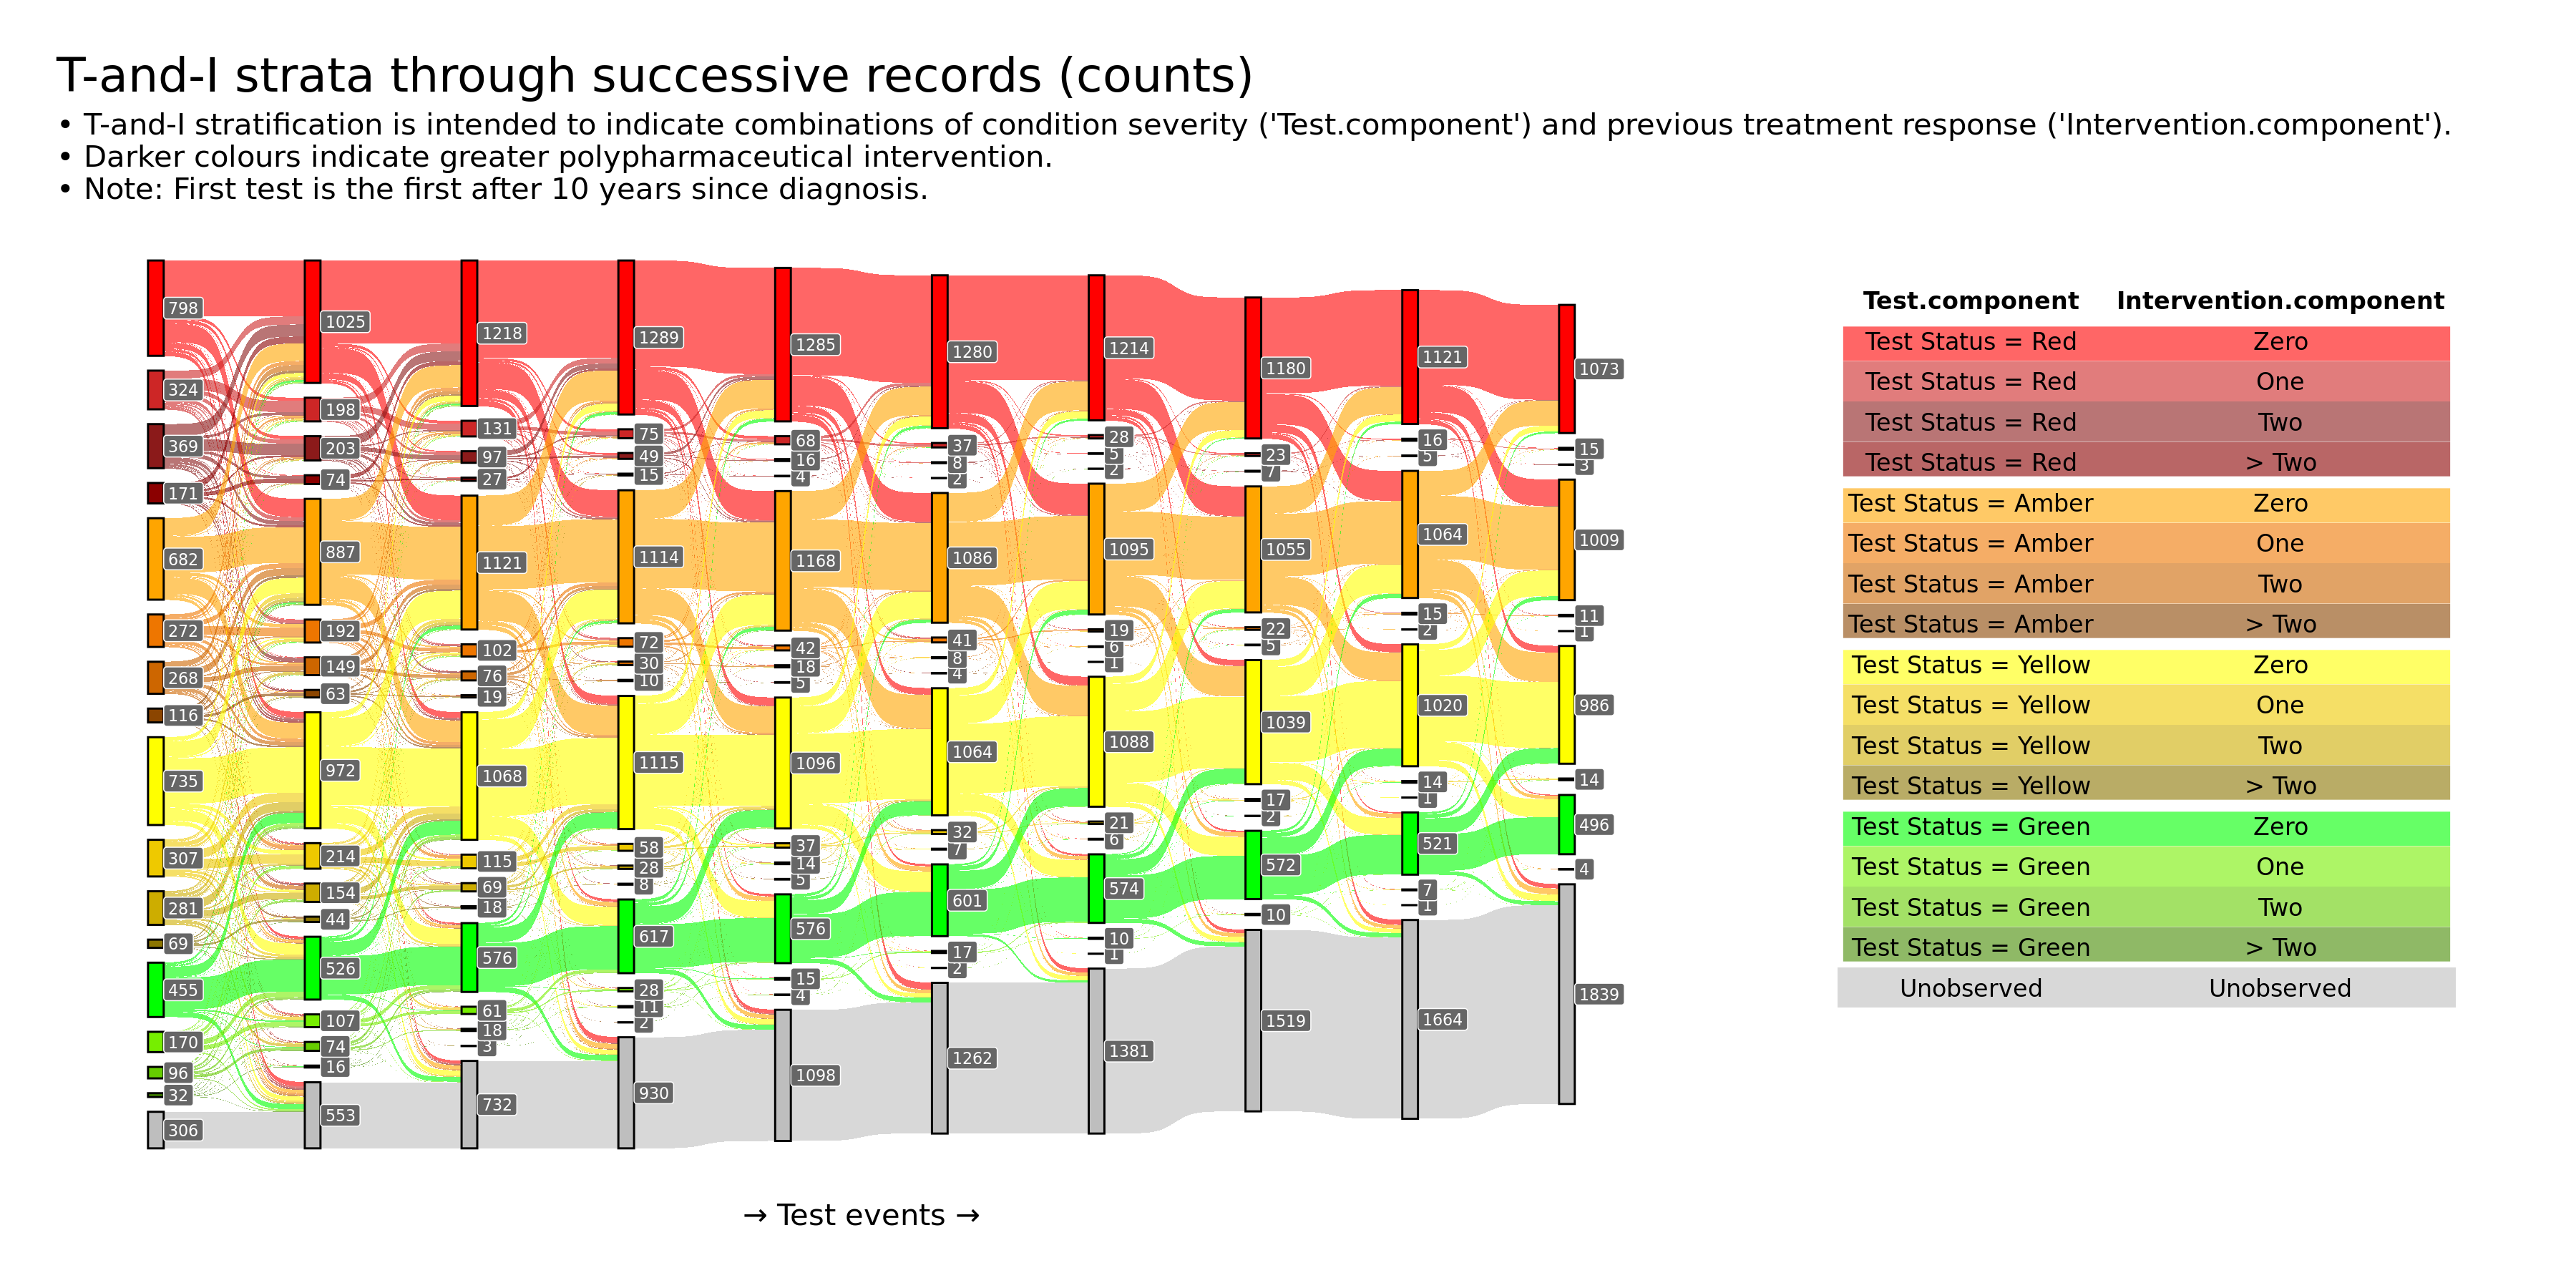

In [66]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_TandI %>%
            dplyr::select( - last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_TandI_factor %>% dplyr::select( TandI_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()

        # Make plot graphic.
        plot_sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            geom_sankey(
                flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
                ,node.color = 1
            ) +
            geom_sankey_label(
                aes(
                  x = as.numeric(x) + .05,
                  label = after_stat(paste0(freq))
                ),
                size = 8 / .pt, color = "white", fill = "gray40",
                hjust = 0
              ) +
            labs(
                title = "T-and-I strata through successive records (counts)"
                ,subtitle =
                    paste0(
                        "\u2022 T-and-I stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and previous treatment response (\'Intervention.component\').\n"
                        ,"\u2022 Darker colours indicate greater polypharmaceutical intervention.\n"
                        ,paste0("\u2022 Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_TandI_factor %>% dplyr::select( TandI_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = 'none'
                ,axis.text.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Make table explaining the strata.
        plot_table <-
            TandI_display_table %>%
            dplyr::select( - Value ) %>%
            # Basic table layout.
            gridExtra::tableGrob(
                rows = NULL
                ,theme = 
                ttheme_minimal(
                    core = list(
                        bg_params = list( fill = df_TandI_factor %>% dplyr::select( TandI_colours_order ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
                    )
                )
            ) %>%
            # Add sub-table borders to set the groups of colours apart.
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 2, b = 5, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 6, b = 9, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 10, b = 13, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 14, b = 17, l = 1, r = 2
            )

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 9, repr.plot.res = 200 )

        plot_TandI_Sankey <-
            cowplot::plot_grid(
                plot_sankey, plot_table
                ,nrow = 1
                ,rel_widths = c( 2/3, 1/3 )
            )

        plot_TandI_Sankey
    }

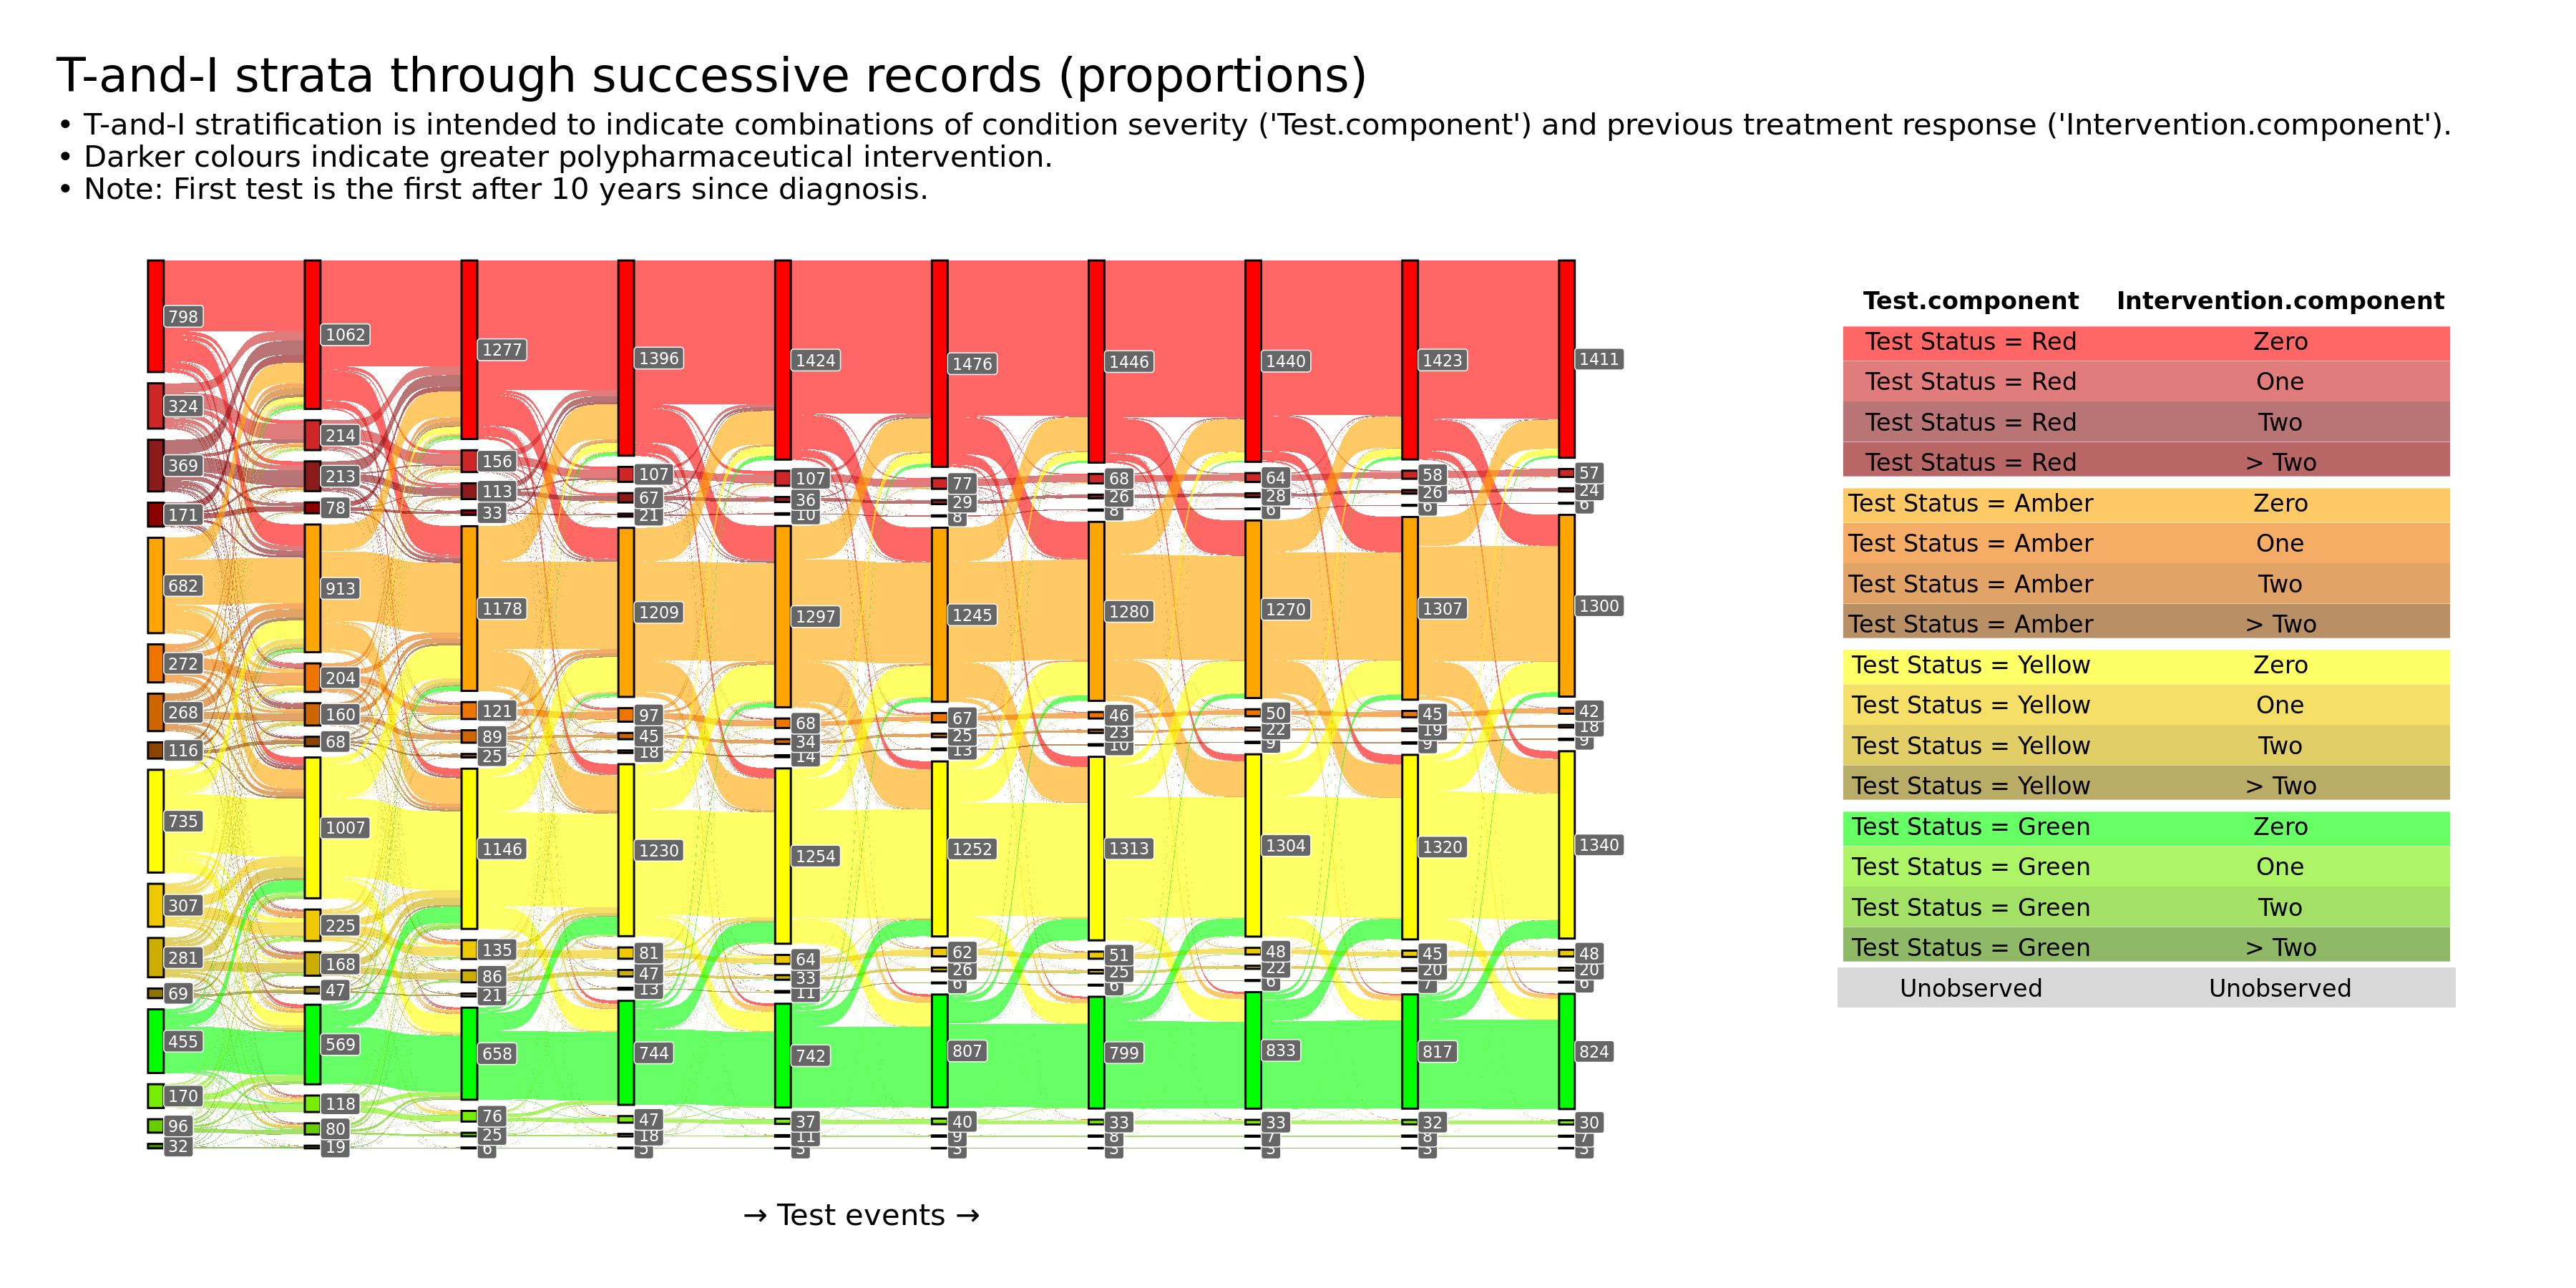

In [67]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_TandI_excludingUnobserved %>%
            dplyr::select( - last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_TandI_factor %>% dplyr::select( TandI_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()

        # Make plot graphic.
        plot_sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            geom_sankey(
                flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
                ,node.color = 1
            ) +
            geom_sankey_label(
                aes(
                  x = as.numeric(x) + .05,
                  label = after_stat(paste0(freq))
                ),
                size = 8 / .pt, color = "white", fill = "gray40",
                hjust = 0
              ) +
            labs(
                title = "T-and-I strata through successive records (proportions)"
                ,subtitle =
                    paste0(
                        "\u2022 T-and-I stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and previous treatment response (\'Intervention.component\').\n"
                        ,"\u2022 Darker colours indicate greater polypharmaceutical intervention.\n"
                        ,paste0("\u2022 Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_TandI_factor %>% dplyr::select( TandI_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = 'none'
                ,axis.text.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Make table explaining the strata.
        plot_table <-
            TandI_display_table %>%
            dplyr::select( - Value ) %>%
            # Basic table layout.
            gridExtra::tableGrob(
                rows = NULL
                ,theme = 
                ttheme_minimal(
                    core = list(
                        bg_params = list( fill = df_TandI_factor %>% dplyr::select( TandI_colours_order ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
                    )
                )
            ) %>%
            # Add sub-table borders to set the groups of colours apart.
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 2, b = 5, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 6, b = 9, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 10, b = 13, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 14, b = 17, l = 1, r = 2
            )

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 9, repr.plot.res = 200 )

        plot_TandI_Sankey_excludingUnobserved <-
            cowplot::plot_grid(
                plot_sankey, plot_table
                ,nrow = 1
                ,rel_widths = c( 2/3, 1/3 )
            )

        plot_TandI_Sankey_excludingUnobserved
    }

Some initial observations from the T-and-I Sankey diagram:
1. __Unlike the previous iteration where we looked at sequences from diagosis, these sequences from 10 years after diagnosis show an increase the proportion of records indicating a given test status with no prescription.__
    - Evidenced by a gradual increase in the size of ribbons joining the same colours, as we move from left to right in the graphic.

In the meeting of the wider project team at the end of the previous iteration, there was a request to view how individual records progress between the strata of the variable (a.k.a. the lanes) and across the events. The plot below shows the progression of a randomly-selected group of records. The random selection is taken every time the plot is rendered, and the count of records being selected can be set with the `n_records_to_sample` pareameter at the start of the code block. Note that he veritcal 'jitter' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences.

In [68]:
if ( run_laneSwitching_plots )
    {
        # Set plot parameters.
        n_records_to_sample <- 50

        # Make plot data.
        data_arbitrary_record_sequences <-
            sts_seqmine_TandI %>%
            dplyr::select( - last_col() ) %>%
            dplyr::sample_n( n_records_to_sample ) %>%
            tidyr::unite(
                col = "seqs"
                , sep = "-"
                ,remove = FALSE
                ) %>%
            dplyr::mutate_at(
                .vars = vars( seqs )
                ,.funs = funs( as.factor(.) )
            ) %>%
            tidyr::pivot_longer(
                cols = !seqs
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        data_strata_lanes <-
            df_TandI_factor %>%
            dplyr::select( TandI_fct_order ) %>%
            rep( times = data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% nrow() ) %>%
            as.data.frame() %>%
            `colnames<-`( data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% dplyr::pull() ) %>%
            tidyr::pivot_longer(
                cols = everything()
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        # Make plot graphic.
        plot_laneSwitching <-
            ggplot() +
            # ## Plot the ribbons / lanes for each stratum.
            geom_raster(
                data = data_strata_lanes
                ,aes(
                    x = variable
                    ,y = value %>% factor( ., levels = rev( levels( . ) ) )
                    ,fill = value
                    ,alpha = 0.5
                )
            ) +
            # ## Plot a white line segment to separate the two groups.
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 1.5, yend = 1.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 5.5, yend = 5.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 9.5, yend = 9.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 13.5, yend = 13.5, linewidth = 3, colour = "white" ) +
            # ## Plot the randomly-selected sequences as lines.
            geom_path(
                data = data_arbitrary_record_sequences %>% dplyr::mutate( grp =  rep(1:n_records_to_sample, each = n_iterations) )
                ,aes(
                    x = variable
                    ,y = value
                    ,group = grp
                )
                ,position = position_jitter( width = 0, height = 0.2 )
            ) +
            # ## Format the plot.
            scale_fill_manual(
                values = df_TandI_factor %>% dplyr::select( TandI_colours_order ) %>% dplyr::pull()
            ) +
            scale_alpha(guide = 'none') +
            labs(
                title = "\"Lane switching\" of randomly-selected sequences of successive records: T-and-I category"
                ,subtitle =
                    paste0(
                        "\u2022 T-and-I stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and previous treatment response (\'Intervention.component\').\n"
                        ,"\u2022 Darker colours indicate greater polypharmaceutical intervention.\n"
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.title.position = 'plot'
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,legend.position = 'none'
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.text.x = element_blank()
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 9, repr.plot.res = 200 )

        plot_laneSwitching_Tand_I <-
            cowplot::plot_grid(
                plot_laneSwitching, plot_table
                ,nrow = 1
                ,rel_widths = c( 2/3, 1/3 )
            ) %>%
            cowplot::add_sub(
                label = expression( paste(~bold("Note 1:"), " A new set of records will be selected every time this plot is rendered." ) )
                ,x = 0, hjust = 0
            )  %>%
            cowplot::add_sub(
                label = expression( paste(~bold("Note 2:"), " Vertical \'jitter\' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences." ))
                ,x = 0, hjust = 0
            ) 

        plot_laneSwitching_Tand_I %>% cowplot::ggdraw()
}

In [69]:
if ( run_laneSwitching_plots )
    {
        TraMineR::seqtab( sts_seqmine_TandI ) %>%
        attributes() %>%
        purrr::pluck( "freq" ) %>%
        tibble::rownames_to_column( "sequence" ) %>%
        dplyr::arrange( desc( Freq ) ) %>%
        dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
        # Remove the leading "None/[0-9]"
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
            ) %>%
        # Replace the "-" that joins the events with an arrow.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
            ) %>%
        # Use words instead of symbols for the number of timesteps.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
            ) %>%
        # Repalce "Unobserved for [0-9]*" with "End".
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
            ) %>%
        suppressWarnings()
    }

sequence                                    Freq Percent   cum_sum_percent
1  END                                         306  5.6136489  5.613649      
2  Red Zero Rx for 10 → END                     95  1.7427995  7.356448      
3  Green Zero Rx for 10 → END                   52  0.9539534  8.310402      
4  Green Zero Rx for 1 → END                    43  0.7888461  9.099248      
5  Red Zero Rx for 1 → END                      37  0.6787745  9.778022      
6  Yellow Zero Rx for 1 → END                   35  0.6420840 10.420106      
7  Amber Zero Rx for 1 → END                    26  0.4769767 10.897083      
8  Red Two Rx for 1 → Red Zero Rx for 9 → END   25  0.4586314 11.355715      
9  Red More Rx for 1 → Red Zero Rx for 9 → END  24  0.4402862 11.796001      
10 Yellow Zero Rx for 2 → END                   21  0.3852504 12.181251

#### Multimorbidity strata

In the next plot, the Sankey plot visualises the proportions of patient records moving from no multimorbidity to multimorbidity.

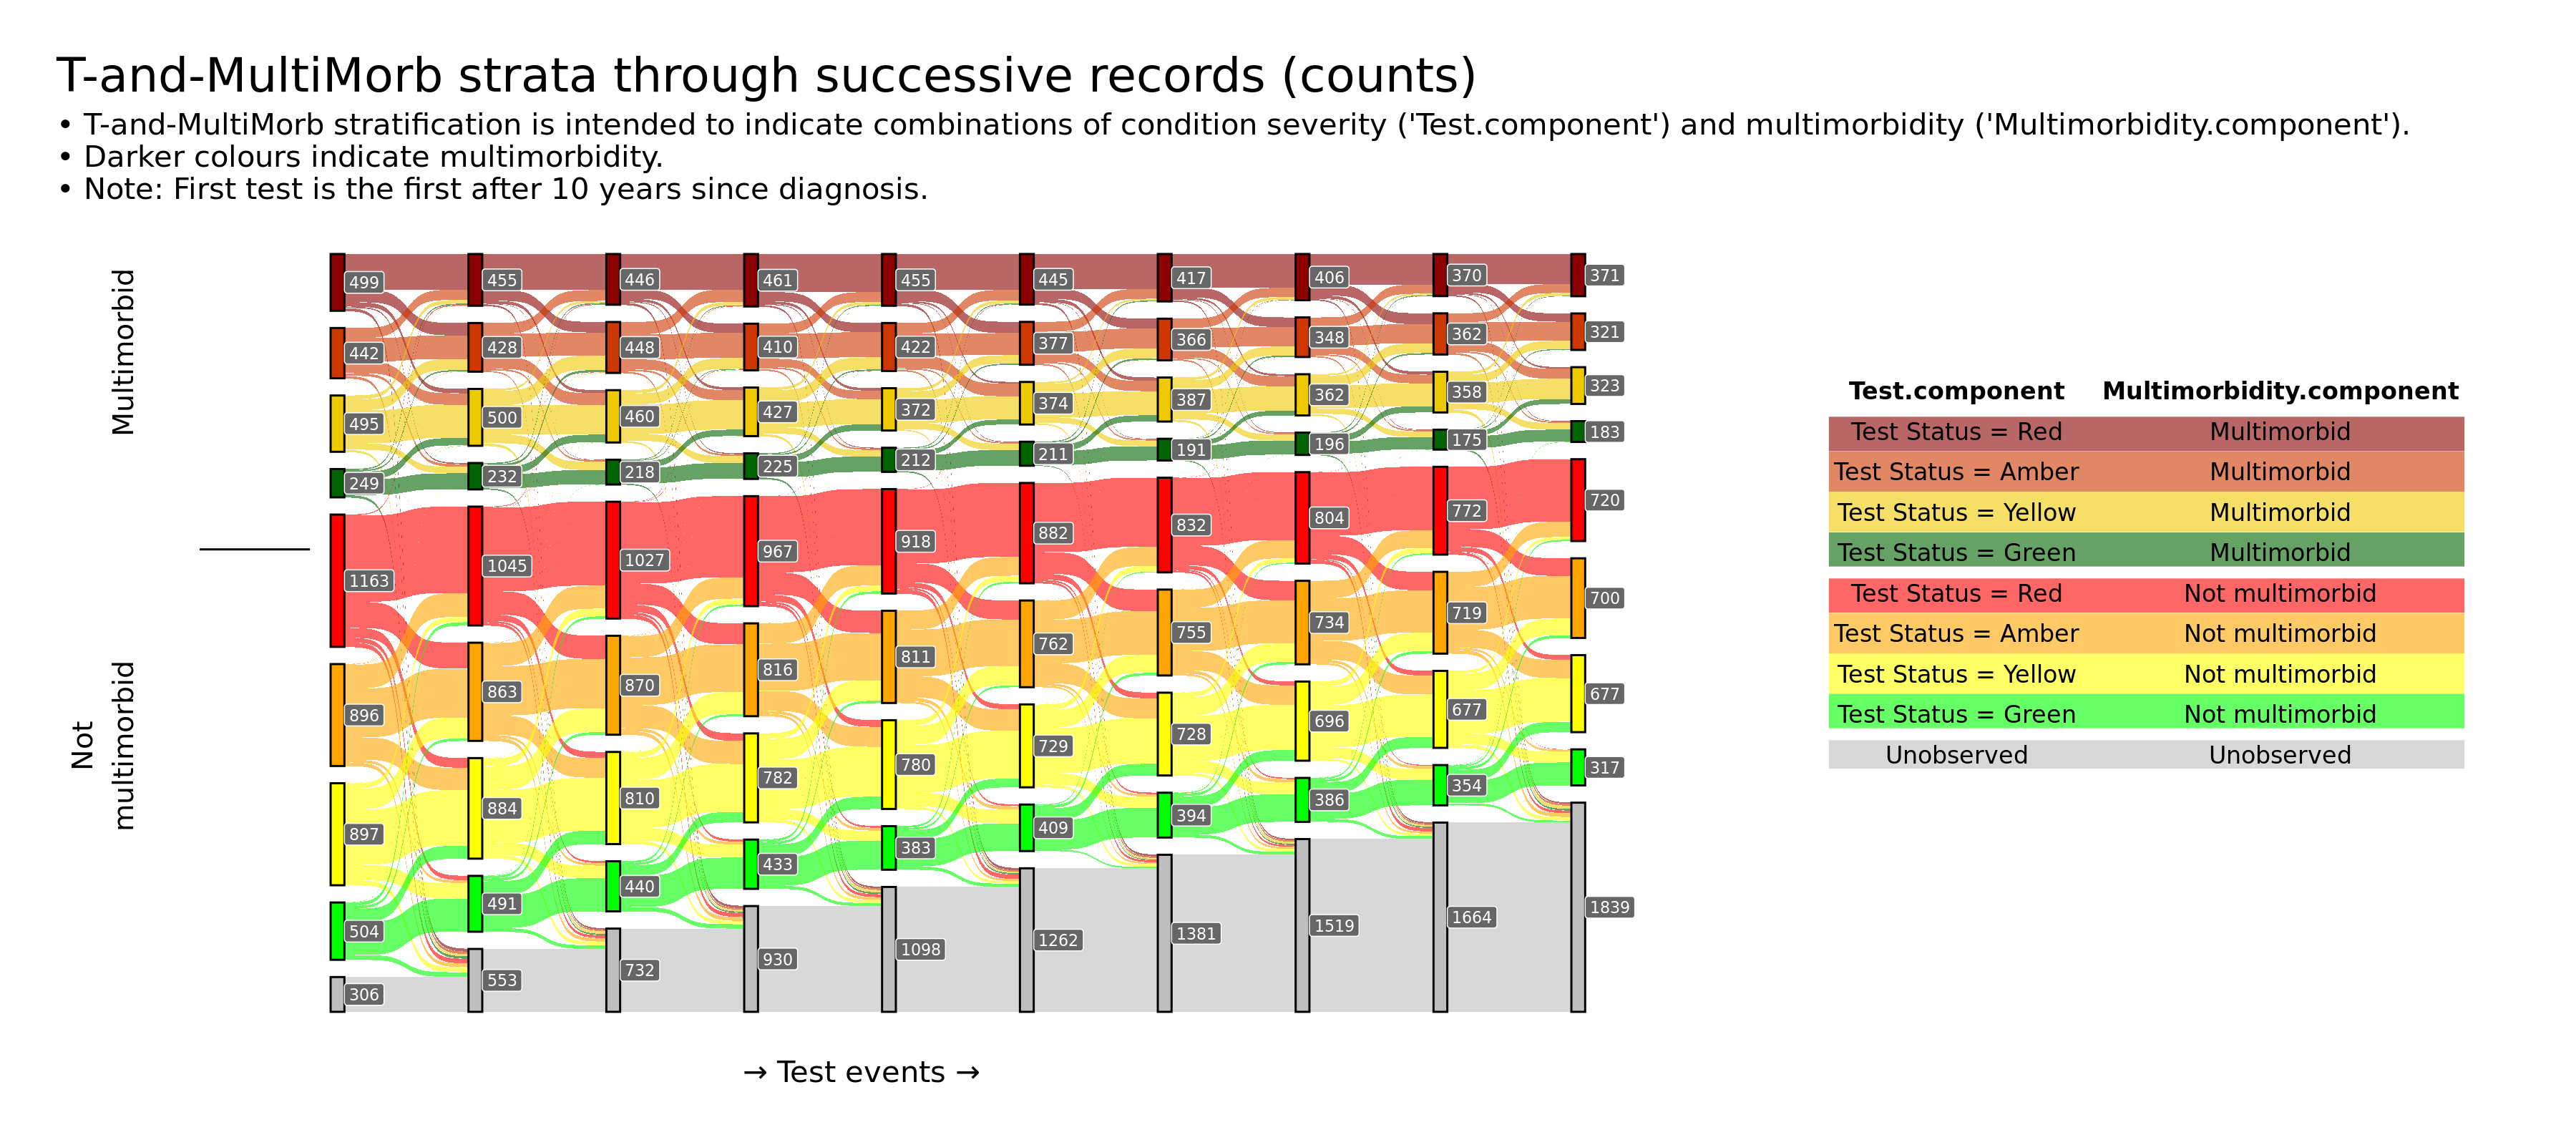

In [70]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_TandMultiMorb %>%
            # Remove the default start node.
            dplyr::select( - last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()
    
        # Calculate where to place the line segment that divides the multimorb from the not-multimorbid strata.
        n_patients_Multimorb_at_start <- sts_seqmine_TandMultiMorb %>% filter( !stringr::str_detect( a2, pattern = "Not" ) ) %>% nrow()
        n_patients_notMultimorb_at_start <- sts_seqmine_TandMultiMorb %>% filter( stringr::str_detect( a2, pattern = "Not" ) ) %>% nrow()
        segment_offset <-
            ifelse(
                n_patients_notMultimorb_at_start > n_patients_Multimorb_at_start
                ,( ( n_patients_Multimorb_at_start + n_patients_notMultimorb_at_start ) / 2 ) - n_patients_Multimorb_at_start
                ,( ( n_patients_Multimorb_at_start + n_patients_notMultimorb_at_start ) / 2 ) + n_patients_notMultimorb_at_start
            )
            

        # Make plot graphic.
        plot_sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            # Plot Sankey.
            geom_sankey(
                flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
                ,node.color = 1
                #,space = 33
            ) +
            # Annotate the left side of the plot with labels.
            annotate("segment", x = 0, xend = 0.8, y = segment_offset, yend = segment_offset ) +
            annotate("text", x = -1, y = segment_offset + ( n_patients_notMultimorb_at_start / 2 ), label = "\n\n\nMultimorbid", angle = 90, size = 5, hjust = "center" ) +
            annotate("text", x = -1, y = segment_offset - ( n_patients_notMultimorb_at_start / 2 ), label = "\n\nNot\nmultimorbid", angle = 90, size = 5, hjust = "center" ) +
            # Overlay count labels.
            geom_sankey_label(
                aes(
                  x = as.numeric(x) + .05,
                  label = after_stat(paste0(freq))
                ),
                size = 8 / .pt, color = "white", fill = "gray40",
                hjust = 0
              ) +
            labs(
                title = "T-and-MultiMorb strata through successive records (counts)"
                ,subtitle =
                    paste0(
                        "\u2022 T-and-MultiMorb stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and multimorbidity (\'Multimorbidity.component\').\n"
                        ,"\u2022 Darker colours indicate multimorbidity.\n"
                        ,paste0("\u2022 Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
            # Finish theme.
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = 'none'
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Make table explaining the strata.
        plot_table <-
            TandMultiMorb_display_table %>%
            dplyr::select( - Value ) %>%
            # Basic table layout.
            gridExtra::tableGrob(
                rows = NULL
                ,theme = 
                ttheme_minimal(
                    core = list(
                        bg_params = list( fill = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_colours_order ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
                    )
                )
            ) %>%
            # Add sub-table borders to set the groups of colours apart.
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 2, b = 5, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 6, b = 9, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 10, b = 10, l = 1, r = 2
            )

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

        plot_TandMultiMorb_Sankey <-
            cowplot::plot_grid(
                plot_sankey, plot_table
                ,nrow = 1
                ,rel_widths = c( 2/3, 1/3 )
            )

        plot_TandMultiMorb_Sankey
    }

In [71]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_TandMultiMorb_excludingUnobserved %>%
            # Remove the default start node.
            dplyr::select( - last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()
    
        # Calculate where to place the line segment that divides the multimorb from the not-multimorbid strata.
        n_patients_Multimorb_at_start <- sts_seqmine_TandMultiMorb_excludingUnobserved %>% filter( !stringr::str_detect( a2, pattern = "Not" ) ) %>% nrow()
        n_patients_notMultimorb_at_start <- sts_seqmine_TandMultiMorb_excludingUnobserved %>% filter( stringr::str_detect( a2, pattern = "Not" ) ) %>% nrow()
        segment_offset <-
            ifelse(
                n_patients_notMultimorb_at_start > n_patients_Multimorb_at_start
                ,( ( n_patients_Multimorb_at_start + n_patients_notMultimorb_at_start ) / 2 ) - n_patients_Multimorb_at_start
                ,( ( n_patients_Multimorb_at_start + n_patients_notMultimorb_at_start ) / 2 ) + n_patients_notMultimorb_at_start
            )
            

        # Make plot graphic.
        plot_sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            # Plot Sankey.
            geom_sankey(
                flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
                ,node.color = 1
                #,space = 33
            ) +
            # Annotate the left side of the plot with labels.
            annotate("segment", x = 0, xend = 0.8, y = segment_offset, yend = segment_offset ) +
            annotate("text", x = -1, y = segment_offset + ( n_patients_notMultimorb_at_start / 2 ), label = "\n\n\nMultimorbid", angle = 90, size = 5, hjust = "center" ) +
            annotate("text", x = -1, y = segment_offset - ( n_patients_notMultimorb_at_start / 2 ), label = "\n\nNot\nmultimorbid", angle = 90, size = 5, hjust = "center" ) +
            # Overlay count labels.
            geom_sankey_label(
                aes(
                  x = as.numeric(x) + .05,
                  label = after_stat(paste0(freq))
                ),
                size = 8 / .pt, color = "white", fill = "gray40",
                hjust = 0
              ) +
            labs(
                title = "T-and-MultiMorb strata through successive records (proportions)"
                ,subtitle =
                    paste0(
                        "\u2022 T-and-MultiMorb stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and multimorbidity (\'Multimorbidity.component\').\n"
                        ,"\u2022 Darker colours indicate multimorbidity.\n"
                        ,paste0("\u2022 Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
            # Finish theme.
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = 'none'
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Make table explaining the strata.
        plot_table <-
            TandMultiMorb_display_table %>%
            dplyr::filter( Value != "Unobserved" ) %>%
            dplyr::select( - Value ) %>%
            # Basic table layout.
            gridExtra::tableGrob(
                rows = NULL
                ,theme = 
                ttheme_minimal(
                    core = list(
                        bg_params = list( fill = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_colours_order ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
                    )
                )
            ) %>%
            # Add sub-table borders to set the groups of colours apart.
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 2, b = 5, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 6, b = 9, l = 1, r = 2
            ) 

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

        plot_TandMultiMorb_Sankey_excludingUnobserved <-
            cowplot::plot_grid(
                plot_sankey, plot_table
                ,nrow = 1
                ,rel_widths = c( 2/3, 1/3 )
            )

        plot_TandMultiMorb_Sankey_excludingUnobserved
    }

Some initial observations from the T-and-I Sankey diagram:
1. __Unlike the previous iteration where we looked at sequences from diagosis, these sequences from 10 years after diagnosis show the greatest proportion of records have a Red test status while not being multimorbid (as opposed to yellow and multimorbid).__

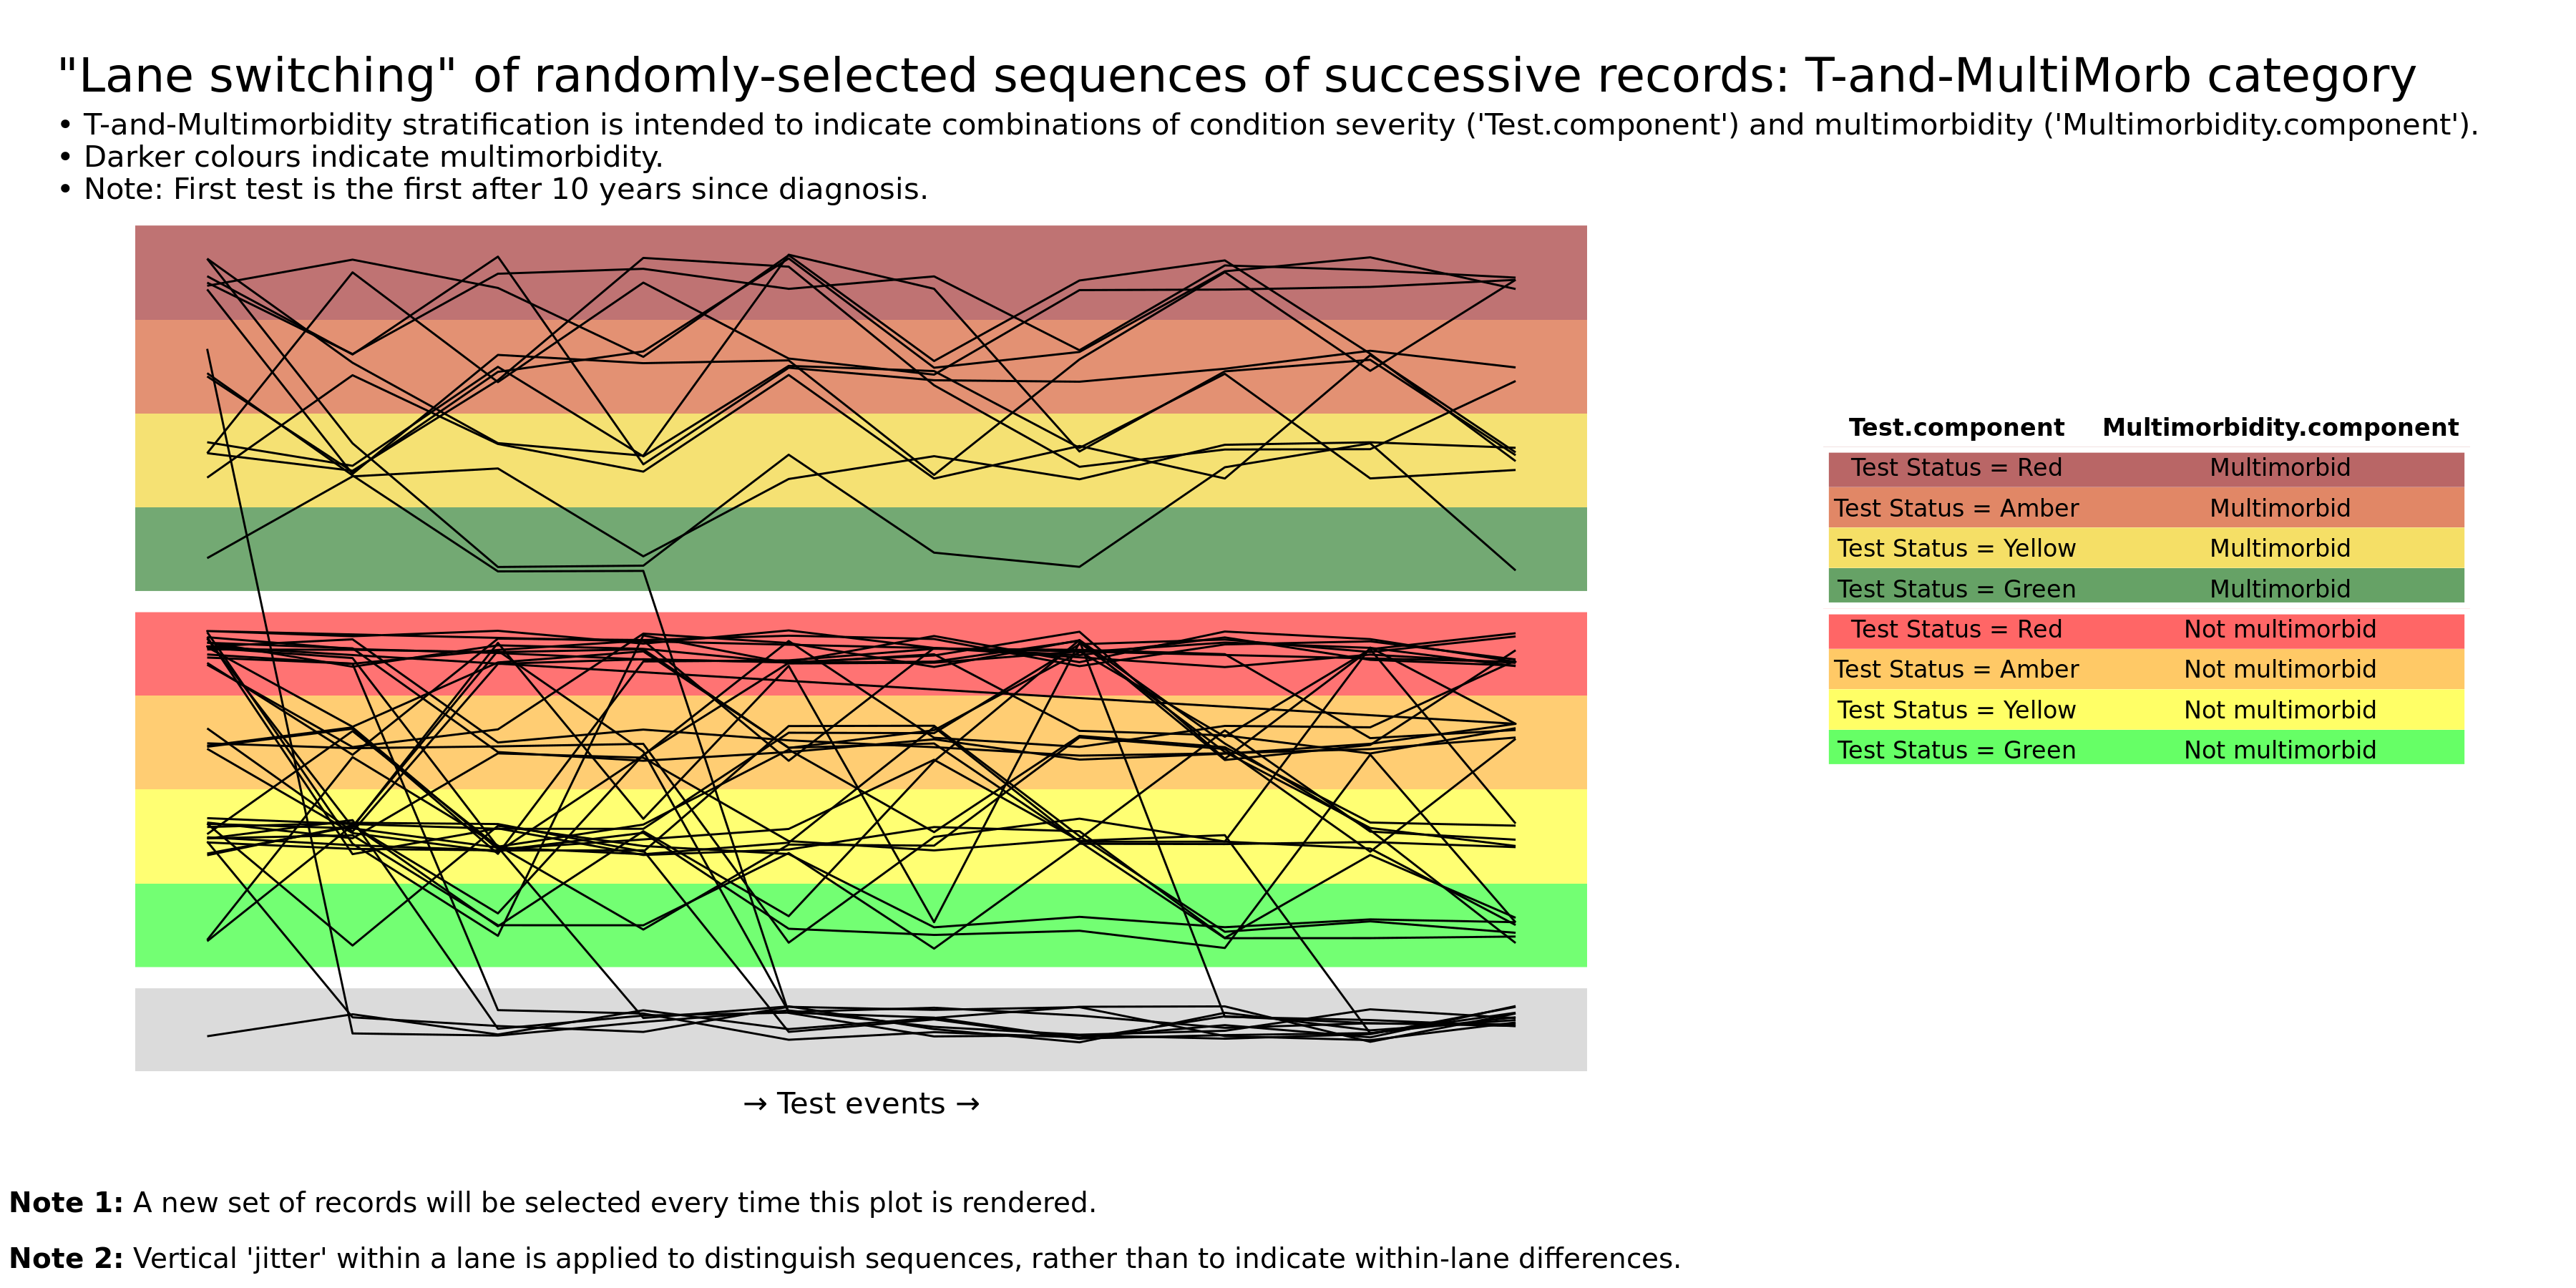

In [72]:
if ( run_laneSwitching_plots )
    {
        # Set plot parameters.
        n_records_to_sample <- 50

        # Make plot data.
        data_arbitrary_record_sequences <-
            sts_seqmine_TandMultiMorb %>%
            dplyr::select( - last_col() ) %>%
            dplyr::sample_n( n_records_to_sample ) %>%
            tidyr::unite(
                col = "seqs"
                , sep = "-"
                ,remove = FALSE
                ) %>%
            dplyr::mutate_at(
                .vars = vars( seqs )
                ,.funs = funs( as.factor(.) )
            ) %>%
            tidyr::pivot_longer(
                cols = !seqs
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        data_strata_lanes <-
            df_TandMultiMorb_factor %>%
            dplyr::select( TandMultiMorb_fct_order ) %>%
            rep( times = data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% nrow() ) %>%
            as.data.frame() %>%
            `colnames<-`( data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% dplyr::pull() ) %>%
            tidyr::pivot_longer(
                cols = everything()
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        # Make plot graphic.
        plot_laneSwitching <-
            ggplot() +
            # ## Plot the ribbons / lanes for each stratum.
            geom_raster(
                data = data_strata_lanes
                ,aes(
                    x = variable
                    ,y = value %>% factor( ., levels = rev( levels( . ) ) )
                    ,fill = value
                    ,alpha = 0.5
                )
            ) +
            # ## Plot a white line segment to separate the two groups.
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 1.5, yend = 1.5, linewidth = 5, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 5.5, yend = 5.5, linewidth = 5, colour = "white" ) +
            # ## Plot the randomly-selected sequences as lines.
            geom_path(
                data = data_arbitrary_record_sequences
                ,aes(
                    x = variable
                    ,y = value
                    ,group = seqs
                )
                ,position = position_jitter( width = 0, height = 0.2 )
            ) +
            # ## Format the plot.
            scale_fill_manual(
                values = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_colours_order ) %>% dplyr::pull()
            ) +
            scale_alpha(guide = 'none') +
            labs(
                title = "\"Lane switching\" of randomly-selected sequences of successive records: T-and-MultiMorb category"
                ,subtitle =
                    paste0(
                        "\u2022 T-and-Multimorbidity stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and multimorbidity (\'Multimorbidity.component\').\n"
                        ,"\u2022 Darker colours indicate multimorbidity.\n"
                        ,paste0("\u2022 Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.title.position = 'plot'
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,legend.position = 'none'
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.text.x = element_blank()
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 9, repr.plot.res = 200 )

        plot_laneSwitching_Tand_MultiMorb <-
            cowplot::plot_grid(
                plot_laneSwitching, plot_table
                ,nrow = 1
                ,rel_widths = c( 2/3, 1/3 )
            ) %>%
            cowplot::add_sub(
                label = expression( paste(~bold("Note 1:"), " A new set of records will be selected every time this plot is rendered." ) )
                ,x = 0, hjust = 0
            )  %>%
            cowplot::add_sub(
                label = expression( paste(~bold("Note 2:"), " Vertical \'jitter\' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences." ))
                ,x = 0, hjust = 0
            ) 

        plot_laneSwitching_Tand_MultiMorb %>% cowplot::ggdraw()
    }

In [73]:
if ( run_laneSwitching_plots )
    {
        TraMineR::seqtab( sts_seqmine_TandMultiMorb ) %>%
        attributes() %>%
        purrr::pluck( "freq" ) %>%
        tibble::rownames_to_column( "sequence" ) %>%
        dplyr::arrange( desc( Freq ) ) %>%
        dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
        # Remove the leading "None/[0-9]"
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
            ) %>%
        # Replace the "-" that joins the events with an arrow.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
            ) %>%
        # Use words instead of symbols for the number of timesteps.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
            ) %>%
        # Repalce "Unobserved for [0-9]*" with "End".
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
            ) %>%
        suppressWarnings()
    }

sequence                           Freq Percent   cum_sum_percent
1  END                                306  5.6136489  5.613649      
2  Red Not multimorbid for 10 → END   167  3.0636580  8.677307      
3  Red Multimorbid for 10 → END        55  1.0089892  9.686296      
4  Green Not multimorbid for 10 → END  53  0.9722987 10.658595      
5  Yellow Not multimorbid for 1 → END  44  0.8071913 11.465786      
6  Green Not multimorbid for 1 → END   42  0.7705008 12.236287      
7  Red Not multimorbid for 1 → END     41  0.7521556 12.988442      
8  Amber Not multimorbid for 1 → END   32  0.5870482 13.575491      
9  Red Multimorbid for 1 → END         26  0.4769767 14.052467      
10 Amber Multimorbid for 1 → END       22  0.4035957 14.456063

### 7.4.2 Build simulation models, if applicable
Not applicable for this iteration.

### 7.4.3 Design and test model evaluation rig

Not applicable for this iteration.

### 7.4.4 Set up and/or update the evidence template
Not applicable for this iteration.

## Stage 5: Evaluation
This tasks for this stage are:
1. Meet with Clinical Review Board to assess validity.
2. Set requirements for next interation of stages 1-5.

### 7.5.1. Meet with Clinical Review Board to assess validity
Notes from meeting of the Clinical Review Board on Thursday 6th June:
- The comparison with 10-year periods immediately following diagnosis suggest that there is a burn-in period that settles to baseline switching between states. Future work might quantify the trend in some measure of switching-ness to identify the approximate point of settling.
- The 'Unobserved' state in the lane-switching plot distracts from seeing the other, more interesting trajectories.
- The note books are bulky and repetitive. It might be better to modularise the syntax into other scripts that run basic functions. While this will make things more succinct, the explicit presentation of all the steps was deliberate. That said, it will be better to have a single point of truth for, for example, generating the cohort, instead of copy+pasting any bug fixes, retrospectively.
- It's time to move on to forecasting test status. Ultimately, we want to know if 'Monitor' is wasted burden. If it is, then it would be useful to have forecasting models that would simulate the relatively-burdensome effect of the 'Monitor' state. The modelling study should be able to tell us whether 'Hold' or 'Adjust' are more helpful, and (to some degree of clarity) tell us in what contexts they are helpful.
- The test-status, RAYG values are useful for presenting information and were useful for simplifying our studies. But the raw HbA1c values are more informative and easier to model, so we should use them, going forward.
- The new model needs to be applicable to individual cases for case-by-case simulation (which at best will be on apopulation subgroup-by-population subgroup basis), and applicable to whole-population simulation summaries. This will require more than one kind of model, for example, generalised linear mixed models for individuals and generalised estimating equations for populations.

### 7.5.2 Set requirements for next interation of stages 1-5.
Requirements for the next iteration are:
1. Remove the 'Unobserved' state from lane-switching plots.
2. Convert section of the notebook into other scripts that are called, rather than repeating them, here.
3. Model HbA1c values as a function of the two preceding HMA states and however-many preceding HbA1c values provide for the best fit.